# W261 Team 4_1 - Phase 2 EDA

## Team

- Maegan Kornexl: mkornexl@berkeley.edu
- I-Hsiu Kao: ihsiukao@berkeley.edu
- Nathan Arias: nathanarias@berkeley.edu
- Thomas Dolan: tdolan@berkeley.edu

## Phase Leader Plan 

| Phase   | Leader |
|--------|-------|
| Phase I - Project Plan: Describe Datasets, Tasks, and Metrics      | Thomas Dolan    |
| Phase II EDA, Baseline Pipeline On All Data    | Nathan Arias     |
| Phase III - Advanced Model Architectures and Loss Functions | I-Hsiu Kao    |
| Phase IV - Final Project | Maegan Kornexl    |


## Credit Assignment 

| Responsibility   | Team Member(s) | Time Commitment (Hrs)| 
|--------|-------|-------|
| Four Tables and OTPW EDA| I-Hsiu Kao, Nathan Arias        | 10, 5|
| Model Building                                   |  Nathan Arias, I-Hsiu Kao  |  4, 5|
| Abstract, Project Description                                             | Maegan Kornexl| 3|
| Map out pipelines for cleaning, preprocessing, modeling                                              | Thomas Dolan| 7 |
| Presentation Preparation                    | All    |  5|
|Blob Storage and Team Permissions| Thomas Dolan | 2|

#Project Description

## Abstract
Approximately [7-9k flights daily](https://www.transtats.bts.gov/HomeDrillChart.asp) (25% of domestic flights annually) are delayed in the United States, costing airlines and airports [$16-20k hourly](https://www.sciencedirect.com/science/article/abs/pii/S1366554518307142) and leaving hundreds of thousands of passengers frustrated and scrambling. Delays also cost passengers ~$47 hourly, meaning each delay drastically increases the chances of passenger dissatisfaction and customer loss. Emerald Airlines’ annual survey reported passengers would be more amenable to a 15+ minute delay given advanced warning of ~2-3 hours (87% “Definitely Agree”). Thus, the feasibility of detecting delays must be determined. 

Analysis of the [NOAA GSOD](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C00516) (daily weather) and the [DoT ATP](https://www.transtats.bts.gov/Tables.asp?QO_VQ=EFD&QO_anzr=Nv4yv0r%FDb0-gvzr%FDcr4s14zn0pr%FDQn6n&QO_fu146_anzr=b0-gvzr) (airline performance) datasets via Lasso and Ridge regularization indicated that weather and visibility conditions impacted potential delays the most, while a logistic regression learning model indicated an average classification ability (via F-beta score) of ~48-54%. It’s hypothesized that the data is multidimensional, so Phases 3 and 4 will investigate graph network and support vector machine usage.



### Data Description
#####Flights Data (ATP):
This dataset includes on-time performance data for passenger flights, sourced from the U.S. Department of Transportation. It covers flight details from 2015 to 2021, with 109 columns for millions of flights. The data is available in subsets for 1 quarter, 2 quarters, and 1 year, which we will be using for different phases of the project.

#####Weather Data (GSOD):
As weather is known to impact flight schedules, this dataset contains weather conditions from the National Oceanic and Atmospheric Administration. It includes 177 features from 2015 to 2021. We will use this dataset along with the Flights Data to generate weather patterns at both departure and arrival points. This pattern is crucial for understanding the environmental factors affecting flight schedule.

#####Station Data:
This dataset provides metadata about stations. It includes key details about each station, facilitating a deeper understanding of how specific stations' characteristics might influence flight delays.

#####Airport Codes:
This table helps conversions between IATA and ICAO airport codes. This cross-referencing is essential for integrating different datasets, ensuring cohesive and comprehensive analysis.

#####OTPW (ATP and GSOD merged):
This dataset features a pre-joined dataset combining flight on-time performance with local weather data, creating a robust foundation for predictive modeling. This merged dataset is available for various periods, enhancing the analytical depth available for identifying delay determinants.

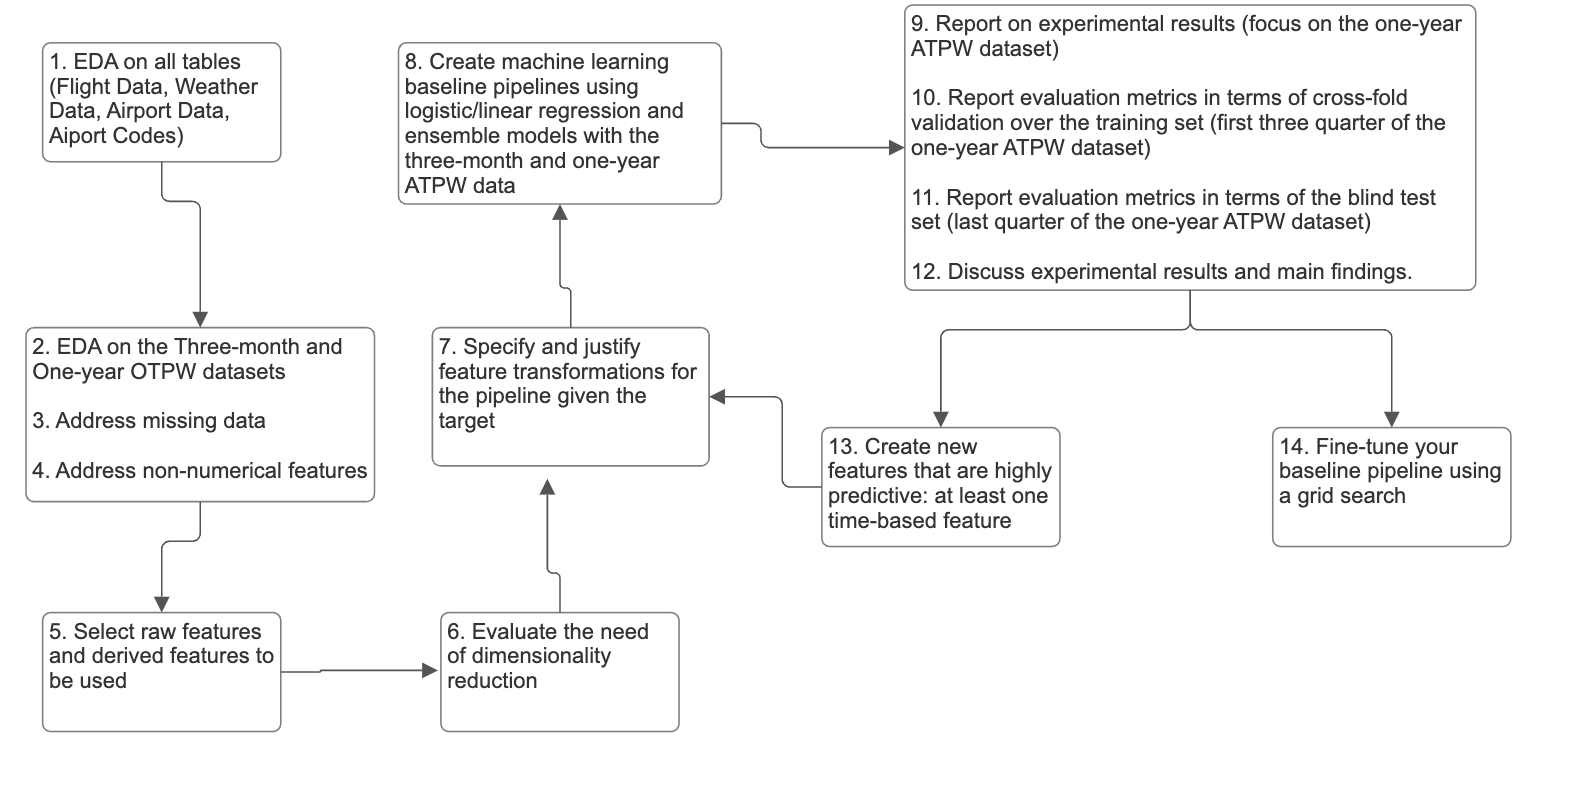

In [0]:
from IPython.display import display, Image

image_path = '/Workspace/Users/ihsiukao@berkeley.edu/phase2_block.png'
display(Image(filename=image_path))

In [0]:
import numpy as np
import seaborn as sns
import pandas as pd 
import plotly.express as px 
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql.functions import col
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType, DoubleType, FloatType, IntegerType
import re
from pyspark.sql.functions import array_contains
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Exploratory Data Analysis (EDA)

##EDA: Flights Data
####This dataset includes on-time performance data for passenger flights, sourced from the U.S. Department of Transportation. It covers flight details from 2015 to 2021, with 109 columns for millions of flights. The data is available in subsets for 1 quarter, 2 quarters, and 1 year, which we will be using for different phases of the project.


####Dictionary

In [0]:
df_flights = spark.read.parquet(f"dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data_3m/")
display(df_flights.limit(10).toPandas())

QUARTER  MONTH  DAY_OF_MONTH  ...  DIV5_WHEELS_OFF DIV5_TAIL_NUM  YEAR
0        1      2            19  ...             None          None  2015
1        1      2            20  ...             None          None  2015
2        1      2            21  ...             None          None  2015
3        1      2            22  ...             None          None  2015
4        1      2            23  ...             None          None  2015
5        1      2            24  ...             None          None  2015
6        1      2            25  ...             None          None  2015
7        1      2            26  ...             None          None  2015
8        1      2            27  ...             None          None  2015
9        1      2            28  ...             None          None  2015

[10 rows x 109 columns]

In [0]:
flight_data_dictionary = {
    'QUARTER': {'description': 'Quarter (1-4)', 'data_type': 'integer'},
    'MONTH': {'description': 'Month', 'data_type': 'integer'},
    'YEAR': {'description': 'Year', 'data_type': 'integer'},
    'DAY_OF_MONTH': {'description': 'Day of Month', 'data_type': 'integer'},
    'DAY_OF_WEEK': {'description': 'Day of Week', 'data_type': 'integer'},
    'FL_DATE': {'description': 'Flight Date (yyyymmdd)', 'data_type': 'datetime'},
    'OP_UNIQUE_CARRIER': {'description': 'Unique Carrier Code', 'data_type': 'string'},
    'OP_CARRIER_AIRLINE_ID': {'description': 'An identification number assigned by US DOT', 'data_type': 'integer'},
    'OP_CARRIER': {'description': 'Code assigned by IATA and commonly used to identify a carrier', 'data_type': 'string'},
    'TAIL_NUM': {'description': 'Tail Number', 'data_type': 'string'},
    'OP_CARRIER_FL_NUM': {'description': 'Flight Number', 'data_type': 'integer'},
    'ORIGIN_AIRPORT_ID': {'description': 'Origin Airport, Airport ID', 'data_type': 'integer'},
    'ORIGIN_AIRPORT_SEQ_ID': {'description': 'Origin Airport, Airport Sequence ID', 'data_type': 'integer'},
    'ORIGIN_CITY_MARKET_ID': {'description': 'Origin Airport, City Market ID', 'data_type': 'integer'},
    'ORIGIN': {'description': 'Origin Airport', 'data_type': 'string'},
    'ORIGIN_CITY_NAME': {'description': 'Origin Airport, City Name', 'data_type': 'string'},
    'ORIGIN_STATE_ABR': {'description': 'Origin Airport, State Code', 'data_type': 'string'},
    'ORIGIN_STATE_FIPS': {'description': 'Origin Airport, State Fips', 'data_type': 'integer'},
    'ORIGIN_STATE_NM': {'description': 'Origin Airport, State Name', 'data_type': 'string'},
    'ORIGIN_WAC': {'description': 'Origin Airport, World Area Code', 'data_type': 'integer'},
    'DEST_AIRPORT_ID': {'description': 'Destination Airport, Airport ID', 'data_type': 'integer'},
    'DEST_AIRPORT_SEQ_ID': {'description': 'Destination Airport, Airport Sequence ID', 'data_type': 'integer'},
    'DEST_CITY_MARKET_ID': {'description': 'Destination Airport, City Market ID', 'data_type': 'integer'},
    'DEST': {'description': 'Destination Airport', 'data_type': 'string'},
    'DEST_CITY_NAME': {'description': 'Destination Airport, City Name', 'data_type': 'string'},
    'DEST_STATE_ABR': {'description': 'Destination Airport, State Code', 'data_type': 'string'},
    'DEST_STATE_FIPS': {'description': 'Destination Airport, State Fips', 'data_type': 'integer'},
    'DEST_STATE_NM': {'description': 'Destination Airport, State Name', 'data_type': 'string'},
    'DEST_WAC': {'description': 'Destination Airport, World Area Code', 'data_type': 'integer'},
    'CRS_DEP_TIME': {'description': 'CRS Departure Time', 'data_type': 'integer'},
    'DEP_TIME': {'description': 'Actual Departure Time', 'data_type': 'integer'},
    'DEP_DELAY': {'description': 'Difference in minutes between scheduled and actual departure time', 'data_type': 'double'},
    'DEP_DELAY_NEW': {'description': 'Difference in minutes between scheduled and actual departure time, with early departures set to 0', 'data_type': 'double'},
    'DEP_DEL15': {'description': 'Departure Delay Indicator, 15 Minutes or More', 'data_type': 'double'},
    'DEP_DELAY_GROUP': {'description': 'Departure Delay intervals, every 15 minutes', 'data_type': 'integer'},
    'DEP_TIME_BLK': {'description': 'CRS Departure Time Block, Hourly Intervals', 'data_type': 'string'},
    'TAXI_OUT': {'description': 'Taxi Out Time, in Minutes', 'data_type': 'double'},
    'WHEELS_OFF': {'description': 'Wheels Off Time', 'data_type': 'integer'},
    'WHEELS_ON': {'description': 'Wheels On Time', 'data_type': 'integer'},
    'TAXI_IN': {'description': 'Taxi In Time, in Minutes', 'data_type': 'double'},
    'CRS_ARR_TIME': {'description': 'CRS Arrival Time', 'data_type': 'integer'},
    'ARR_TIME': {'description': 'Actual Arrival Time', 'data_type': 'integer'},
    'ARR_DELAY': {'description': 'Difference in minutes between scheduled and actual arrival time', 'data_type': 'double'},
    'ARR_DELAY_NEW': {'description': 'Difference in minutes between scheduled and actual arrival time, with early arrivals set to 0', 'data_type': 'double'},
    'ARR_DEL15': {'description': 'Arrival Delay Indicator, 15 Minutes or More', 'data_type': 'double'},
    'ARR_DELAY_GROUP': {'description': 'Arrival Delay intervals, every 15 minutes', 'data_type': 'integer'},
    'ARR_TIME_BLK': {'description': 'CRS Arrival Time Block, Hourly Intervals', 'data_type': 'string'},
    'CANCELLED': {'description': 'Cancelled Flight Indicator', 'data_type': 'double'},
    'CANCELLATION_CODE': {'description': 'Specifies the Reason for Cancellation', 'data_type': 'string'},
    'DIVERTED': {'description': 'Diverted Flight Indicator', 'data_type': 'double'},
    'CRS_ELAPSED_TIME': {'description': 'CRS Elapsed Time of Flight, in Minutes', 'data_type': 'double'},
    'ACTUAL_ELAPSED_TIME': {'description': 'Elapsed Time of Flight, in Minutes', 'data_type': 'double'},
    'AIR_TIME': {'description': 'Flight Time, in Minutes', 'data_type': 'double'},
    'FLIGHTS': {'description': 'Number of Flights', 'data_type': 'double'},
    'DISTANCE': {'description': 'Distance between airports (miles)', 'data_type': 'double'},
    'DISTANCE_GROUP': {'description': 'Distance Intervals, every 250 Miles, for Flight Segment', 'data_type': 'integer'},
    'CARRIER_DELAY': {'description': 'Carrier Delay, in Minutes', 'data_type': 'double'},
    'WEATHER_DELAY': {'description': 'Weather Delay, in Minutes', 'data_type': 'double'},
    'NAS_DELAY': {'description': 'National Air System Delay, in Minutes', 'data_type': 'double'},
    'SECURITY_DELAY': {'description': 'Security Delay, in Minutes', 'data_type': 'double'},
    'LATE_AIRCRAFT_DELAY': {'description': 'Late Aircraft Delay, in Minutes', 'data_type': 'double'},
    'FIRST_DEP_TIME': {'description': 'First Gate Departure Time at Origin Airport', 'data_type': 'integer'},
    'TOTAL_ADD_GTIME': {'description': 'Total Ground Time Away from Gate for Gate Return or Cancelled Flight', 'data_type': 'double'},
    'LONGEST_ADD_GTIME': {'description': 'Longest Ground Time Away from Gate for Gate Return or Cancelled Flight', 'data_type': 'double'},
    'DIV_AIRPORT_LANDINGS': {'description': 'Number of Diverted Airport Landings', 'data_type': 'integer'},
    'DIV_REACHED_DEST': {'description': 'Indicates if the diverted flight reached the intended destination', 'data_type': 'double'},
    'DIV_ACTUAL_ELAPSED_TIME': {'description': 'Actual Elapsed Time between Gate Departure at Origin and Gate Arrival at Diverted Destination', 'data_type': 'double'},
    'DIV_ARR_DELAY': {'description': 'Difference in minutes between scheduled and actual arrival time of the diverted flight', 'data_type': 'double'},
    'DIV_DISTANCE': {'description': 'Distance between Diverted Airport and Intended Destination', 'data_type': 'double'}
}

df = pd.DataFrame.from_dict(flight_data_dictionary, orient='index').reset_index()
df.columns = ['Column Name', 'Description', 'Data Type']
display(df)




Column Name  ... Data Type
0                   QUARTER  ...   integer
1                     MONTH  ...   integer
2                      YEAR  ...   integer
3              DAY_OF_MONTH  ...   integer
4               DAY_OF_WEEK  ...   integer
..                      ...  ...       ...
64     DIV_AIRPORT_LANDINGS  ...   integer
65         DIV_REACHED_DEST  ...    double
66  DIV_ACTUAL_ELAPSED_TIME  ...    double
67            DIV_ARR_DELAY  ...    double
68             DIV_DISTANCE  ...    double

[69 rows x 3 columns]

####Dataset Size

In [0]:
print("The Flight 3 Months Dataset has " + str(df_flights.count()) + " rows and " + str(len(df_flights.columns)) + " columns")

The Flight 3 Months Dataset has 2806942 rows and 109 columns


####Missing Value Analysis

In [0]:
#counting null values in each column for flight and weather spark dataframes 
flight_null_dataframe =  df_flights.select([F.count(F.when(F.col(c).isNull(),c)).alias(c) for c in df_flights.columns])
#row count in each dataframe
row_count_flights = df_flights.count()
#to pandas for analysis and viz
flight_null_count_pandas = flight_null_dataframe.toPandas().transpose().reset_index().rename(columns = {0:'nullCount'})
#create percent_null column 
flight_null_count_pandas['percentNull'] = np.round(flight_null_count_pandas['nullCount'] * 100 / row_count_flights , 2)
#column names with acceptable percent null values 
nonnull_cols_flights = flight_null_count_pandas[flight_null_count_pandas['percentNull'] < 4]['index'].to_list()

#null count percent by column in 3month flight dataset
flight_null_fig = px.scatter(flight_null_count_pandas, x = 'index', y= 'percentNull', title = 'Null Percentage by Column - Flights',
                              color = 'percentNull', color_continuous_scale='bluered')
flight_null_fig.update_layout(title_x = 0.5, height = 400, xaxis={'categoryorder':'total ascending'})
flight_null_fig.update_xaxes(title = 'Column Name', visible = False)
flight_null_fig.update_yaxes(title = 'Percent Null')
display(flight_null_fig)

#drop columns with over 95% null values
flight_null_count_pandas = flight_null_count_pandas[flight_null_count_pandas['percentNull'] > 95]
df_flights = df_flights.drop(*flight_null_count_pandas['index'].values)

####Summary Statistics for Numeric Columns

In [0]:
#categorical columns
categorical_cols = ["QUARTER", "MONTH", "YEAR", "DAY_OF_MONTH", "DAY_OF_WEEK", "FL_DATE", "OP_UNIQUE_CARRIER", "OP_CARRIER_AIRLINE_ID", "OP_CARRIER", "TAIL_NUM", "OP_CARRIER_FL_NUM", "ORIGIN_AIRPORT_ID", "ORIGIN_AIRPORT_SEQ_ID", "ORIGIN_CITY_MARKET_ID", "ORIGIN", "ORIGIN_CITY_NAME", "ORIGIN_STATE_ABR", "ORIGIN_STATE_FIPS", "ORIGIN_STATE_NM", "ORIGIN_WAC", "DEST_AIRPORT_ID", "DEST_AIRPORT_SEQ_ID", "DEST_CITY_MARKET_ID", "DEST", "DEST_CITY_NAME", "DEST_STATE_ABR", "DEST_STATE_FIPS", "DEST_STATE_NM", "DEST_WAC", "CRS_DEP_TIME", "DEP_TIME", "DEP_DEL15", "DEP_DELAY_GROUP", "DEP_TIME_BLK", "WHEELS_OFF", "WHEELS_ON", "CRS_ARR_TIME", "ARR_TIME", "ARR_DEL15", "ARR_DELAY_GROUP", "ARR_TIME_BLK", "CANCELLED", "CANCELLATION_CODE", "DIVERTED", "DISTANCE_GROUP", "FIRST_DEP_TIME", "DIV_REACHED_DEST", "DIV1_AIRPORT", "DIV1_AIRPORT_ID", "DIV1_AIRPORT_SEQ_ID", "DIV1_WHEELS_ON", "DIV1_WHEELS_OFF", "DIV1_TAIL_NUM", "DIV2_AIRPORT", "DIV2_AIRPORT_ID", "DIV2_AIRPORT_SEQ_ID", "DIV2_WHEELS_ON", "DIV2_WHEELS_OFF", "DIV2_TAIL_NUM", "DIV3_AIRPORT", "DIV3_AIRPORT_ID", "DIV3_AIRPORT_SEQ_ID", "DIV3_WHEELS_ON", "DIV3_WHEELS_OFF", "DIV3_TAIL_NUM", "DIV4_AIRPORT", "DIV4_AIRPORT_ID", "DIV4_AIRPORT_SEQ_ID", "DIV4_WHEELS_ON", "DIV4_WHEELS_OFF", "DIV4_TAIL_NUM", "DIV5_AIRPORT", "DIV5_AIRPORT_ID", "DIV5_AIRPORT_SEQ_ID", "DIV5_WHEELS_ON", "DIV5_WHEELS_OFF", "DIV5_TAIL_NUM"]

categorical_skip = ['OP_CARRIER_AIRLINE_ID', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN_STATE_FIPS', 'ORIGIN_STATE_NM', 'ORIGIN_WAC', 'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', 'DEST_STATE_FIPS', 'DEST_STATE_NM', 'DEST_WAC', 'FL_DATE', 'TAIL_NUM', 'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_NM', 'DEST', 'DEST_CITY_NAME', 'DEST_STATE_NM', 'YEAR']

categorical_cols = [c for c in categorical_cols if c not in flight_null_count_pandas['index'].values]

#numeric columns
numeric_cols = [c for c in df_flights.columns if (c not in categorical_cols and c not in flight_null_count_pandas['index'].values)]

categorical_cols = [c for c in categorical_cols if c not in categorical_skip]

#extract numeric values dataframe
df_flights_num = df_flights.select([c for c in numeric_cols])
df_flights_num = df_flights_num.select([F.col(c).cast('double') for c in df_flights_num.columns])

#calculate summary statitics
display(df_flights_num.describe().toPandas())

summary           DEP_DELAY  ... LATE_AIRCRAFT_DELAY  DIV_AIRPORT_LANDINGS
0   count             2722232  ...              573164               2806942
1    mean  10.362709717614075  ...   22.67369548680657  0.004401230948127891
2  stddev   37.86481540541753  ...  41.853777566932656   0.14623756474065144
3     min               -61.0  ...                 0.0                   0.0
4     max              1988.0  ...              1313.0                   9.0

[5 rows x 18 columns]

####Correlation Analysis

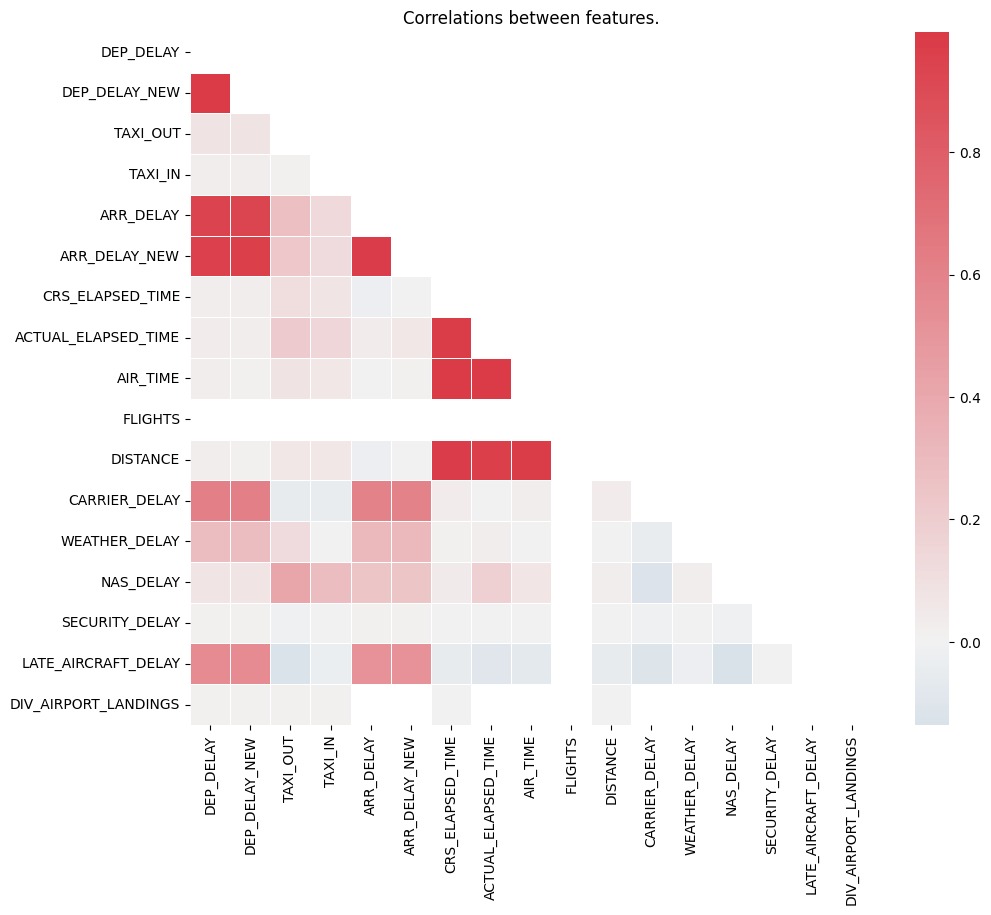

In [0]:
df_flights_num = df_flights_num.toPandas()

#get correlation matrix
matrix = df_flights_num.corr()
#plot correlation matrix
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(matrix, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between features.")
plt.show()

####Numeric Varaible Distribution Analysis

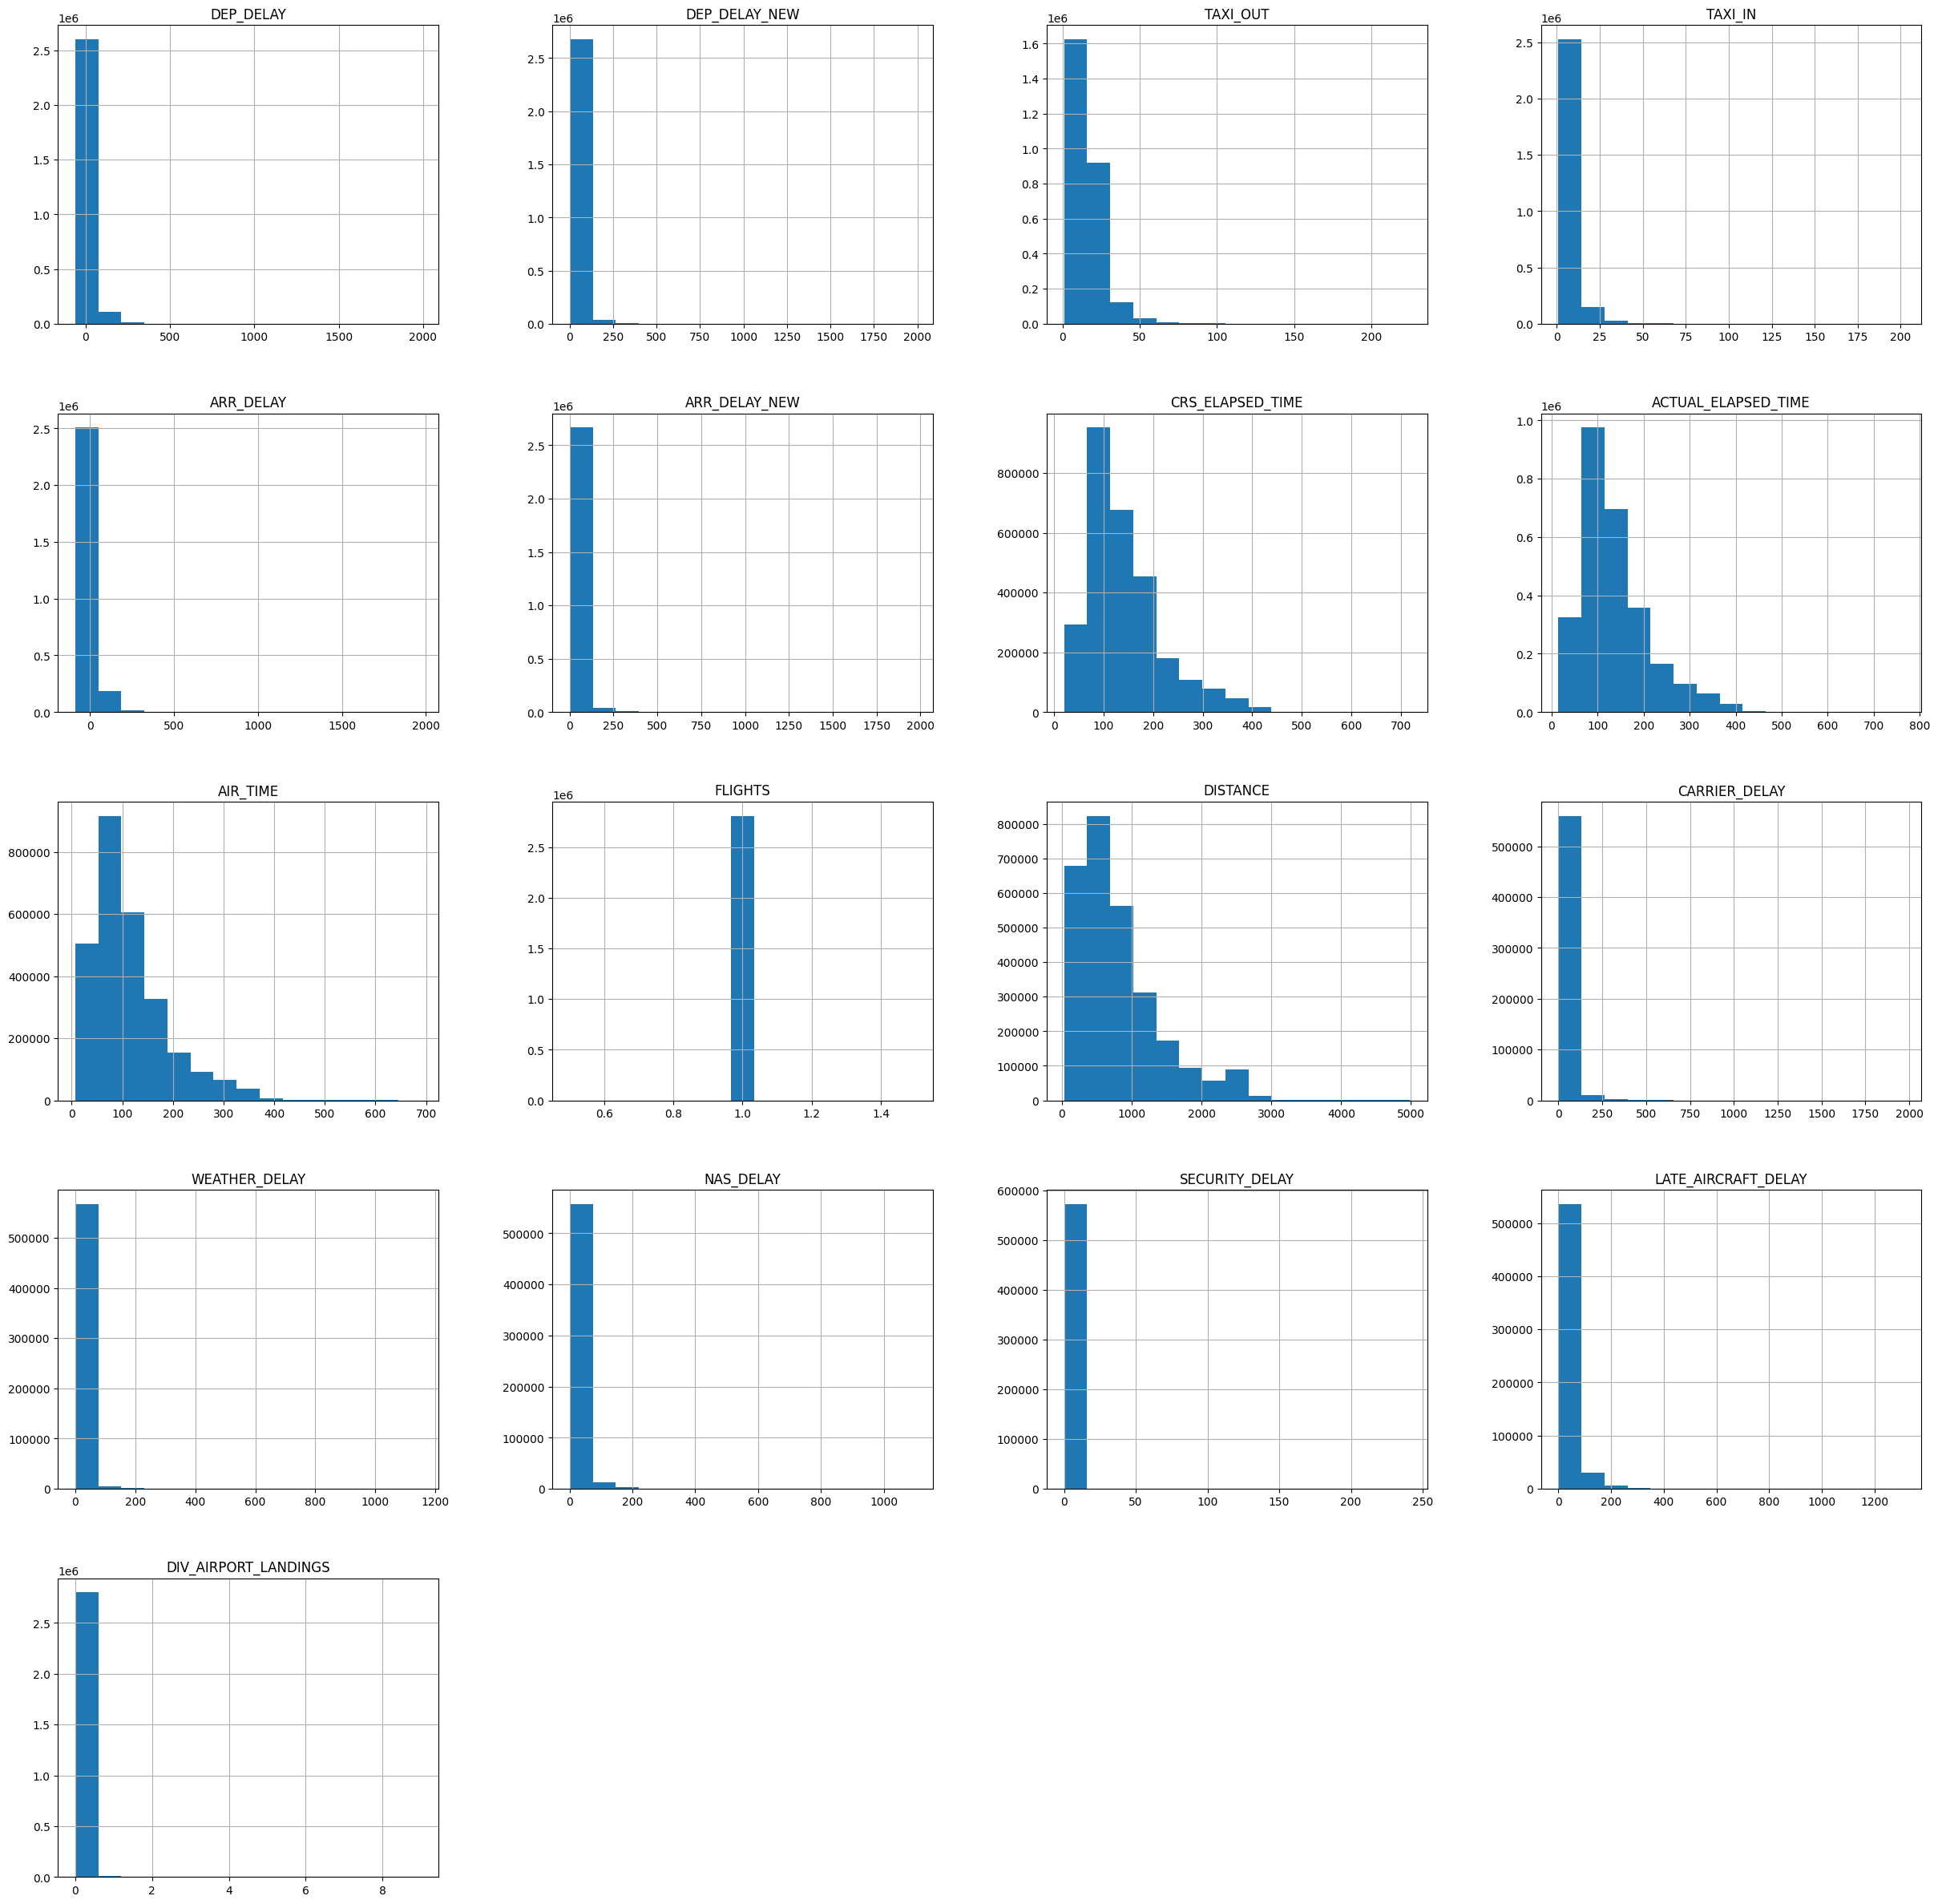

In [0]:
#plot numeric columns
df_flights_num.hist(figsize=(30,30), bins=15)
plt.show()

####Categorical Variables Distribution Analysis

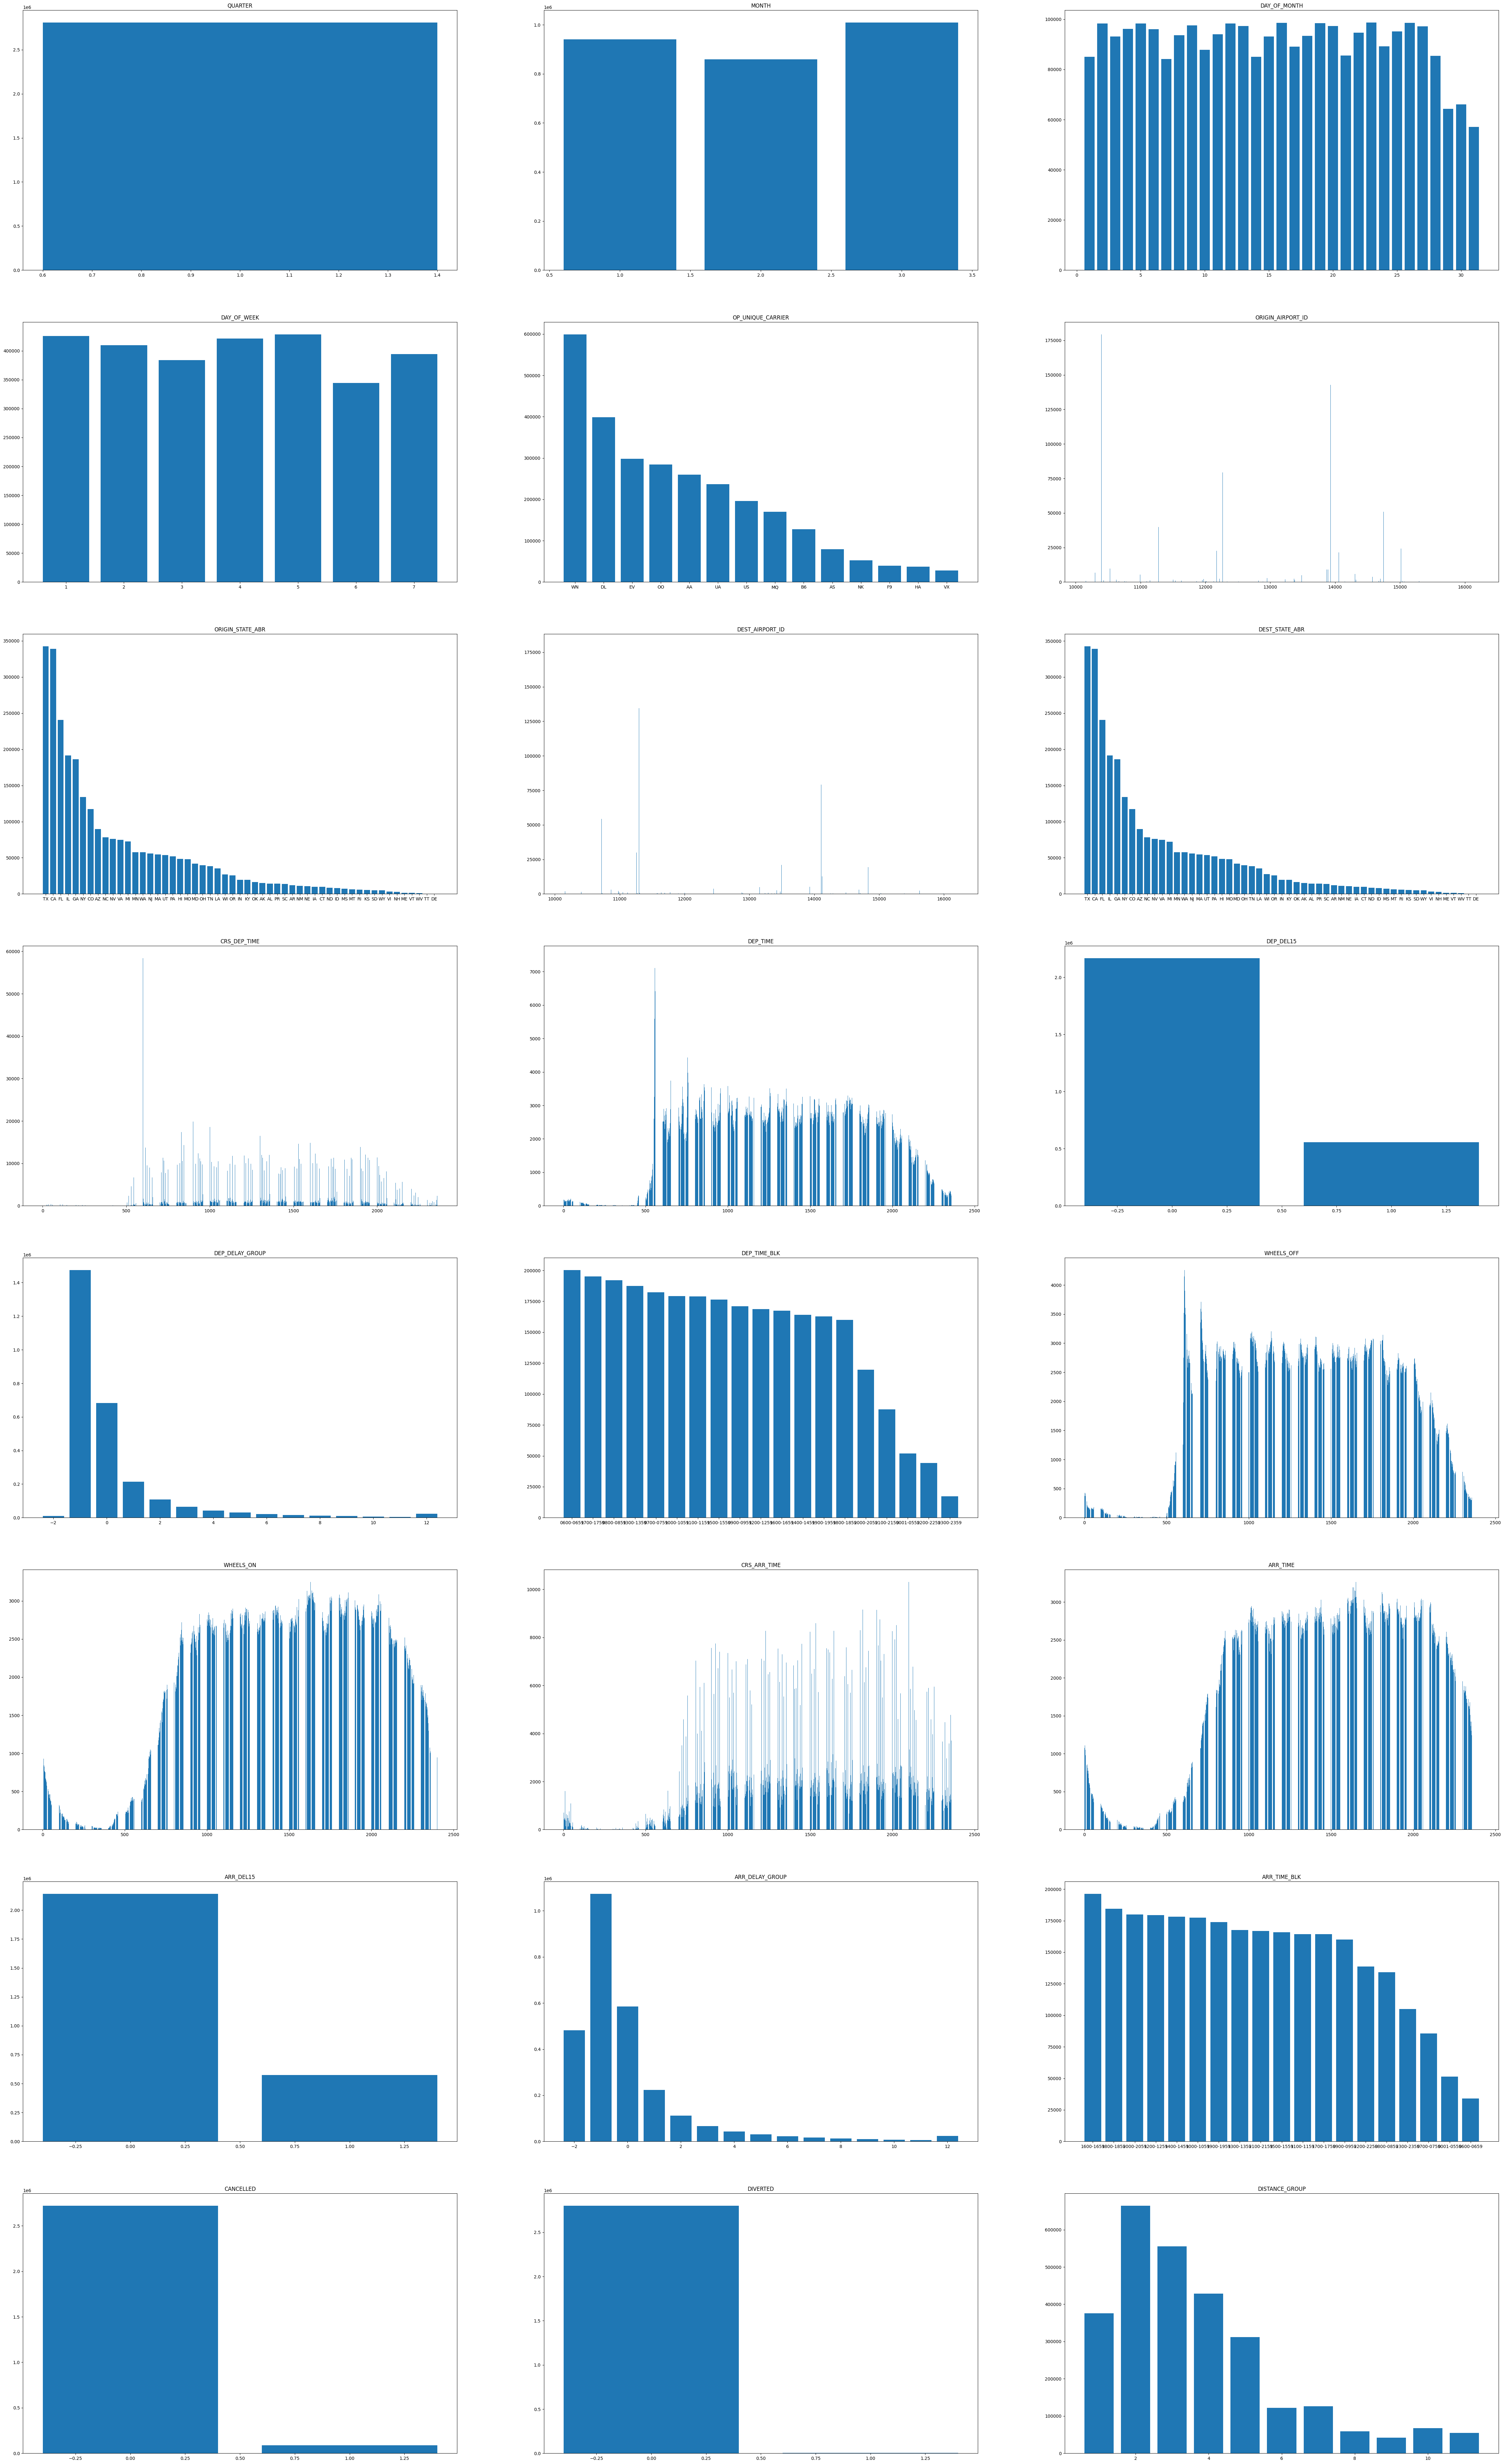

In [0]:
#extract categorical column dataframe
df_flights_categorical = df_flights.select([c for c in categorical_cols]).toPandas()

#plot categorical columns
fig, axis = plt.subplots(8, 3, figsize=(60, 100))
index = 0
for col in categorical_cols:
    if len(df_flights_categorical[col].value_counts()) != 0:
        axis[index//3][index%3].bar(df_flights_categorical[col].value_counts().index.values, df_flights_categorical[col].value_counts().values)
        axis[index//3][index%3].set_title(col)
        index += 1

plt.show()

##EDA: Weather Data
####As weather is known to impact flight schedules, this dataset contains weather conditions from the National Oceanic and Atmospheric Administration. It includes 124 features from 2015 to 2021. We will use this dataset along with the Flights Data to generate weather patterns at both departure and arrival points. This pattern is crucial for understanding the environmental factors affecting flight schedule.


####Dictionary

In [0]:
df_weather = spark.read.parquet(f"dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data_3m/")
display(df_weather.limit(10).toPandas())

STATION                 DATE  ... WindEquipmentChangeDate  YEAR
0  72751454910  2015-01-01T00:13:00  ...                    None  2015
1  72751454910  2015-01-01T00:34:00  ...                    None  2015
2  72751454910  2015-01-01T00:53:00  ...                    None  2015
3  72751454910  2015-01-01T01:13:00  ...                    None  2015
4  72751454910  2015-01-01T01:34:00  ...                    None  2015
5  72751454910  2015-01-01T01:53:00  ...                    None  2015
6  72751454910  2015-01-01T02:13:00  ...                    None  2015
7  72751454910  2015-01-01T02:34:00  ...                    None  2015
8  72751454910  2015-01-01T02:53:00  ...                    None  2015
9  72751454910  2015-01-01T03:13:00  ...                    None  2015

[10 rows x 124 columns]

In [0]:
weather_data_details = {
    'STATION': {'description': 'Identifier for the weather station. Value range: Numerical, typically an 11-digit field.', 'data_type': 'str'},
    'DATE': {'description': 'The date of observation. Value range: Format YYYYMMDD.', 'data_type': 'int'},
    'LATITUDE': {'description': 'The latitude coordinate of observation. Value range: -90000 to +90000 (scaled by 1000).', 'data_type': 'float'},
    'LONGITUDE': {'description': 'The longitude coordinate of observation. Value range: -179999 to +180000 (scaled by 1000).', 'data_type': 'float'},
    'ELEVATION': {'description': 'The elevation relative to Mean Sea Level (MSL). Value range: -0400 to +8850 meters.', 'data_type': 'float'},
    'NAME': {'description': 'Name of the observation station. Value range: Alphanumeric.', 'data_type': 'str'},
    'REPORT_TYPE': {'description': "Type of geophysical report. Possible values include various report codes like 'AERO', 'AUTO', 'BOGUS', etc.", 'data_type': 'str'},
    'SOURCE': {'description': "Source of the observation. Possible values range from 1 to 9 and A to N, representing different data sources.", 'data_type': 'str'},
    'HourlyAltimeterSetting': {'description': 'Atmospheric pressure adjusted to mean sea level. Value range: Typically in inches of mercury or hectopascals.', 'data_type': 'float'},
    'HourlyDewPointTemperature': {'description': 'Temperature to which air must be cooled to become saturated with water vapor. Value range: -0982 to +0368 (scaled by 10) in degrees Celsius.', 'data_type': 'float'},
    'HourlyDryBulbTemperature': {'description': 'Air temperature. Value range: -0932 to +0618 (scaled by 10) in degrees Celsius.', 'data_type': 'float'},
    'HourlyPrecipitation': {'description': 'Amount of precipitation. Value range: Typically 0000 to 9998 millimeters (scaled by 10).', 'data_type': 'float'},
    'HourlyPresentWeatherType': {'description': 'Type of present weather. Value range: Various weather condition codes.', 'data_type': 'str'},
    'HourlyPressureChange': {'description': 'Change in atmospheric pressure. Value range: Numerical indicating the pressure change.', 'data_type': 'float'},
    'HourlyPressureTendency': {'description': 'Tendency of atmospheric pressure. Value range: Numerical or categorical codes indicating rising or falling pressure.', 'data_type': 'str'},
    'HourlyRelativeHumidity': {'description': 'Amount of water vapor in the air. Value range: 0% to 100%.', 'data_type': 'int'},
    'HourlySkyConditions': {'description': 'Description of the sky condition. Value range: Various codes indicating cloud cover and sky conditions.', 'data_type': 'str'},
    'HourlySeaLevelPressure': {'description': 'Atmospheric pressure at sea level. Value range: Typically in millibars or hectopascals.', 'data_type': 'float'},
    'HourlyStationPressure': {'description': 'Atmospheric pressure at the station level. Value range: Typically in millibars or hectopascals.', 'data_type': 'float'},
    'HourlyVisibility': {'description': 'Distance at which objects can be clearly seen. Value range: Typically 000000 to 160000 meters.', 'data_type': 'float'},
    'HourlyWetBulbTemperature': {'description': 'The temperature a parcel of air would have if cooled adiabatically to saturation. Value range: -0932 to +0618 (scaled by 10) in degrees Celsius.', 'data_type': 'float'},
    'HourlyWindDirection': {'description': 'Direction from which the wind is blowing. Value range: 001 to 360 degrees.', 'data_type': 'int'},
    'HourlyWindGustSpeed': {'description': 'Speed of the wind gusts. Value range: Typically in meters per second.', 'data_type': 'float'},
    'HourlyWindSpeed': {'description': 'Speed of the wind. Value range: 0000 to 0900 (scaled by 10) in meters per second.', 'data_type': 'float'},
    'Sunrise': {'description': 'Time of sunrise. Value range: Time in HHMM format.', 'data_type': 'str'},
    'Sunset': {'description': 'Time of sunset. Value range: Time in HHMM format.', 'data_type': 'str'},
    'DailyAverageDewPointTemperature': {'description': 'Average dew point temperature for the day. Value range: Numerically in degrees, typically scaled.', 'data_type': 'float'},
    'DailyAverageDryBulbTemperature': {'description': 'Average dry bulb temperature for the day. Value range: Numerically in degrees, typically scaled.', 'data_type': 'float'},
    'DailyAverageRelativeHumidity': {'description': 'Average relative humidity for the day. Value range: 0% to 100%.', 'data_type': 'int'},
    'DailyAverageSeaLevelPressure': {'description': 'Average sea-level pressure for the day. Value range: Numerically in hectopascals or millibars.', 'data_type': 'float'},
    'DailyAverageStationPressure': {'description': 'Average station pressure for the day. Value range: Numerically in hectopascals or millibars.', 'data_type': 'float'},
    'DailyAverageWetBulbTemperature': {'description': 'Average wet bulb temperature for the day. Value range: Numerically in degrees, typically scaled.', 'data_type': 'float'},
    'DailyAverageWindSpeed': {'description': 'Average wind speed for the day. Value range: Numerically in meters per second or knots.', 'data_type': 'float'},
    'DailyCoolingDegreeDays': {'description': 'Cooling degree days for the day. Value range: Numerically, representing the difference in temperature below a base threshold.', 'data_type': 'int'},
    'DailyDepartureFromNormalAverageTemperature': {'description': 'Departure from normal average temperature for the day. Value range: Numerically in degrees, indicating deviation from historical norms.', 'data_type': 'float'},
    'DailyHeatingDegreeDays': {'description': 'Heating degree days for the day. Value range: Numerically, representing the difference in temperature above a base threshold.', 'data_type': 'int'},
    'DailyMaximumDryBulbTemperature': {'description': 'Maximum dry bulb temperature for the day. Value range: Numerically in degrees, typically scaled.', 'data_type': 'float'},
    'DailyMinimumDryBulbTemperature': {'description': 'Minimum dry bulb temperature for the day. Value range: Numerically in degrees, typically scaled.', 'data_type': 'float'},
    'DailyPeakWindDirection': {'description': 'Direction of peak wind for the day. Value range: 001 to 360 degrees.', 'data_type': 'int'},
    'DailyPeakWindSpeed': {'description': 'Speed of the peak wind for the day. Value range: Numerically in meters per second or knots.', 'data_type': 'float'},
    'DailyPrecipitation': {'description': 'Total precipitation for the day. Value range: Numerically in millimeters or inches.', 'data_type': 'float'},
    'DailySnowDepth': {'description': 'Snow depth for the day. Value range: Numerically in centimeters or inches.', 'data_type': 'float'},
    'DailySnowfall': {'description': 'Total snowfall for the day. Value range: Numerically in millimeters or inches.', 'data_type': 'float'},
    'DailySustainedWindDirection': {'description': 'Direction of sustained wind for the day. Value range: 001 to 360 degrees.', 'data_type': 'int'},
    'DailySustainedWindSpeed': {'description': 'Speed of the sustained wind for the day. Value range: Numerically in meters per second or knots.', 'data_type': 'float'},
    'DailyWeather': {'description': 'Weather conditions for the day. Value range: Various weather condition codes and descriptions.', 'data_type': 'str'},
    'MonthlyAverageRH': {'description': 'Average relative humidity for the month. Value range: 0% to 100%.', 'data_type': 'int'},
    'MonthlyDaysWithGT001Precip': {'description': 'Days with greater than 0.01 inches of precipitation in the month. Value range: 0 to 31 days.', 'data_type': 'int'},
    'MonthlyDaysWithGT010Precip': {'description': 'Days with greater than 0.10 inches of precipitation in the month. Value range: 0 to 31 days.', 'data_type': 'int'},
    'MonthlyDaysWithGT32Temp': {'description': 'Days with temperature greater than 32°F in the month. Value range: 0 to 31 days.', 'data_type': 'int'},
    'MonthlyDaysWithGT90Temp': {'description': 'Days with temperature greater than 90°F in the month. Value range: 0 to 31 days.', 'data_type': 'int'},
    'MonthlyDaysWithLT0Temp': {'description': 'Days with temperature less than 0°F in the month. Value range: 0 to 31 days.', 'data_type': 'int'},
    'MonthlyDaysWithLT32Temp': {'description': 'Days with temperature less than 32°F in the month. Value range: 0 to 31 days.', 'data_type': 'int'},
    'MonthlyDepartureFromNormalAverageTemperature': {'description': 'Departure from normal average temperature for the month. Value range: Numerically in degrees, indicating deviation from historical norms.', 'data_type': 'float'},
    'MonthlyDepartureFromNormalCoolingDegreeDays': {'description': 'Departure from normal cooling degree days for the month. Value range: Numerically, indicating deviation from normal values.', 'data_type': 'int'},
    'MonthlyDepartureFromNormalHeatingDegreeDays': {'description': 'Departure from normal heating degree days for the month. Value range: Numerically, indicating deviation from normal values.', 'data_type': 'int'},
    'MonthlyDepartureFromNormalMaximumTemperature': {'description': 'Departure from the normal maximum temperature for the month. Value range: Numerically in degrees, indicating deviation from historical norms.', 'data_type': 'float'},
    'MonthlyDepartureFromNormalMinimumTemperature': {'description': 'Departure from the normal minimum temperature for the month. Value range: Numerically in degrees, indicating deviation from historical norms.', 'data_type': 'float'},
    'MonthlyDepartureFromNormalPrecipitation': {'description': 'Departure from normal precipitation for the month. Value range: Numerically in millimeters or inches, indicating deviation from historical norms.', 'data_type': 'float'},
    'MonthlyDewpointTemperature': {'description': 'Average dewpoint temperature for the month. Value range: Numerically in degrees, typically scaled.', 'data_type': 'float'},
    'MonthlyGreatestPrecip': {'description': 'Greatest amount of precipitation recorded in a single day during the month. Value range: Numerically in millimeters or inches.', 'data_type': 'float'},
    'MonthlyGreatestPrecipDate': {'description': 'Date of the greatest precipitation in the month. Value range: Dates formatted as YYYYMMDD.', 'data_type': 'int'},
    'MonthlyGreatestSnowDepth': {'description': 'Greatest snow depth recorded during the month. Value range: Numerically in centimeters or inches.', 'data_type': 'float'},
    'MonthlyGreatestSnowDepthDate': {'description': 'Date of the greatest snow depth in the month. Value range: Dates formatted as YYYYMMDD.', 'data_type': 'int'},
    'MonthlyGreatestSnowfall': {'description': 'Greatest amount of snowfall recorded in a single day during the month. Value range: Numerically in millimeters or inches.', 'data_type': 'float'},
    'MonthlyGreatestSnowfallDate': {'description': 'Date of the greatest snowfall in the month. Value range: Dates formatted as YYYYMMDD.', 'data_type': 'int'},
    'MonthlyMaxSeaLevelPressureValue': {'description': 'Maximum sea-level pressure recorded during the month. Value range: Numerically in hectopascals or millibars.', 'data_type': 'float'},
    'MonthlyMaxSeaLevelPressureValueDate': {'description': 'Date of the maximum sea-level pressure in the month. Value range: Dates formatted as YYYYMMDD.', 'data_type': 'int'},
    'MonthlyMaxSeaLevelPressureValueTime': {'description': 'Time of the maximum sea-level pressure recorded during the month. Value range: Time in HHMM format.', 'data_type': 'str'},
    'MonthlyMaximumTemperature': {'description': 'Maximum temperature recorded during the month. Value range: Numerically in degrees, typically scaled.', 'data_type': 'float'},
    'MonthlyMeanTemperature': {'description': 'Mean temperature for the month. Value range: Numerically in degrees, typically scaled.', 'data_type': 'float'},
    'MonthlyMinSeaLevelPressureValue': {'description': 'Minimum sea-level pressure recorded during the month. Value range: Numerically in hectopascals or millibars.', 'data_type': 'float'},
    'MonthlyMinSeaLevelPressureValueDate': {'description': 'Date of the minimum sea-level pressure in the month. Value range: Dates formatted as YYYYMMDD.', 'data_type': 'int'},
    'MonthlyMinSeaLevelPressureValueTime': {'description': 'Time of the minimum sea-level pressure recorded during the month. Value range: Time in HHMM format.', 'data_type': 'str'},
    'MonthlyMinimumTemperature': {'description': 'Minimum temperature recorded during the month. Value range: Numerically in degrees, typically scaled.', 'data_type': 'float'},
    'MonthlySeaLevelPressure': {'description': 'Average sea-level pressure for the month. Value range: Numerically in hectopascals or millibars.', 'data_type': 'float'},
    'MonthlyStationPressure': {'description': 'Average station pressure for the month. Value range: Numerically in hectopascals or millibars.', 'data_type': 'float'},
    'MonthlyTotalLiquidPrecipitation': {'description': 'Total liquid precipitation for the month. Value range: Numerically in millimeters or inches.', 'data_type': 'float'},
    'MonthlyTotalSnowfall': {'description': 'Total snowfall for the month. Value range: Numerically in millimeters or inches.', 'data_type': 'float'},
    'MonthlyWetBulb': {'description': 'Average wet bulb temperature for the month. Value range: Numerically in degrees, typically scaled.', 'data_type': 'float'},
    'AWND': {'description': 'Average wind speed. Value range: Numerically in meters per second or knots.', 'data_type': 'float'},
    'CDSD': {'description': 'Cooling degree days season-to-date. Value range: Numerically, representing the accumulation of degrees over a season.', 'data_type': 'int'},
    'CLDD': {'description': 'Cooling degree days. Value range: Numerically, representing the difference in temperature below a base threshold.', 'data_type': 'int'},
    'DSNW': {'description': 'Days with snow. Value range: 0 to 31 days, indicating the number of days in the month with snowfall.', 'data_type': 'int'},
    'HDSD': {'description': 'Heating degree days season-to-date. Value range: Numerically, representing the accumulation of degrees over a season.', 'data_type': 'int'},
    'HTDD': {'description': 'Heating degree days. Value range: Numerically, representing the difference in temperature above a base threshold.', 'data_type': 'int'},
    'NormalsCoolingDegreeDay': {'description': 'Normal cooling degree days, typically based on a 30-year average. Value range: Numerically representing the average number of cooling degree days.', 'data_type': 'int'},
    'NormalsHeatingDegreeDay': {'description': 'Normal heating degree days, often based on a historical 30-year average. Value range: Numerically representing the average number of heating degree days.', 'data_type': 'int'},
    'ShortDurationEndDate005 - ShortDurationEndDate180': {'description': 'Ending dates for precipitation events of specified short durations ranging from 5 to 180 minutes. Value range: Dates formatted as YYYYMMDD or HHMM for time-specific end points.', 'data_type': 'str/int'},
    'ShortDurationPrecipitationValue005 - ShortDurationPrecipitationValue180': {'description': 'Amount of precipitation recorded during the specified short duration periods ranging from 5 to 180 minutes. Value range: Numerically in millimeters or inches.', 'data_type': 'float'},
    'REM': {'description': 'Remarks section, which may include additional information or context about the observation. Value range: Textual data, potentially including coded information.', 'data_type': 'str'},
    'BackupDirection': {'description': 'The direction from which a backup observation was taken. Value range: 001 to 360 degrees.', 'data_type': 'int'},
    'BackupDistance': {'description': 'The distance to the backup observation location. Value range: Numerically in units specified by the BackupDistanceUnit.', 'data_type': 'float'},
    'BackupDistanceUnit': {'description': 'The unit of measure for the BackupDistance. Possible values: Kilometers, miles, etc.', 'data_type': 'str'},
    'BackupElements': {'description': 'Elements that are included in the backup observation. Value range: Coded values representing different meteorological elements.', 'data_type': 'str'},
    'BackupElevation': {'description': 'The elevation of the backup observation location. Value range: Numerically in meters or feet.', 'data_type': 'float'},
    'BackupEquipment': {'description': 'Equipment used for the backup observation. Value range: Textual description or codes representing different equipment types.', 'data_type': 'str'},
    'BackupLatitude': {'description': 'The latitude of the backup observation location. Value range: Numerically, -90 to +90 degrees.', 'data_type': 'float'},
    'BackupLongitude': {'description': 'The longitude of the backup observation location. Value range: Numerically, -180 to +180 degrees.', 'data_type': 'float'},
    'BackupName': {'description': 'The name of the backup observation location. Value range: Textual data.', 'data_type': 'str'},
    'WindEquipmentChangeDate': {'description': 'Date when the wind observation equipment was changed. Value range: Dates formatted as YYYYMMDD.', 'data_type': 'str'},
    'YEAR': {'description': 'The year of the observation. Value range: Four-digit year, YYYY format.', 'data_type': 'int'}
}

df = pd.DataFrame.from_dict(weather_data_details, orient='index').reset_index()
df.columns = ['Column Name', 'Description', 'Data Type']
display(df)



Column Name  ... Data Type
0                    STATION  ...       str
1                       DATE  ...       int
2                   LATITUDE  ...     float
3                  LONGITUDE  ...     float
4                  ELEVATION  ...     float
..                       ...  ...       ...
97            BackupLatitude  ...     float
98           BackupLongitude  ...     float
99                BackupName  ...       str
100  WindEquipmentChangeDate  ...       str
101                     YEAR  ...       int

[102 rows x 3 columns]

####Dataset Size

In [0]:
print("The Weather 3 Months Dataset has " + str(df_weather.count()) + " rows and " + str(len(df_weather.columns)) + " columns")

The Weather 3 Months Dataset has 30528602 rows and 124 columns


####Missing Value Analysis

In [0]:
#counting null values in each column for weather spark dataframes 
weather_null_dataframe =  df_weather.select([F.count(F.when(F.col(c).isNull(),c)).alias(c) for c in df_weather.columns])

#row count in each dataframe
row_count_weather = df_weather.count()

#to pandas for analysis and viz
weather_null_count_pandas = weather_null_dataframe.toPandas().transpose().reset_index().rename(columns = {0:'nullCount'})

#create percent_null column 
weather_null_count_pandas['percentNull'] = np.round(weather_null_count_pandas['nullCount'] * 100 / row_count_weather , 2)

#column names with acceptable percent null values 
nonnull_cols_weather = weather_null_count_pandas[weather_null_count_pandas['percentNull'] < 7]['index'].to_list()

#null count percent by column in 3month weather dataset
weather_null_fig = px.scatter(weather_null_count_pandas, x = 'index', y= 'percentNull', title = 'Null Percentage by Column - Weather',
                              color = 'percentNull', color_continuous_scale='bluered')
weather_null_fig.update_layout(title_x = 0.5, height = 400, xaxis={'categoryorder':'total ascending'})
weather_null_fig.update_xaxes(title = 'Column Name', visible = False)
weather_null_fig.update_yaxes(title = 'Percent Null')

display(weather_null_fig)

#drop columns with over 95% null values
weather_null_count_pandas = weather_null_count_pandas[weather_null_count_pandas['percentNull'] > 95]
df_weather = df_weather.drop(*weather_null_count_pandas['index'].values)

####Summary Statistics

In [0]:
#categorical columns
weather_categorical_cols = ["STATION", "NAME", "DATE", "YEAR", "REPORT_TYPE", "SOURCE","HourlySkyConditions", "HourlyPresentWeatherType", "DailyWeather", "BackupDirection", "BackupDistanceUnit", "BackupName", "REM", "Sunrise", "Sunset", "MonthlyGreatestSnowDepthDate", "MonthlyGreatestSnowfallDate", "MonthlyMaxSeaLevelPressureValueDate", "MonthlyMaxSeaLevelPressureValueTime", "MonthlyMinSeaLevelPressureValueDate", "ShortDurationEndDate005", "ShortDurationEndDate010", "ShortDurationEndDate015", "ShortDurationEndDate020", "ShortDurationEndDate030", "ShortDurationEndDate045", "ShortDurationEndDate060", "ShortDurationEndDate080", "ShortDurationEndDate100", "ShortDurationEndDate120", "ShortDurationEndDate150", "ShortDurationEndDate180", "WindEquipmentChangeDate"]
weather_categorical_cols = [c for c in weather_categorical_cols if c not in weather_null_count_pandas['index'].values]

weather_list_cols = ["BackupElements", "BackupEquipment"]

#numeric columns
weather_numeric_cols = [c for c in df_weather.columns if (c not in weather_categorical_cols and c not in weather_list_cols and c not in weather_null_count_pandas['index'].values)]

weather_categorical_cols.remove('REM')

#extract numeric column dataframe
df_weather_num = df_weather.select([c for c in weather_numeric_cols])
df_weather_num = df_weather_num.select([F.col(c).cast('double') for c in df_weather_num.columns])

#calculate summary statistics for numeric columns
display(df_weather_num.describe().toPandas())

summary           LATITUDE  ... HourlyWindGustSpeed    HourlyWindSpeed
0   count           30287448  ...             2173822           26481739
1    mean  37.86678014434934  ...  25.724987142461526  8.241363076646893
2  stddev  21.30808618374516  ...   8.044946742515856  8.528749162043562
3     min              -90.0  ...                11.0                0.0
4     max              83.65  ...               113.0             2237.0

[5 rows x 18 columns]

####Correlation Analysis

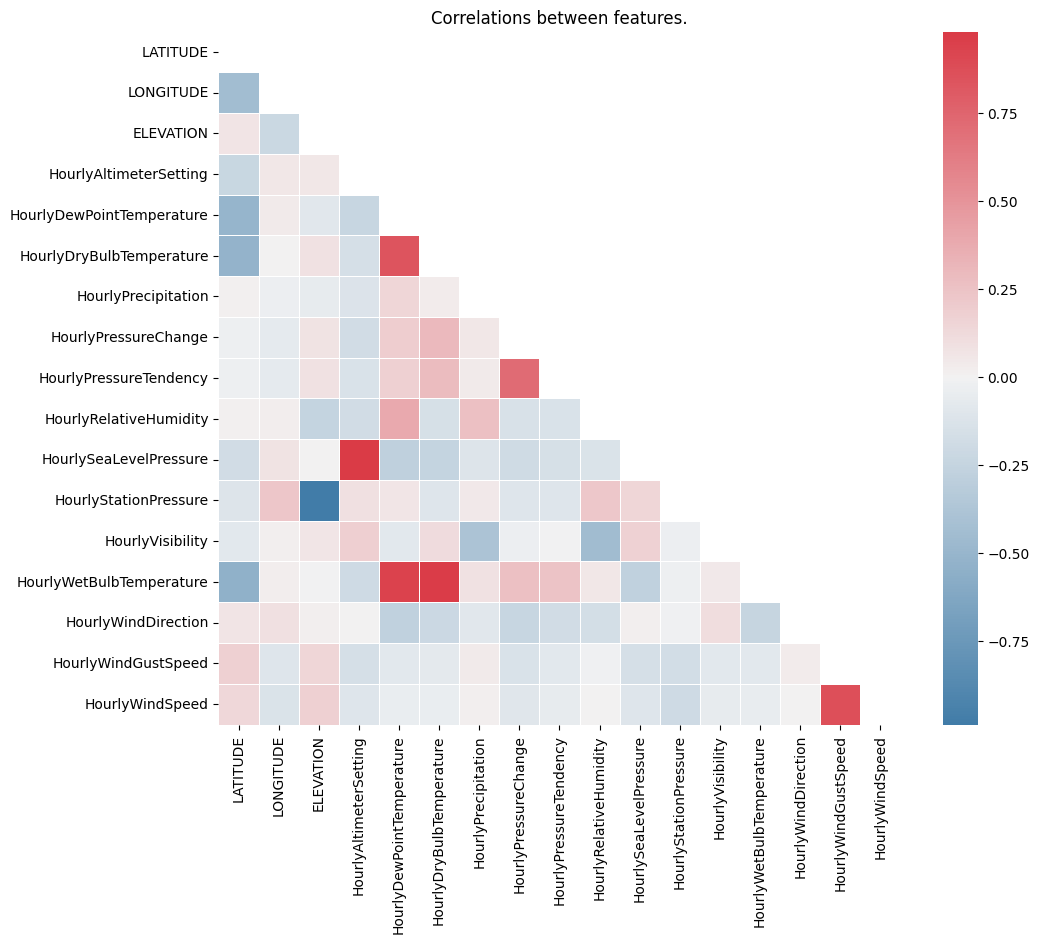

In [0]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols = df_weather_num.columns, outputCol=vector_col, handleInvalid="skip")
df_vector = assembler.transform(df_weather_num).select(vector_col)

#get correlation matrix
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0] 
corr_matrix = matrix.toArray().tolist() 
corr_matrix_df = pd.DataFrame(data = corr_matrix, columns = df_weather_num.columns, index = df_weather_num.columns)

#plot correlation matrix
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr_matrix_df, dtype = bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap = True)
sns.heatmap(corr_matrix_df, mask = mask, cmap = cmap, center = 0, linewidths = 0.5)
plt.title("Correlations between features.")
plt.show()

####Numeric Variable Distribution Analysis

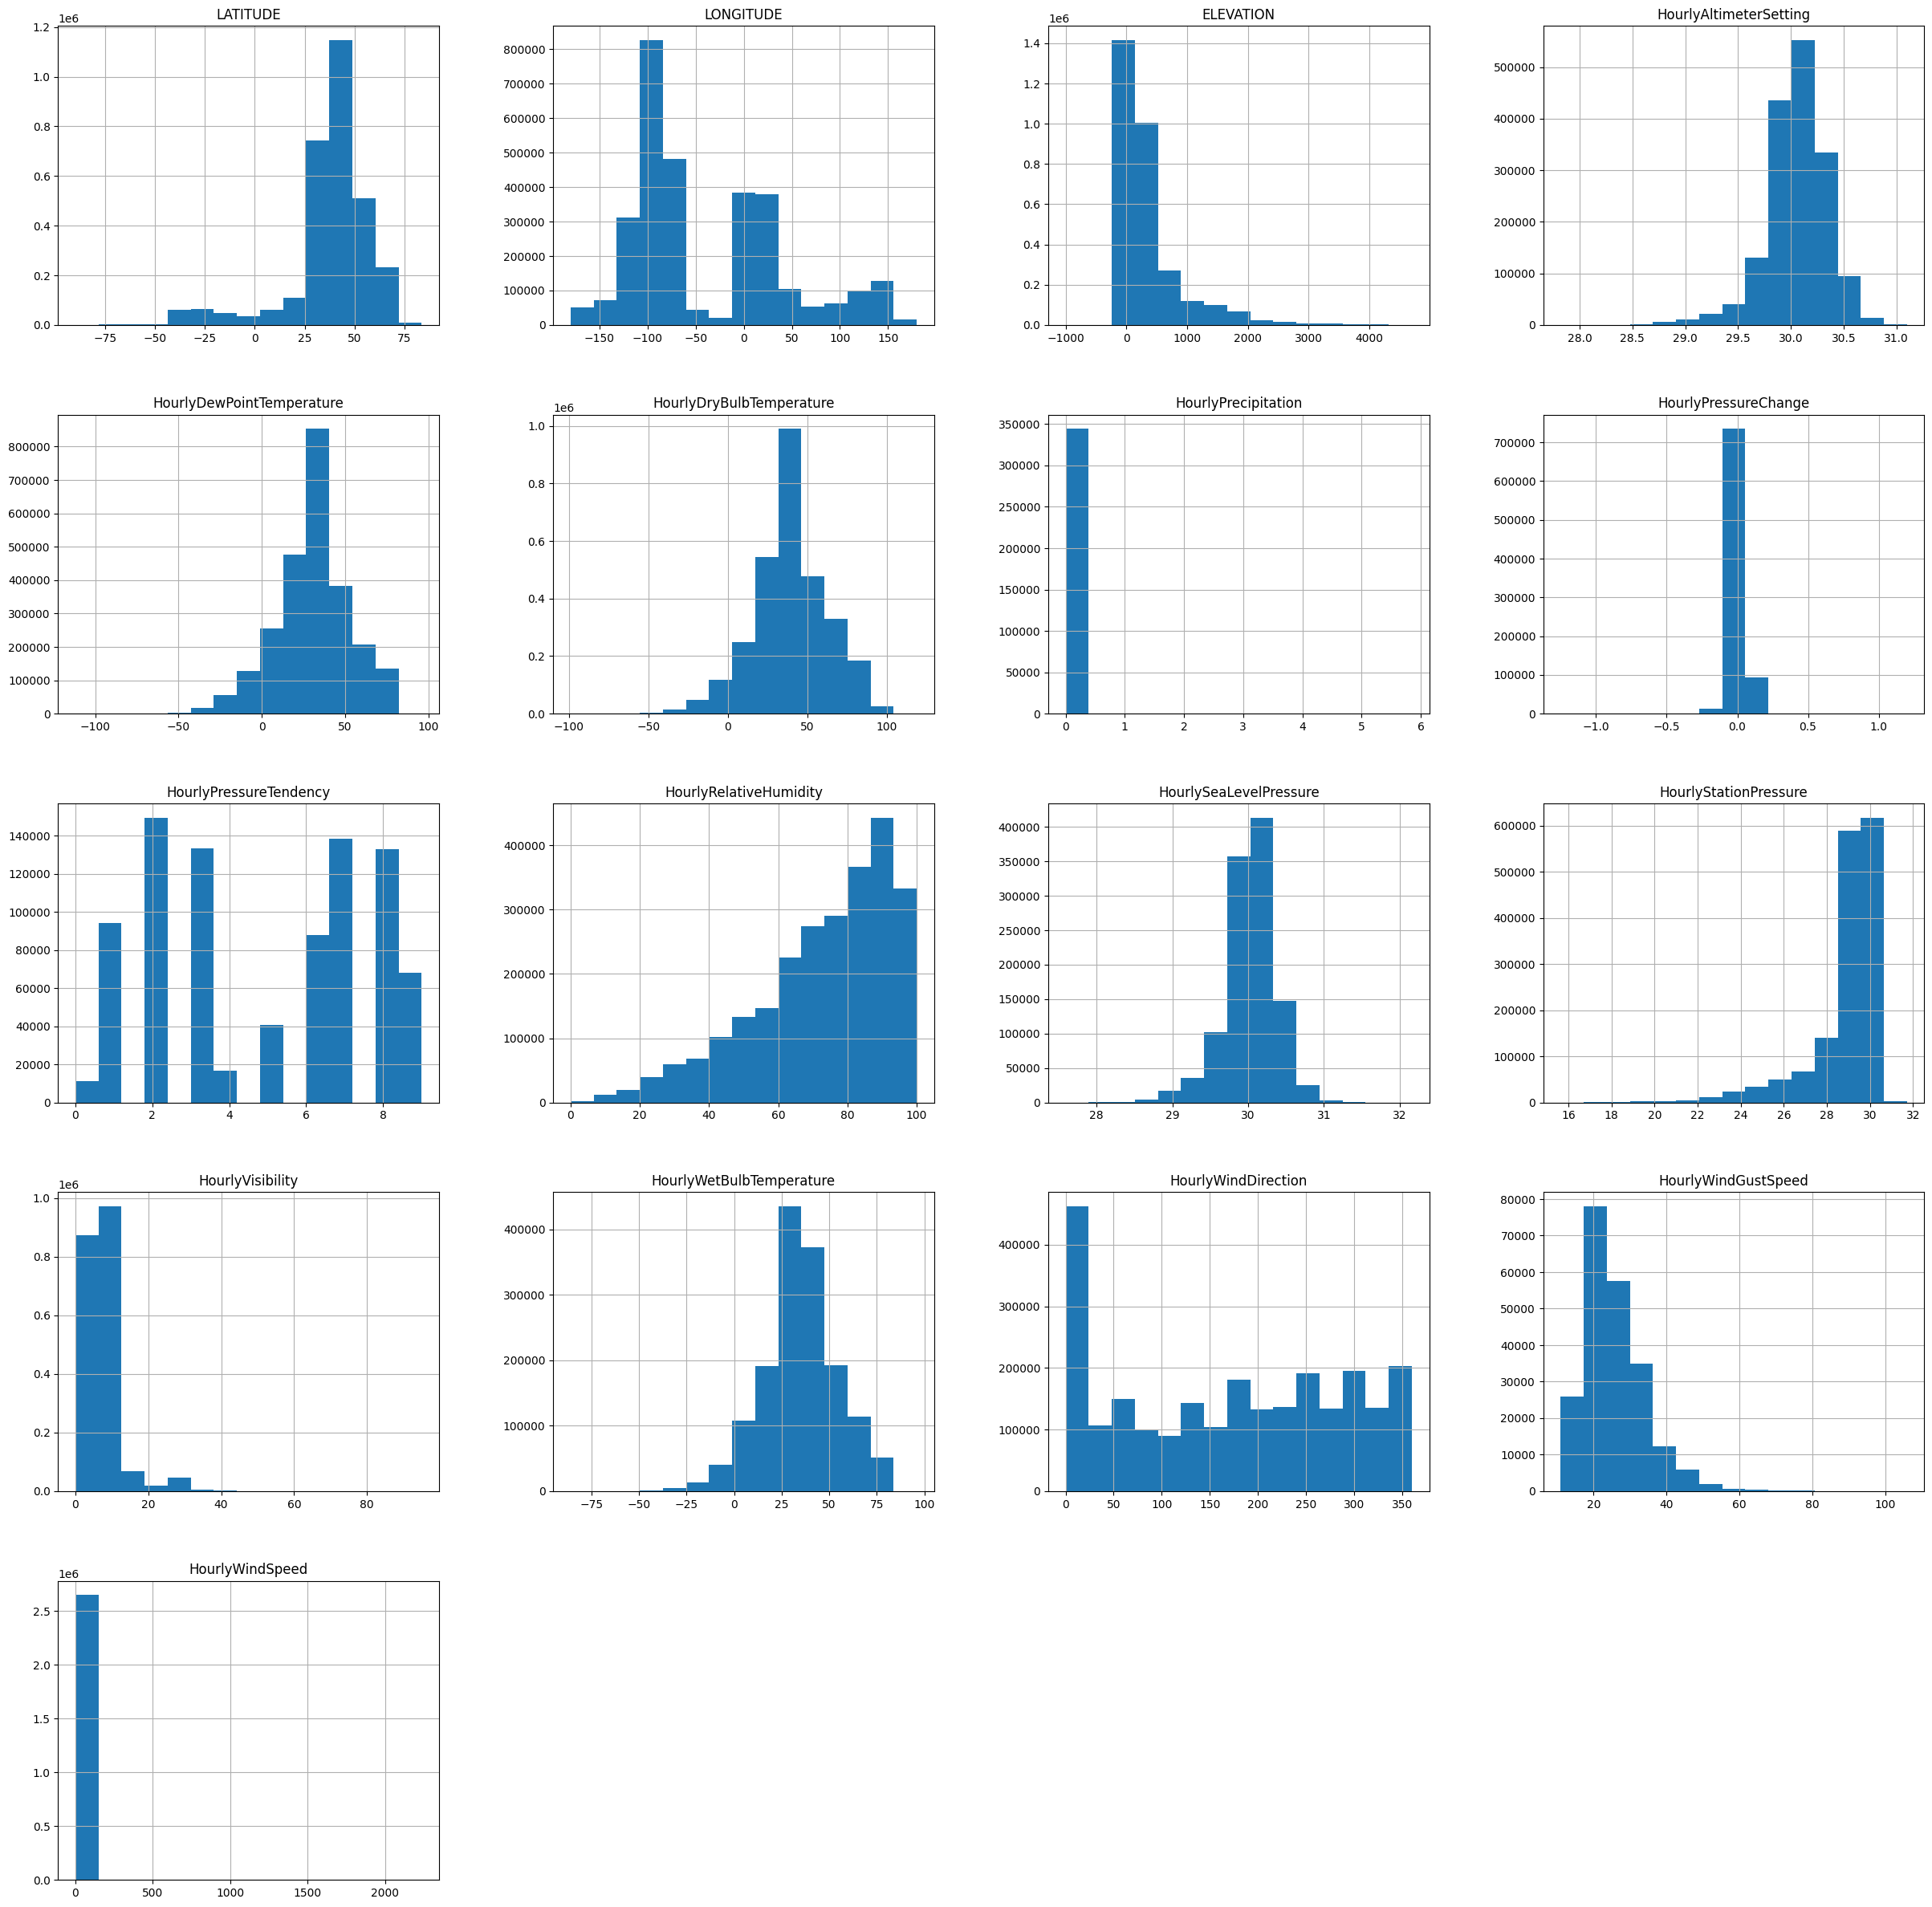

In [0]:
df_weather_num = df_weather_num.sample(0.1, 0).toPandas()

#plot numeric features
df_weather_num.hist(figsize=(30,30), bins=15)
plt.show()

####Categorical Variables Unique Values Analysis

In [0]:
#get categorical column dataframe
df_weather_categorical = df_weather.select([c for c in weather_categorical_cols]).sample(0.1, 0).toPandas()
display(df_weather_categorical.head(10))

STATION         NAME  ... HourlyPresentWeatherType  WindEquipmentChangeDate
0  52652099999  ZHANGYE, CH  ...                     None                     None
1  52652099999  ZHANGYE, CH  ...                     None                     None
2  52652099999  ZHANGYE, CH  ...                     None                     None
3  52652099999  ZHANGYE, CH  ...                     None                     None
4  52652099999  ZHANGYE, CH  ...                     None                     None
5  52652099999  ZHANGYE, CH  ...                     None                     None
6  52652099999  ZHANGYE, CH  ...                     None                     None
7  52652099999  ZHANGYE, CH  ...                     None                     None
8  52652099999  ZHANGYE, CH  ...                     None                     None
9  52652099999  ZHANGYE, CH  ...                     None                     None

[10 rows x 9 columns]

In [0]:
#print unique values for categorical columns
for col in weather_categorical_cols:
    print('------------------------------------------')
    print(col)
    display(df_weather_categorical[col].value_counts())


------------------------------------------
STATION


99999953155    2777
99999994077    2722
99999904139    2708
99999963897    2689
99999963838    2686
               ... 
95953099999       1
94709099999       1
68006599999       1
67221099999       1
67403099999       1
Name: STATION, Length: 12398, dtype: int64

------------------------------------------
NAME


WILLIAMS 35 NNW, AZ US               2777
HARRISON 20 SSE, NE US               2722
DENIO 52 WSW, NV US                  2708
SELMA 6 SSE, AL US                   2689
VERSAILLES 3 NNW, KY US              2686
                                     ... 
JIJEL PORT, AG                          1
UIS, WA                                 1
ORANGE AGRICULTURAL INSTITUTE, AS       1
LUBUMBASHI INTERNATIONAL, CG            1
PALMAS AERO, BR                         1
Name: NAME, Length: 12217, dtype: int64

------------------------------------------
DATE


2015-02-03T08:00:00    744
2015-03-16T17:00:00    744
2015-02-25T11:00:00    734
2015-03-19T11:00:00    726
2015-01-27T08:00:00    726
                      ... 
2015-02-13T17:12:00      1
2015-02-13T11:12:00      1
2015-02-12T14:12:00      1
2015-02-11T21:12:00      1
2015-02-10T23:17:00      1
Name: DATE, Length: 110270, dtype: int64

------------------------------------------
YEAR


2015    3053959
Name: YEAR, dtype: int64

------------------------------------------
REPORT_TYPE


FM-15    1529924
FM-12     784866
CRN05     387582
FM-16     128915
SAO       110612
FM-13      87641
SOD        15092
SHEF        7392
SURF        1317
SOM          346
FM-14        239
SY-MT         33
Name: REPORT_TYPE, dtype: int64

------------------------------------------
SOURCE


4    1740214
7     848774
I     388996
6      69573
O       4665
K       1317
8        399
1         21
Name: SOURCE, dtype: int64

------------------------------------------
HourlySkyConditions


CLR:00                             401132
OVC:08 15                           14861
OVC:08 5                            14780
OVC:08 3                            14673
OVC:08 2                            14535
                                    ...  
FEW:02 16 SCT:04 40 SCT:04 150          1
FEW:02 16 FEW:02 30 SCT:04 80           1
FEW:02 15 FEW:02 30 SCT:04 100          1
FEW:02 16 FEW:02 100 BKN:07 150         1
BKN:07 42 BKN:07 46                     1
Name: HourlySkyConditions, Length: 141291, dtype: int64

------------------------------------------
HourlyPresentWeatherType


BR:1 ||                         52841
||RA                            35339
|SN |                           35127
-SN:03 |SN |                    30669
||HZ                            25123
                                ...  
||DU SG                             1
+PL:06 |PL |                        1
|SN PL |                            1
TS:7 +RA:02 GR:07 |RA TS |SH        1
-DZ:01 VCTS:7 |DZ |                 1
Name: HourlyPresentWeatherType, Length: 713, dtype: int64

------------------------------------------
WindEquipmentChangeDate


2005-11-07    7114
2005-10-27    5564
2005-10-20    4667
2005-11-17    3938
2007-03-20    2475
              ... 
2007-06-08     220
2009-03-25     219
2008-07-10     217
2007-09-20     211
2009-09-09     208
Name: WindEquipmentChangeDate, Length: 293, dtype: int64

##EDA: Station Data
####This dataset provides metadata about stations. It includes key details about each station, facilitating a deeper understanding of how specific stations' characteristics might influence flight delays.


####Dictionary

In [0]:
df_station = spark.read.parquet(f"dbfs:/mnt/mids-w261/datasets_final_project_2022/stations_data/stations_with_neighbors.parquet/")
display(df_station.limit(10).toPandas())

usaf   wban   station_id  ...  neighbor_lat  neighbor_lon distance_to_neighbor
0  690020  93218  69002093218  ...        36.000      -121.233             0.000000
1  690020  93218  69002093218  ...        36.683      -121.767            55.730245
2  690020  93218  69002093218  ...        33.667      -117.733           255.491062
3  690020  93218  69002093218  ...        71.333      -156.650          2750.435330
4  690020  93218  69002093218  ...        70.917      -153.250          2676.355437
5  690020  93218  69002093218  ...        70.500      -149.883          2604.050249
6  690020  93218  69002093218  ...        68.479      -149.490          2490.975609
7  690020  93218  69002093218  ...        70.250      -148.333          2568.180282
8  690020  93218  69002093218  ...        65.567      -144.765          2254.558489
9  690020  93218  69002093218  ...        66.250      -166.089          2743.688183

[10 rows x 12 columns]

In [0]:
station_data_details = {
    'usaf': {'description': 'Identifier code for the station used by US Air Force', 'data_type': 'string'},
    'wban': {'description': 'Identifier code for the station used by Weather-Bureau-Army-Navy', 'data_type': 'string'},
    'station_id': {'description': 'Identifier code for the station', 'data_type': 'string'},
    'lat': {'description': 'Latitude of the station', 'data_type': 'double'},
    'lon': {'description': 'Longitude of the station', 'data_type': 'double'},
    'neighbor_id': {'description': 'Neighboring Station Identifier', 'data_type': 'string'},
    'neighbor_name': {'description': 'Neighboring Station Name', 'data_type': 'string'},
    'neighbor_state': {'description': 'Neighboring Station State', 'data_type': 'string'},
    'neighbor_call': {'description': 'Neighboring Station Call Name', 'data_type': 'string'},
    'neighbor_lat': {'description': 'Neighboring Station Latitude', 'data_type': 'double'},
    'neighbor_lon': {'description': 'Neighboring Station Longitude', 'data_type': 'double'},
    'distance_to_neighbor': {'description': 'Neighboring Station Distance', 'data_type': 'double'}
}

df = pd.DataFrame.from_dict(station_data_details, orient='index').reset_index()
df.columns = ['Column Name', 'Description', 'Data Type']
display(df)


Column Name  ... Data Type
0                   usaf  ...    string
1                   wban  ...    string
2             station_id  ...    string
3                    lat  ...    double
4                    lon  ...    double
5            neighbor_id  ...    string
6          neighbor_name  ...    string
7         neighbor_state  ...    string
8          neighbor_call  ...    string
9           neighbor_lat  ...    double
10          neighbor_lon  ...    double
11  distance_to_neighbor  ...    double

[12 rows x 3 columns]

####Dataset Size

In [0]:
print("The Statio  Dataset has " + str(df_station.count()) + " rows and " + str(len(df_station.columns)) + " columns")

The Statio  Dataset has 5004169 rows and 12 columns


####Missing Value Analysis

In [0]:
#counting null values in each column for station spark dataframes 
station_null_dataframe =  df_station.select([F.count(F.when(F.col(c).isNull(),c)).alias(c) for c in df_station.columns])

#row count in each dataframe
row_count_station = df_station.count()

#to pandas for analysis and viz
station_null_count_pandas = station_null_dataframe.toPandas().transpose().reset_index().rename(columns = {0:'nullCount'})

#create percent_null column 
station_null_count_pandas['percentNull'] = np.round(station_null_count_pandas['nullCount'] * 100 / row_count_station , 2)

#column names with acceptable percent null values 
nonnull_cols_station = station_null_count_pandas[station_null_count_pandas['percentNull'] < 7]['index'].to_list()

#null count percent by column in stationr dataset
station_null_fig = px.scatter(station_null_count_pandas, x = 'index', y= 'percentNull', title = 'Null Percentage by Column - station',
                              color = 'percentNull', color_continuous_scale='bluered')
station_null_fig.update_layout(title_x = 0.5, height = 400, xaxis={'categoryorder':'total ascending'})
station_null_fig.update_xaxes(title = 'Column Name', visible = False)
station_null_fig.update_yaxes(title = 'Percent Null')

display(station_null_fig)

#drop columns with over 95% null values
station_null_count_pandas = station_null_count_pandas[station_null_count_pandas['percentNull'] > 95]
df_station = df_station.drop(*station_null_count_pandas['index'].values)


####Unique Station Analysis

In [0]:
#extract the number of unique stations
station_info = ["usaf", "wban", "station_id", "lat", "lon"]
display(df_station.select(*station_info).distinct())

DataFrame[usaf: string, wban: string, station_id: string, lat: double, lon: double]

####Unique Neighbors Anaylsis

In [0]:
#extract the number of unique neighboring stations
neighbor_info = ["neighbor_id", "neighbor_name", "neighbor_state", "neighbor_call", "neighbor_lat", "neighbor_lon"]
display(df_station.select(*neighbor_info).distinct())

DataFrame[neighbor_id: string, neighbor_name: string, neighbor_state: string, neighbor_call: string, neighbor_lat: double, neighbor_lon: double]

In [0]:
#count the number of unique neighboring stations of each station id
station_neighbors = df_station.groupBy('station_id').agg(
    F.count(F.col('neighbor_id')).alias('count_unique_neighbors'),
    F.count(F.col('neighbor_lat')).alias('count_unique_neighbors_lat'),
    F.count(F.col('neighbor_lon')).alias('count_unique_neighbors_lon'),
    F.count(F.col('distance_to_neighbor')).alias('count_unique_neighbors_distance'),
).toPandas()

display(station_neighbors)

station_id  ...  count_unique_neighbors_distance
0     70275546404  ...                             2237
1     72224503882  ...                             2237
2     72226613850  ...                             2237
3     70104526649  ...                             2237
4     72074924255  ...                             2237
...           ...  ...                              ...
2232  72549894998  ...                             2237
2233  72757014916  ...                             2237
2234  72773024153  ...                             2237
2235  72076800274  ...                             2237
2236  72421093814  ...                             2237

[2237 rows x 5 columns]

####Neighbor Distance Analysis

In [0]:
#calculate the average distance between each station and its neighboring stations
station_neighbors_distance = df_station.groupBy('station_id').agg(
    F.avg(F.col('distance_to_neighbor')).alias('average_distance_neighbors'),
).toPandas()

display(station_neighbors_distance)

station_id  average_distance_neighbors
0     70275546404                 2482.152537
1     72224503882                 1217.490085
2     72226613850                 1112.777484
3     70104526649                 3067.901980
4     72074924255                 1661.878600
...           ...                         ...
2232  72549894998                  950.046506
2233  72757014916                 1109.168842
2234  72773024153                 1377.676963
2235  72076800274                 1080.696468
2236  72421093814                 1026.431920

[2237 rows x 2 columns]

##EDA: Airport Codes
####This table helps conversions between IATA and ICAO airport codes. This cross-referencing is essential for integrating different datasets, ensuring cohesive and comprehensive analysis.

####Dictionary

In [0]:
df_airport_codes = pd.read_csv('/Workspace/Users/ihsiukao@berkeley.edu/airport-codes.csv')
display(df_airport_codes.head(10))

ident           type  ... local_code                              coordinates
0   00A       heliport  ...        00A       40.07080078125, -74.93360137939453
1  00AA  small_airport  ...       00AA                   38.704022, -101.473911
2  00AK  small_airport  ...       00AK                   59.947733, -151.692524
3  00AL  small_airport  ...       00AL    34.86479949951172, -86.77030181884766
4  00AN  small_airport  ...       00AN                   59.093287, -156.456699
5  00AR         closed  ...        NaN                      35.6087, -91.254898
6  00AS  small_airport  ...       00AS                  34.9428028, -97.8180194
7  00AZ  small_airport  ...       00AZ  34.305599212646484, -112.16500091552734
8  00CA  small_airport  ...       00CA                    35.35474, -116.885329
9  00CL  small_airport  ...       00CL                   39.427188, -121.763427

[10 rows x 12 columns]

In [0]:
airport_codes_data_details = {
    'ident': {'description': 'Identifier code for the airport', 'data_type': 'string'},
    'type': {'description': 'Type of Airport', 'data_type': 'string'},
    'name': {'description': 'Name of the aiport', 'data_type': 'string'},
    'elevation_ft': {'description': 'Elevation of the airport', 'data_type': 'double'},
    'continent': {'description': 'Continent of the airport', 'data_type': 'string'},
    'iso_country': {'description': 'Country of the airport', 'data_type': 'string'},
    'iso_region': {'description': 'Region of the airport', 'data_type': 'string'},
    'municipality': {'description': 'City of the airport', 'data_type': 'string'},
    'gps_code': {'description': 'GPS Code of the airport', 'data_type': 'string'},
    'iata_code': {'description': 'IATA code of the aiport', 'data_type': 'string'},
    'local_code:': {'description': 'Local code of the airport', 'data_type': 'string'},
    'coordinates': {'description': 'Latitude an Longitude of the airport', 'data_type': 'tuple'}
}

df = pd.DataFrame.from_dict(airport_codes_data_details, orient='index').reset_index()
df.columns = ['Column Name', 'Description', 'Data Type']
display(df)

Column Name                           Description Data Type
0          ident       Identifier code for the airport    string
1           type                       Type of Airport    string
2           name                    Name of the aiport    string
3   elevation_ft              Elevation of the airport    double
4      continent              Continent of the airport    string
5    iso_country                Country of the airport    string
6     iso_region                 Region of the airport    string
7   municipality                   City of the airport    string
8       gps_code               GPS Code of the airport    string
9      iata_code               IATA code of the aiport    string
10   local_code:             Local code of the airport    string
11   coordinates  Latitude an Longitude of the airport     tuple

####Dataset Size

In [0]:
df_airport_codes_spark = spark.createDataFrame(df_airport_codes)
print("The Airport Codes Dataset has " + str(df_airport_codes_spark.count()) + " rows and " + str(len(df_airport_codes_spark.columns)) + " columns")

The Airport Codes Dataset has 75848 rows and 12 columns


####Missing Value Analysis

In [0]:
#counting null values in each column for airport codes spark dataframes 
codes_null_dataframe =  df_airport_codes_spark.select([F.count(F.when(F.col(c).isNull(),c)).alias(c) for c in df_airport_codes_spark.columns])

#row count in each dataframe
row_count_codes = df_airport_codes_spark.count()

#to pandas for analysis and viz
codes_null_count_pandas = codes_null_dataframe.toPandas().transpose().reset_index().rename(columns = {0:'nullCount'})

#create percent_null column 
codes_null_count_pandas['percentNull'] = np.round(codes_null_count_pandas['nullCount'] * 100 / row_count_codes , 2)

#column names with acceptable percent null values 
nonnull_cols_codes = codes_null_count_pandas[codes_null_count_pandas['percentNull'] < 7]['index'].to_list()

#null count percent by column in airport codes dataset
codes_null_fig = px.scatter(codes_null_count_pandas, x = 'index', y= 'percentNull', title = 'Null Percentage by Column - airport codes',
                              color = 'percentNull', color_continuous_scale='bluered')
codes_null_fig.update_layout(title_x = 0.5, height = 400, xaxis={'categoryorder':'total ascending'})
codes_null_fig.update_xaxes(title = 'Column Name', visible = False)
codes_null_fig.update_yaxes(title = 'Percent Null')

display(codes_null_fig)

#drop columns with over 95% null values
codes_null_count_pandas = codes_null_count_pandas[codes_null_count_pandas['percentNull'] > 95]
df_airport_codes_spark = df_airport_codes_spark.drop(*codes_null_count_pandas['index'].values)


####Categorical Variables Distinct Values

In [0]:
cols_check = ['continent', 'iso_country', 'iso_region', 'municipality']

#print unique values for each categorical column
for col in cols_check:
  col_df = df_airport_codes_spark.select(col).distinct().toPandas()
  print("Unique Value Counts: " + str(len(col_df)))
  display(col_df)

Unique Value Counts: 7


continent
0      None
1        SA
2        AS
3        OC
4        EU
5        AF
6        AN

Unique Value Counts: 245


iso_country
0            US
1            PR
2            LT
3            FI
4            SC
..          ...
240          VC
241          TT
242          UY
243          BB
244          TJ

[245 rows x 1 columns]

Unique Value Counts: 2885


iso_region
0         US-TN
1         US-OK
2         US-VT
3        MP-U-A
4         US-SD
...         ...
2880      UZ-FA
2881       KH-3
2882      UZ-QR
2883      UZ-AN
2884       KH-4

[2885 rows x 1 columns]

Unique Value Counts: 34029


municipality
0       Ribas do Rio Pardo
1                  Ibiporã
2                Aquidauan
3      Leopoldo de Bulhões
4             Assis Brasil
...                    ...
34024             Andizhan
34025             Qorako'l
34026              Toponas
34027          Beavercreek
34028          Kara Kalpak

[34029 rows x 1 columns]

####US Airport Analysis

In [0]:
df_airport_codes_spark = df_airport_codes_spark.withColumn('lat', F.split(df_airport_codes_spark.coordinates, ',')[0]) 
df_airport_codes_spark = df_airport_codes_spark.withColumn('lon', F.split(df_airport_codes_spark.coordinates, ',')[1]) 

#count the number of unique airports in each US region and their average elevation, latitude, and longitude
state_airports = df_airport_codes_spark.groupBy('iso_country', 'iso_region').agg(
    F.count(F.col('ident')).alias('count_unique_airports'),
    F.avg(F.col('elevation_ft')).alias('average_elevation'),
    F.avg(F.col('lat')).alias('average_latitude'),
    F.avg(F.col('lon')).alias('average_longitude')
).filter(F.col('iso_country') == 'US')

display(state_airports.toPandas())


iso_country iso_region  ...  average_latitude  average_longitude
0           US      US-ID  ...         44.754913        -115.272541
1           US      US-CO  ...         39.251613        -105.425122
2           US      US-MD  ...         39.016244         -76.605870
3           US      US-GA  ...         32.984851         -83.725744
4           US      US-SC  ...         34.019418         -81.052147
5           US      US-WI  ...         44.141422         -89.631496
6           US      US-OR  ...         44.439416        -121.674842
7           US      US-IA  ...         42.015263         -93.290016
8           US      US-MT  ...         47.021446        -111.032905
9           US      US-ND  ...         47.479576         -99.767266
10          US      US-MI  ...         43.359363         -84.663276
11          US      US-OK  ...         35.494953         -97.090353
12          US      US-OH  ...         40.498324         -82.761272
13          US      US-LA  ...         30.678000         -91.740457
14          US      US-MS  ...         32.707187         -89.778749
15          US      US-ME  ...         44.711122         -69.476526
16          US      US-NM  ...         34.153623        -106.165965
17          US      US-NJ  ...         40.266903         -74.634637
18          US      US-TX  ...         30.949803         -98.179886
19          US      US-NE  ...         41.214096         -98.881326
20          US      US-DE  ...         39.159374         -75.521494
21          US      US-CA  ...         35.789430        -119.235413
22          US      US-AK  ...         61.457974        -148.206479
23          US      US-MA  ...         42.189452         -71.408381
24          US      US-NY  ...         42.379805         -75.404939
25          US      US-KS  ...         38.361530         -97.369770
26          US      US-KY  ...         37.680783         -85.318866
27          US      US-NH  ...         43.342692         -71.727621
28          US      US-MO  ...         38.337840         -92.587659
29          US      US-MN  ...         45.797318         -94.191235
30          US      US-SD  ...         44.303824         -99.810155
31          US      US-PA  ...         40.645600         -77.257940
32          US      US-AR  ...         35.160799         -92.201275
33          US      US-NC  ...         35.512855         -79.378976
34          US      US-TN  ...         35.808017         -86.322797
35          US      US-IL  ...         40.616027         -89.045460
36          US      US-VA  ...         37.650000         -78.177119
37          US      US-WY  ...         42.952961        -107.476913
38          US      US-WA  ...         47.405080        -121.138332
39          US      US-CT  ...         41.562579         -72.841966
40          US      US-AL  ...         32.507602         -86.862386
41          US      US-NV  ...         38.574129        -116.973994
42          US      US-UT  ...         39.262381        -111.262646
43          US      US-FL  ...         28.363170         -82.242822
44          US      US-AZ  ...         33.575326        -111.938610
45          US      US-VT  ...         44.012367         -73.297211
46          US      US-IN  ...         40.151867         -86.214967
47          US      US-WV  ...         38.834216         -80.601706
48          US      US-DC  ...         38.906988         -77.035518
49          US      US-HI  ...         20.880950        -157.284558
50          US      US-RI  ...         41.614125         -71.460096

[51 rows x 6 columns]

##EDA: OTPW
####This dataset features a pre-joined dataset combining flight on-time performance with local weather data, creating a robust foundation for predictive modeling. This merged dataset is available for various periods, enhancing the analytical depth available for identifying delay determinants.

In [0]:
import numpy as np
import seaborn as sns
import pandas as pd 
import plotly.express as px 
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql.functions import col
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType, DoubleType, FloatType, IntegerType
import re
from pyspark.sql.functions import array_contains
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [0]:
## Place this cell in any team notebook that needs access to the team cloud storage.
# The following blob storage is accessible to team members only (read and write)
# access key is valid til TTL
# after that you will need to create a new SAS key and authenticate access again via DataBrick command line
blob_container  = "blobstorage261"       # The name of your container created in https://portal.azure.com
storage_account = "thdolan"  # The name of your Storage account created in https://portal.azure.com
secret_scope = "group_4_1_scope"          # The name of the scope created in your local computer using the Databricks CLI
secret_key   = "group_4_1_key"             # The name of the secret key created in your local computer using the Databricks CLI
team_blob_url   = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"  #points to the root of your team storage bucket
# the 261 course blob storage is mounted here.
mids261_mount_path = "/mnt/mids-w261"
# SAS Token: Grant the team limited access to Azure Storage resources
spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

In [0]:
#df_otpw_quarter = spark.read.format("csv").option("header","true").load(f"dbfs:/mnt/mids-w261/OTPW_3M_2015.csv")
df_otpw_quarter = spark.read.parquet(f"{team_blob_url}/2015_3m_train")
df_otpw_1yr = spark.read.parquet(f"{team_blob_url}/2015_1yr_train")

print("3 Month Data")
display(df_otpw_quarter.limit(10).toPandas())
print("1 Year Data")
display(df_otpw_1yr.limit(10).toPandas())

3 Month Data


QUARTER DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM OP_CARRIER_FL_NUM ORIGIN_AIRPORT_ID ORIGIN_AIRPORT_SEQ_ID ORIGIN_CITY_MARKET_ID ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR ORIGIN_STATE_FIPS ORIGIN_STATE_NM ORIGIN_WAC DEST_AIRPORT_ID DEST_AIRPORT_SEQ_ID DEST_CITY_MARKET_ID DEST DEST_CITY_NAME DEST_STATE_ABR DEST_STATE_FIPS DEST_STATE_NM DEST_WAC CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK TAXI_OUT WHEELS_OFF WHEELS_ON TAXI_IN CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED CANCELLATION_CODE DIVERTED CRS_ELAPSED_TIME ACTUAL_ELAPSED_TIME AIR_TIME FLIGHTS DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY FIRST_DEP_TIME TOTAL_ADD_GTIME LONGEST_ADD_GTIME YEAR MONTH origin_airport_name origin_station_name origin_station_id origin_iata_code origin_icao origin_type origin_region origin_station_lat origin_station_lon origin_airport_lat origin_airport_lon origin_station_dis dest_airport_name dest_station_name dest_station_id dest_iata_code dest_icao dest_type dest_region dest_station_lat dest_station_lon dest_airport_lat dest_airport_lon dest_station_dis sched_depart_date_time sched_depart_date_time_UTC four_hours_prior_depart_UTC two_hours_prior_depart_UTC STATION DATE LATITUDE LONGITUDE ELEVATION NAME REPORT_TYPE SOURCE HourlyAltimeterSetting HourlyDewPointTemperature HourlyDryBulbTemperature HourlyPrecipitation HourlyPresentWeatherType HourlyPressureChange HourlyPressureTendency HourlyRelativeHumidity HourlySkyConditions HourlySeaLevelPressure HourlyStationPressure HourlyVisibility HourlyWetBulbTemperature HourlyWindDirection HourlyWindGustSpeed HourlyWindSpeed Sunrise Sunset DailyAverageDewPointTemperature DailyAverageDryBulbTemperature DailyAverageRelativeHumidity DailyAverageSeaLevelPressure DailyAverageStationPressure DailyAverageWetBulbTemperature DailyAverageWindSpeed DailyCoolingDegreeDays DailyDepartureFromNormalAverageTemperature DailyHeatingDegreeDays DailyMaximumDryBulbTemperature DailyMinimumDryBulbTemperature DailyPeakWindDirection DailyPeakWindSpeed DailyPrecipitation DailySnowDepth DailySnowfall DailySustainedWindDirection DailySustainedWindSpeed DailyWeather MonthlyAverageRH MonthlyDaysWithGT001Precip MonthlyDaysWithGT010Precip MonthlyDaysWithGT32Temp MonthlyDaysWithGT90Temp MonthlyDaysWithLT0Temp MonthlyDaysWithLT32Temp MonthlyDepartureFromNormalAverageTemperature MonthlyDepartureFromNormalCoolingDegreeDays MonthlyDepartureFromNormalHeatingDegreeDays MonthlyDepartureFromNormalMaximumTemperature MonthlyDepartureFromNormalMinimumTemperature MonthlyDepartureFromNormalPrecipitation MonthlyDewpointTemperature MonthlyGreatestPrecip MonthlyGreatestPrecipDate MonthlyGreatestSnowDepth MonthlyGreatestSnowDepthDate MonthlyGreatestSnowfall MonthlyGreatestSnowfallDate MonthlyMaxSeaLevelPressureValue MonthlyMaxSeaLevelPressureValueDate MonthlyMaxSeaLevelPressureValueTime MonthlyMaximumTemperature MonthlyMeanTemperature MonthlyMinSeaLevelPressureValue MonthlyMinSeaLevelPressureValueDate MonthlyMinSeaLevelPressureValueTime MonthlyMinimumTemperature MonthlySeaLevelPressure MonthlyStationPressure MonthlyTotalLiquidPrecipitation MonthlyTotalSnowfall MonthlyWetBulb AWND CDSD CLDD DSNW HDSD HTDD NormalsCoolingDegreeDay NormalsHeatingDegreeDay ShortDurationEndDate005 ShortDurationEndDate010 ShortDurationEndDate015 ShortDurationEndDate020 ShortDurationEndDate030 ShortDurationEndDate045 ShortDurationEndDate060 ShortDurationEndDate080 ShortDurationEndDate100 ShortDurationEndDate120 ShortDurationEndDate150 ShortDurationEndDate180 ShortDurationPrecipitationValue005 ShortDurationPrecipitationValue010 ShortDurationPrecipitationValue015 ShortDurationPrecipitationValue020 ShortDurationPrecipitationValue030 ShortDurationPrecipitationValue045 ShortDurationPrecipitationValue060 ShortDurationPrecipitationValue080 ShortDurationPrecipitationValue100 ShortDurationPrecipitat

1 Year Data


QUARTER DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM OP_CARRIER_FL_NUM ORIGIN_AIRPORT_ID ORIGIN_AIRPORT_SEQ_ID ORIGIN_CITY_MARKET_ID ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR ORIGIN_STATE_FIPS ORIGIN_STATE_NM ORIGIN_WAC DEST_AIRPORT_ID DEST_AIRPORT_SEQ_ID DEST_CITY_MARKET_ID DEST DEST_CITY_NAME DEST_STATE_ABR DEST_STATE_FIPS DEST_STATE_NM DEST_WAC CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK TAXI_OUT WHEELS_OFF WHEELS_ON TAXI_IN CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED CANCELLATION_CODE DIVERTED CRS_ELAPSED_TIME ACTUAL_ELAPSED_TIME AIR_TIME FLIGHTS DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY FIRST_DEP_TIME TOTAL_ADD_GTIME LONGEST_ADD_GTIME YEAR MONTH origin_airport_name origin_station_name origin_station_id origin_iata_code origin_icao origin_type origin_region origin_station_lat origin_station_lon origin_airport_lat origin_airport_lon origin_station_dis dest_airport_name dest_station_name dest_station_id dest_iata_code dest_icao dest_type dest_region dest_station_lat dest_station_lon dest_airport_lat dest_airport_lon dest_station_dis sched_depart_date_time sched_depart_date_time_UTC four_hours_prior_depart_UTC two_hours_prior_depart_UTC STATION DATE LATITUDE LONGITUDE ELEVATION NAME REPORT_TYPE SOURCE HourlyAltimeterSetting HourlyDewPointTemperature HourlyDryBulbTemperature HourlyPrecipitation HourlyPresentWeatherType HourlyPressureChange HourlyPressureTendency HourlyRelativeHumidity HourlySkyConditions HourlySeaLevelPressure HourlyStationPressure HourlyVisibility HourlyWetBulbTemperature HourlyWindDirection HourlyWindGustSpeed HourlyWindSpeed Sunrise Sunset DailyAverageDewPointTemperature DailyAverageDryBulbTemperature DailyAverageRelativeHumidity DailyAverageSeaLevelPressure DailyAverageStationPressure DailyAverageWetBulbTemperature DailyAverageWindSpeed DailyCoolingDegreeDays DailyDepartureFromNormalAverageTemperature DailyHeatingDegreeDays DailyMaximumDryBulbTemperature DailyMinimumDryBulbTemperature DailyPeakWindDirection DailyPeakWindSpeed DailyPrecipitation DailySnowDepth DailySnowfall DailySustainedWindDirection DailySustainedWindSpeed DailyWeather MonthlyAverageRH MonthlyDaysWithGT001Precip MonthlyDaysWithGT010Precip MonthlyDaysWithGT32Temp MonthlyDaysWithGT90Temp MonthlyDaysWithLT0Temp MonthlyDaysWithLT32Temp MonthlyDepartureFromNormalAverageTemperature MonthlyDepartureFromNormalCoolingDegreeDays MonthlyDepartureFromNormalHeatingDegreeDays MonthlyDepartureFromNormalMaximumTemperature MonthlyDepartureFromNormalMinimumTemperature MonthlyDepartureFromNormalPrecipitation MonthlyDewpointTemperature MonthlyGreatestPrecip MonthlyGreatestPrecipDate MonthlyGreatestSnowDepth MonthlyGreatestSnowDepthDate MonthlyGreatestSnowfall MonthlyGreatestSnowfallDate MonthlyMaxSeaLevelPressureValue MonthlyMaxSeaLevelPressureValueDate MonthlyMaxSeaLevelPressureValueTime MonthlyMaximumTemperature MonthlyMeanTemperature MonthlyMinSeaLevelPressureValue MonthlyMinSeaLevelPressureValueDate MonthlyMinSeaLevelPressureValueTime MonthlyMinimumTemperature MonthlySeaLevelPressure MonthlyStationPressure MonthlyTotalLiquidPrecipitation MonthlyTotalSnowfall MonthlyWetBulb AWND CDSD CLDD DSNW HDSD HTDD NormalsCoolingDegreeDay NormalsHeatingDegreeDay ShortDurationEndDate005 ShortDurationEndDate010 ShortDurationEndDate015 ShortDurationEndDate020 ShortDurationEndDate030 ShortDurationEndDate045 ShortDurationEndDate060 ShortDurationEndDate080 ShortDurationEndDate100 ShortDurationEndDate120 ShortDurationEndDate150 ShortDurationEndDate180 ShortDurationPrecipitationValue005 ShortDurationPrecipitationValue010 ShortDurationPrecipitationValue015 ShortDurationPrecipitationValue020 ShortDurationPrecipitationValue030 ShortDurationPrecipitationValue045 ShortDurationPrecipitationValue060 ShortDurationPrecipitationValue080 ShortDurationPrecipitationValue100 ShortDurationPrecipitat

In [0]:
print("The OTPW 3 Months Dataset has " + str(df_otpw_quarter.count()) + " rows and " + str(len(df_otpw_quarter.columns)) + " columns")
print("The OTPW 1 Year Dataset has " + str(df_otpw_1yr.count()) + " rows and " + str(len(df_otpw_1yr.columns)) + " columns")

The OTPW 3 Months Dataset has 897997 rows and 216 columns
The OTPW 1 Year Dataset has 4380612 rows and 216 columns


####Missing Value Analysis

In [0]:
otpw_null_dataframe =  df_otpw_quarter.select([F.count(F.when(F.col(c).isNull(),c)).alias(c) for c in df_otpw_quarter.columns])
row_count_otpw = df_otpw_quarter.count()
otpw_null_count_pandas = otpw_null_dataframe.toPandas().transpose().reset_index().rename(columns = {0:'nullCount'})
otpw_null_count_pandas['percentNull'] = np.round(otpw_null_count_pandas['nullCount'] * 100 / row_count_otpw , 2)


nonnull_cols_otpw = otpw_null_count_pandas[otpw_null_count_pandas['percentNull'] < 4]['index'].to_list()
otpw_null_fig = px.scatter(otpw_null_count_pandas, x = 'index', y= 'percentNull', title = 'Null Percentage by Column - 3 Months OTPW', color = 'percentNull', color_continuous_scale='bluered')
otpw_null_fig.update_layout(title_x = 0.5, height = 400, xaxis={'categoryorder':'total ascending'})
otpw_null_fig.update_xaxes(title = 'Column Name', visible = False)
otpw_null_fig.update_yaxes(title = 'Percent Null')

otpw_null_dataframe_1yr =  df_otpw_1yr.select([F.count(F.when(F.col(c).isNull(),c)).alias(c) for c in df_otpw_1yr.columns])
row_count_otpw_1yr = df_otpw_1yr.count()
otpw_null_count_pandas_1yr = otpw_null_dataframe_1yr.toPandas().transpose().reset_index().rename(columns = {0:'nullCount'})
otpw_null_count_pandas_1yr['percentNull'] = np.round(otpw_null_count_pandas_1yr['nullCount'] * 100 / row_count_otpw_1yr , 2)


nonnull_cols_otpw_1yr = otpw_null_count_pandas_1yr[otpw_null_count_pandas_1yr['percentNull'] < 4]['index'].to_list()
otpw_null_fig_1yr = px.scatter(otpw_null_count_pandas_1yr, x = 'index', y= 'percentNull', title = 'Null Percentage by Column - 1 Year OTPW', color = 'percentNull', color_continuous_scale='bluered')
otpw_null_fig_1yr.update_layout(title_x = 0.5, height = 600, xaxis={'categoryorder':'total ascending'})
otpw_null_fig_1yr.update_xaxes(title = 'Column Name', visible = False)
otpw_null_fig_1yr.update_yaxes(title = 'Percent Null')

display(otpw_null_fig)
display(otpw_null_fig_1yr)

####Missing Value Quantity

In [0]:
otpw_null_count_pandas.rename(columns={'index': 'Column Name', 'nullCount': 'Number of Null Values', 'percentNull': 'Percentages'}, inplace=True)
otpw_null_count_pandas_1yr.rename(columns={'index': 'Column Name', 'nullCount': 'Number of Null Values', 'percentNull': 'Percentages'}, inplace=True)
print("3 Months Data")
display(otpw_null_count_pandas)
print("1 Year Data")
display(otpw_null_count_pandas_1yr)

3 Months Data


Column Name Number of Null Values Percentages QUARTER 0 0.0 DAY_OF_MONTH 0 0.0 DAY_OF_WEEK 0 0.0 FL_DATE 0 0.0 OP_UNIQUE_CARRIER 0 0.0 OP_CARRIER_AIRLINE_ID 0 0.0 OP_CARRIER 0 0.0 TAIL_NUM 6373 0.71 OP_CARRIER_FL_NUM 0 0.0 ORIGIN_AIRPORT_ID 0 0.0 ORIGIN_AIRPORT_SEQ_ID 0 0.0 ORIGIN_CITY_MARKET_ID 0 0.0 ORIGIN 0 0.0 ORIGIN_CITY_NAME 0 0.0 ORIGIN_STATE_ABR 0 0.0 ORIGIN_STATE_FIPS 0 0.0 ORIGIN_STATE_NM 0 0.0 ORIGIN_WAC 0 0.0 DEST_AIRPORT_ID 0 0.0 DEST_AIRPORT_SEQ_ID 0 0.0 DEST_CITY_MARKET_ID 0 0.0 DEST 0 0.0 DEST_CITY_NAME 0 0.0 DEST_STATE_ABR 0 0.0 DEST_STATE_FIPS 0 0.0 DEST_STATE_NM 0 0.0 DEST_WAC 0 0.0 CRS_DEP_TIME 0 0.0 DEP_TIME 31678 3.53 DEP_DELAY 31678 3.53 DEP_DELAY_NEW 31678 3.53 DEP_DEL15 31678 3.53 DEP_DELAY_GROUP 31678 3.53 DEP_TIME_BLK 0 0.0 TAXI_OUT 32250 3.59 WHEELS_OFF 32250 3.59 WHEELS_ON 33055 3.68 TAXI_IN 33055 3.68 CRS_ARR_TIME 0 0.0 ARR_TIME 33055 3.68 ARR_DELAY 34442 3.84 ARR_DELAY_NEW 34442 3.84 ARR_DEL15 34442 3.84 ARR_DELAY_GROUP 34442 3.84 ARR_TIME_BLK 0 0.0 CANCELLED 0 0.0 CANCELLATION_CODE 865536 96.39 DIVERTED 0 0.0 CRS_ELAPSED_TIME 2 0.0 ACTUAL_ELAPSED_TIME 34442 3.84 AIR_TIME 34442 3.84 FLIGHTS 0 0.0 DISTANCE 0 0.0 DISTANCE_GROUP 0 0.0 CARRIER_DELAY 707163 78.75 WEATHER_DELAY 707163 78.75 NAS_DELAY 707163 78.75 SECURITY_DELAY 707163 78.75 LATE_AIRCRAFT_DELAY 707163 78.75 FIRST_DEP_TIME 892091 99.34 TOTAL_ADD_GTIME 892091 99.34 LONGEST_ADD_GTIME 892091 99.34 YEAR 0 0.0 MONTH 0 0.0 origin_airport_name 0 0.0 origin_station_name 0 0.0 origin_station_id 0 0.0 origin_iata_code 0 0.0 origin_icao 0 0.0 origin_type 0 0.0 origin_region 0 0.0 origin_station_lat 0 0.0 origin_station_lon 0 0.0 origin_airport_lat 0 0.0 origin_airport_lon 0 0.0 origin_station_dis 0 0.0 dest_airport_name 0 0.0 dest_station_name 0 0.0 dest_station_id 0 0.0 dest_iata_code 0 0.0 dest_icao 0 0.0 dest_type 0 0.0 dest_region 0 0.0 dest_station_lat 0 0.0 dest_station_lon 0 0.0 dest_airport_lat 0 0.0 dest_airport_lon 0 0.0 dest_station_dis 0 0.0 sched_depart_date_time 0 0.0 sched_depart_date_time_UTC 0 0.0 four_hours_prior_depart_UTC 0 0.0 two_hours_prior_depart_UTC 0 0.0 STATION 0 0.0 DATE 0 0.0 LATITUDE 0 0.0 LONGITUDE 0 0.0 ELEVATION 0 0.0 NAME 0 0.0 REPORT_TYPE 0 0.0 SOURCE 0 0.0 HourlyAltimeterSetting 41644 4.64 HourlyDewPointTemperature 3004 0.33 HourlyDryBulbTemperature 2975 0.33 HourlyPrecipitation 103197 11.49 HourlyPresentWeatherType 757635 84.37 HourlyPressureChange 598898 66.69 HourlyPressureTendency 598898 66.69 HourlyRelativeHumidity 3137 0.35 HourlySkyConditions 21229 2.36 HourlySeaLevelPressure 101310 11.28 HourlyStationPressure 6566 0.73 HourlyVisibility 2660 0.3 HourlyWetBulbTemperature 6984 0.78 HourlyWindDirection 3688 0.41 HourlyWindGustSpeed 779734 86.83 HourlyWindSpeed 2905 0.32 Sunrise 895875 99.76 Sunset 895874 99.76 DailyAverageDewPointTemperature 897019 99.89 DailyAverageDryBulbTemperature 895867 99.76 DailyAverageRelativeHumidity 897019 99.89 DailyAverageSeaLevelPressure 897019 99.89 DailyAverageStationPressure 895866 99.76 DailyAverageWetBulbTemperature 897019 99.89 DailyAverageWindSpeed 895866 99.76 DailyCoolingDegreeDays 895867 99.76 DailyDepartureFromNormalAverageTemperature 895880 99.76 DailyHeatingDegreeDays 895867 99.76 DailyMaximumDryBulbTemperature 895866 99.76 DailyMinimumDryBulbTemperature 895867 99.76 DailyPeakWindDirection 895878 99.76 DailyPeakWindSpeed 895877 99.76 DailyPrecipitation 895866 99.76 DailySnowDepth 896626 99.85 DailySnowfall 896625 99.85 DailySustainedWindDirection 895866 99.76 DailySustainedWindSpeed 895866 99.76 DailyWeather 896921 99.88 MonthlyAverageRH 897997 100.0 MonthlyDaysWithGT001Precip 897997 100.0 MonthlyDaysWithGT010Precip 897997 100.0 MonthlyDaysWithGT32Temp 897997 100.0 MonthlyDaysWithGT90Temp 897997 100.0 MonthlyDaysWithLT0Temp 897997 100.0 MonthlyDaysWithLT32Temp 897997 100.0 MonthlyDepartureFromNormalAverageTemperature 897997 100.0 MonthlyDepartureFromNormalCoolingDegreeDays 897997 100.0 MonthlyDepartureFromNormalHeatingDegreeDays 897997 100.0 MonthlyDepartureFromNorma

1 Year Data


Column Name Number of Null Values Percentages QUARTER 0 0.0 DAY_OF_MONTH 0 0.0 DAY_OF_WEEK 0 0.0 FL_DATE 0 0.0 OP_UNIQUE_CARRIER 0 0.0 OP_CARRIER_AIRLINE_ID 0 0.0 OP_CARRIER 0 0.0 TAIL_NUM 12662 0.29 OP_CARRIER_FL_NUM 0 0.0 ORIGIN_AIRPORT_ID 0 0.0 ORIGIN_AIRPORT_SEQ_ID 0 0.0 ORIGIN_CITY_MARKET_ID 0 0.0 ORIGIN 0 0.0 ORIGIN_CITY_NAME 0 0.0 ORIGIN_STATE_ABR 0 0.0 ORIGIN_STATE_FIPS 0 0.0 ORIGIN_STATE_NM 0 0.0 ORIGIN_WAC 0 0.0 DEST_AIRPORT_ID 0 0.0 DEST_AIRPORT_SEQ_ID 0 0.0 DEST_CITY_MARKET_ID 0 0.0 DEST 0 0.0 DEST_CITY_NAME 0 0.0 DEST_STATE_ABR 0 0.0 DEST_STATE_FIPS 0 0.0 DEST_STATE_NM 0 0.0 DEST_WAC 0 0.0 CRS_DEP_TIME 0 0.0 DEP_TIME 71720 1.64 DEP_DELAY 71720 1.64 DEP_DELAY_NEW 71720 1.64 DEP_DEL15 71720 1.64 DEP_DELAY_GROUP 71720 1.64 DEP_TIME_BLK 0 0.0 TAXI_OUT 74048 1.69 WHEELS_OFF 74048 1.69 WHEELS_ON 76593 1.75 TAXI_IN 76593 1.75 CRS_ARR_TIME 0 0.0 ARR_TIME 76593 1.75 ARR_DELAY 86580 1.98 ARR_DELAY_NEW 86580 1.98 ARR_DEL15 86580 1.98 ARR_DELAY_GROUP 86580 1.98 ARR_TIME_BLK 0 0.0 CANCELLED 0 0.0 CANCELLATION_CODE 4305923 98.3 DIVERTED 0 0.0 CRS_ELAPSED_TIME 6 0.0 ACTUAL_ELAPSED_TIME 86580 1.98 AIR_TIME 86580 1.98 FLIGHTS 0 0.0 DISTANCE 0 0.0 DISTANCE_GROUP 0 0.0 CARRIER_DELAY 3545739 80.94 WEATHER_DELAY 3545739 80.94 NAS_DELAY 3545739 80.94 SECURITY_DELAY 3545739 80.94 LATE_AIRCRAFT_DELAY 3545739 80.94 FIRST_DEP_TIME 4351954 99.35 TOTAL_ADD_GTIME 4351954 99.35 LONGEST_ADD_GTIME 4351954 99.35 YEAR 0 0.0 MONTH 0 0.0 origin_airport_name 0 0.0 origin_station_name 0 0.0 origin_station_id 0 0.0 origin_iata_code 0 0.0 origin_icao 0 0.0 origin_type 0 0.0 origin_region 0 0.0 origin_station_lat 0 0.0 origin_station_lon 0 0.0 origin_airport_lat 0 0.0 origin_airport_lon 0 0.0 origin_station_dis 0 0.0 dest_airport_name 0 0.0 dest_station_name 0 0.0 dest_station_id 0 0.0 dest_iata_code 0 0.0 dest_icao 0 0.0 dest_type 0 0.0 dest_region 0 0.0 dest_station_lat 0 0.0 dest_station_lon 0 0.0 dest_airport_lat 0 0.0 dest_airport_lon 0 0.0 dest_station_dis 0 0.0 sched_depart_date_time 0 0.0 sched_depart_date_time_UTC 0 0.0 four_hours_prior_depart_UTC 0 0.0 two_hours_prior_depart_UTC 0 0.0 STATION 0 0.0 DATE 0 0.0 LATITUDE 0 0.0 LONGITUDE 0 0.0 ELEVATION 0 0.0 NAME 0 0.0 REPORT_TYPE 0 0.0 SOURCE 0 0.0 HourlyAltimeterSetting 182141 4.16 HourlyDewPointTemperature 11041 0.25 HourlyDryBulbTemperature 10491 0.24 HourlyPrecipitation 473336 10.81 HourlyPresentWeatherType 3932971 89.78 HourlyPressureChange 2867104 65.45 HourlyPressureTendency 2867104 65.45 HourlyRelativeHumidity 11235 0.26 HourlySkyConditions 81880 1.87 HourlySeaLevelPressure 417856 9.54 HourlyStationPressure 24711 0.56 HourlyVisibility 9890 0.23 HourlyWetBulbTemperature 26286 0.6 HourlyWindDirection 19087 0.44 HourlyWindGustSpeed 3822832 87.27 HourlyWindSpeed 12512 0.29 Sunrise 4372277 99.81 Sunset 4372276 99.81 DailyAverageDewPointTemperature 4374026 99.85 DailyAverageDryBulbTemperature 4372291 99.81 DailyAverageRelativeHumidity 4374026 99.85 DailyAverageSeaLevelPressure 4374029 99.85 DailyAverageStationPressure 4372293 99.81 DailyAverageWetBulbTemperature 4374026 99.85 DailyAverageWindSpeed 4372290 99.81 DailyCoolingDegreeDays 4372291 99.81 DailyDepartureFromNormalAverageTemperature 4372380 99.81 DailyHeatingDegreeDays 4372291 99.81 DailyMaximumDryBulbTemperature 4372290 99.81 DailyMinimumDryBulbTemperature 4372291 99.81 DailyPeakWindDirection 4372360 99.81 DailyPeakWindSpeed 4372334 99.81 DailyPrecipitation 4372290 99.81 DailySnowDepth 4375306 99.88 DailySnowfall 4375147 99.88 DailySustainedWindDirection 4372290 99.81 DailySustainedWindSpeed 4372290 99.81 DailyWeather 4377161 99.92 MonthlyAverageRH 4380612 100.0 MonthlyDaysWithGT001Precip 4380612 100.0 MonthlyDaysWithGT010Precip 4380612 100.0 MonthlyDaysWithGT32Temp 4380612 100.0 MonthlyDaysWithGT90Temp 4380612 100.0 MonthlyDaysWithLT0Temp 4380612 100.0 MonthlyDaysWithLT32Temp 4380612 100.0 MonthlyDepartureFromNormalAverageTemperature 4380612 100.0 MonthlyDepartureFromNormalCoolingDegreeDays 4380612 100.0 MonthlyDepartureFromNormalHeati

####Missing Value Reasoning

In [0]:
print("3 Months Data")
display(df_otpw_quarter.select(['DEP_TIME', 'CANCELLED']).where(df_otpw_quarter.DEP_TIME.isNull()).toPandas()['CANCELLED'].value_counts())
print("1 Year Data")
display(df_otpw_1yr.select(['DEP_TIME', 'CANCELLED']).where(df_otpw_1yr.DEP_TIME.isNull()).toPandas()['CANCELLED'].value_counts())

print("Flight records with missing Departure Time, Departure Delays, etc are flights that are cancelled")

3 Months Data


1.0    31678
Name: CANCELLED, dtype: int64

1 Year Data


1.0    71720
Name: CANCELLED, dtype: int64

Flight records with missing Departure Time, Departure Delays, etc are flights that are cancelled


In [0]:
print("3 Months Data")
df_otpw_quarter.select(['TAXI_OUT', 'CANCELLED']).where(df_otpw_quarter.TAXI_OUT.isNull()).toPandas()['CANCELLED'].value_counts()
print("1 Year Data")
df_otpw_1yr.select(['TAXI_OUT', 'CANCELLED']).where(df_otpw_1yr.TAXI_OUT.isNull()).toPandas()['CANCELLED'].value_counts()

print("Flight records with missing wheel off and taxi out time are flights that are cancelled")

3 Months Data
1 Year Data
Flight records with missing wheel off and taxi out time are flights that are cancelled


In [0]:
print("3 Months Data")
arr_df = df_otpw_quarter.select(['ARR_TIME', 'CANCELLED', 'DEP_TIME', 'DIVERTED']).where(df_otpw_quarter.ARR_TIME.isNull()).toPandas()
print("Cancelled:")
display(arr_df['CANCELLED'].value_counts())
arr_df = arr_df[arr_df['CANCELLED'] == '0.0']
arr_df['DEP_TIME'].isnull().sum()
print("For those that are not cancelled: ")
display(arr_df['DIVERTED'].value_counts())

print("1 Year Data")
arr_df = df_otpw_1yr.select(['ARR_TIME', 'CANCELLED', 'DEP_TIME', 'DIVERTED']).where(df_otpw_1yr.ARR_TIME.isNull()).toPandas()
print("Cancelled:")
display(arr_df['CANCELLED'].value_counts())
arr_df = arr_df[arr_df['CANCELLED'] == '0.0']
arr_df['DEP_TIME'].isnull().sum()
print("For those that are not cancelled: ")
display(arr_df['DIVERTED'].value_counts())

print("Flight records with missing arrival time are flights that are cancelled or diverted")

3 Months Data
Cancelled:


1.0    32461
0.0      594
Name: CANCELLED, dtype: int64

For those that are not cancelled: 


1.0    594
Name: DIVERTED, dtype: int64

1 Year Data
Cancelled:


1.0    74689
0.0     1904
Name: CANCELLED, dtype: int64

For those that are not cancelled: 


1.0    1904
Name: DIVERTED, dtype: int64

Flight records with missing arrival time are flights that are cancelled or diverted


In [0]:
print("3 Months Data")
arr_df = df_otpw_quarter.select(['ARR_DELAY', 'CANCELLED', 'DEP_TIME', 'DIVERTED']).where(df_otpw_quarter.ARR_DELAY.isNull()).toPandas()
print("Cancelled: ")
display(arr_df['CANCELLED'].value_counts())
arr_df = arr_df[arr_df['CANCELLED'] == '0.0']
arr_df['DEP_TIME'].isnull().sum()
print("For those that are not cancelled: ")
display(arr_df['DIVERTED'].value_counts())

print("1 Year Data")
arr_df = df_otpw_1yr.select(['ARR_DELAY', 'CANCELLED', 'DEP_TIME', 'DIVERTED']).where(df_otpw_1yr.ARR_DELAY.isNull()).toPandas()
print("Cancelled: ")
display(arr_df['CANCELLED'].value_counts())
arr_df = arr_df[arr_df['CANCELLED'] == '0.0']
arr_df['DEP_TIME'].isnull().sum()
print("For those that are not cancelled: ")
display(arr_df['DIVERTED'].value_counts())

print("Flight records with missing arrival delays are flights that are cancelled or diverted")

3 Months Data
Cancelled: 


1.0    32461
0.0     1981
Name: CANCELLED, dtype: int64

For those that are not cancelled: 


1.0    1981
Name: DIVERTED, dtype: int64

1 Year Data
Cancelled: 


1.0    74689
0.0    11891
Name: CANCELLED, dtype: int64

For those that are not cancelled: 


1.0    11891
Name: DIVERTED, dtype: int64

Flight records with missing arrival delays are flights that are cancelled or diverted


In [0]:
print("3 Months Data")
can_df = df_otpw_quarter.select(['CANCELLATION_CODE', 'CANCELLED']).where(df_otpw_quarter.CANCELLATION_CODE.isNull()).toPandas()
display(can_df['CANCELLED'].value_counts())

print("1 Year Data")
can_df = df_otpw_1yr.select(['CANCELLATION_CODE', 'CANCELLED']).where(df_otpw_1yr.CANCELLATION_CODE.isNull()).toPandas()
display(can_df['CANCELLED'].value_counts())

print('Flight records with missing cancellation code are flights that are not cancelled')

3 Months Data


0.0    865536
Name: CANCELLED, dtype: int64

1 Year Data


0.0    4305923
Name: CANCELLED, dtype: int64

Flight records with missing cancellation code are flights that are not cancelled


In [0]:
print("3 Months Data")
elapsed_df = df_otpw_quarter.select(['ACTUAL_ELAPSED_TIME', 'CANCELLED', 'DIVERTED']).where(df_otpw_quarter.ACTUAL_ELAPSED_TIME.isNull()).toPandas()
display(elapsed_df['CANCELLED'].value_counts())
elapsed_df = elapsed_df[elapsed_df['CANCELLED'] == '0.0']
display(elapsed_df['DIVERTED'].value_counts())

print("1 Year Data")
elapsed_df = df_otpw_1yr.select(['ACTUAL_ELAPSED_TIME', 'CANCELLED', 'DIVERTED']).where(df_otpw_1yr.ACTUAL_ELAPSED_TIME.isNull()).toPandas()
display(elapsed_df['CANCELLED'].value_counts())
elapsed_df = elapsed_df[elapsed_df['CANCELLED'] == '0.0']
display(elapsed_df['DIVERTED'].value_counts())

print('Flight records with missing actual flight elapsed time and air time are flights that are cancelled or diverted')

3 Months Data


1.0    32461
0.0     1981
Name: CANCELLED, dtype: int64

1.0    1981
Name: DIVERTED, dtype: int64

1 Year Data


1.0    74689
0.0    11891
Name: CANCELLED, dtype: int64

1.0    11891
Name: DIVERTED, dtype: int64

Flight records with missing actual flight elapsed time and air time are flights that are cancelled or diverted


In [0]:
print("3 Months Data")
delay_df = df_otpw_quarter.select(['CARRIER_DELAY', 'CANCELLED', 'DEP_DELAY_NEW']).where(df_otpw_quarter.CARRIER_DELAY.isNull()).toPandas()
delay_df['CANCELLED'].value_counts()
delay_df = delay_df[delay_df['CANCELLED'] == '0.0']
delay_df['DEP_DELAY_NEW'].value_counts()
not_delay = (delay_df['DEP_DELAY_NEW'].value_counts()[0] / delay_df['DEP_DELAY_NEW'].value_counts().values.sum()) * 100
print("For flight records that are not cancelled " + str(not_delay) + " % of without carrier delay, weather delay, security delay, etc are not delayed")

print("1 Year Data")
delay_df = df_otpw_1yr.select(['CARRIER_DELAY', 'CANCELLED', 'DEP_DELAY_NEW']).where(df_otpw_1yr.CARRIER_DELAY.isNull()).toPandas()
delay_df['CANCELLED'].value_counts()
delay_df = delay_df[delay_df['CANCELLED'] == '0.0']
delay_df['DEP_DELAY_NEW'].value_counts()
not_delay = (delay_df['DEP_DELAY_NEW'].value_counts()[0] / delay_df['DEP_DELAY_NEW'].value_counts().values.sum()) * 100
print("For flight records that are not cancelled " + str(not_delay) + " % of without carrier delay, weather delay, security delay, etc are not delayed")


3 Months Data
For flight records that are not cancelled 73.41819054930919 % of without carrier delay, weather delay, security delay, etc are not delayed
1 Year Data
For flight records that are not cancelled 74.47072211578629 % of without carrier delay, weather delay, security delay, etc are not delayed


In [0]:
print("Based on the weather data document, there are a lot of missing values because they belong to the Additional Data Section. Data in this section are provided after the mandatory data. These additional data contain information of significance and/or which are received with varying degrees of frequency. Identifiers are used to note when data are present in the record. If all data fields in a group are missing, the entire group is usually not reported. If no groups are reported the section will be omitted.")

Based on the weather data document, there are a lot of missing values because they belong to the Additional Data Section. Data in this section are provided after the mandatory data. These additional data contain information of significance and/or which are received with varying degrees of frequency. Identifiers are used to note when data are present in the record. If all data fields in a group are missing, the entire group is usually not reported. If no groups are reported the section will be omitted.


In [0]:
print("Based on the weather data document, the mandatory data section of the weather data contains meteorological information on the basic elements such as winds, visibility, and temperature. These are the most commonly reported parameters and are available most of the time. But they may still be missing")

Based on the weather data document, the mandatory data section of the weather data contains meteorological information on the basic elements such as winds, visibility, and temperature. These are the most commonly reported parameters and are available most of the time. But they may still be missing


####Correlation Analysis

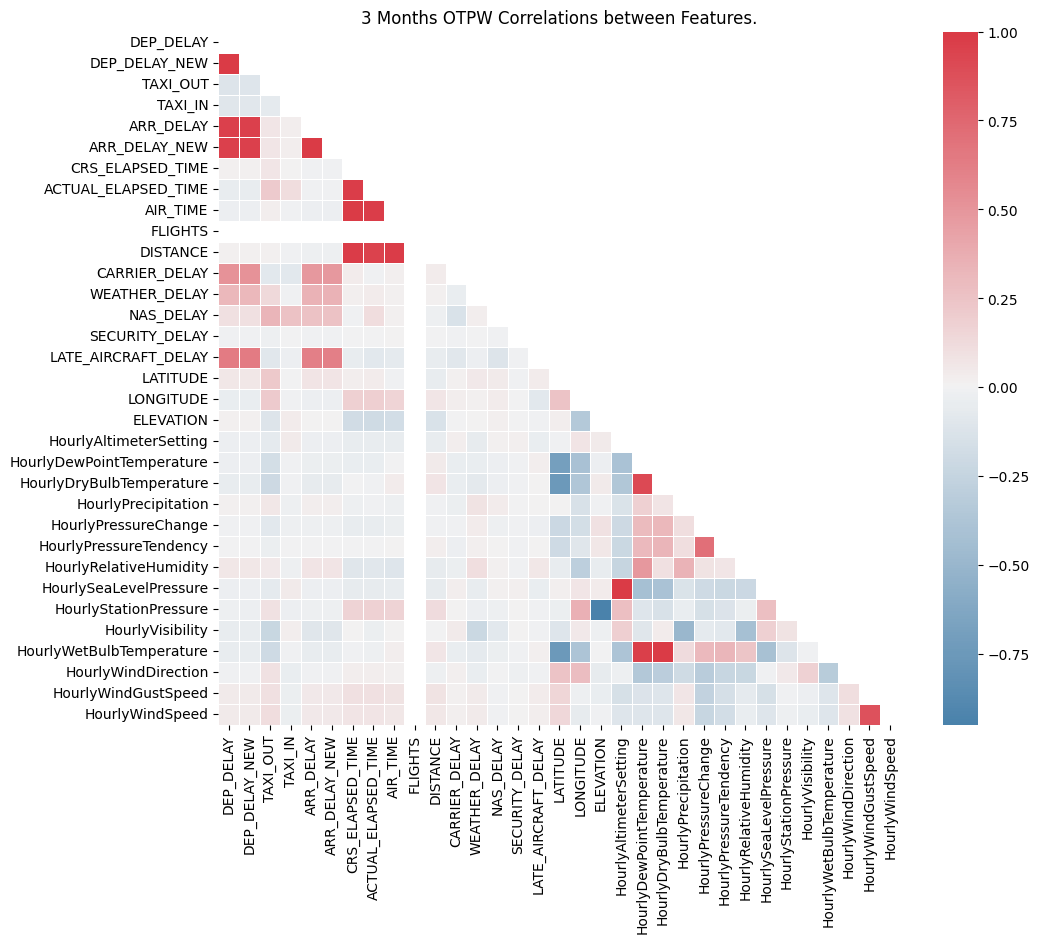

In [0]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

#extract numerical columns
otpw_numeric_cols = ['DEP_DELAY', 'DEP_DELAY_NEW', 'TAXI_OUT', 'TAXI_IN', 'ARR_DELAY', 'ARR_DELAY_NEW', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'DIV_AIRPORT_LANDINGS', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'HourlyAltimeterSetting', 'HourlyDewPointTemperature', 'HourlyDryBulbTemperature', 'HourlyPrecipitation', 'HourlyPressureChange', 'HourlyPressureTendency', 'HourlyRelativeHumidity', 'HourlySeaLevelPressure', 'HourlyStationPressure', 'HourlyVisibility', 'HourlyWetBulbTemperature', 'HourlyWindDirection', 'HourlyWindGustSpeed', 'HourlyWindSpeed']
for col in otpw_numeric_cols:
    if col not in df_otpw_quarter.columns:
        otpw_numeric_cols.remove(col)
df_otpw_quarter_num = df_otpw_quarter.select([c for c in otpw_numeric_cols])
df_otpw_quarter_num = df_otpw_quarter_num.select([F.col(c).cast('double') for c in df_otpw_quarter_num.columns])

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols = df_otpw_quarter_num.columns, outputCol=vector_col, handleInvalid="skip")
df_vector = assembler.transform(df_otpw_quarter_num).select(vector_col)

#get correlation matrix
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0] 
corr_matrix = matrix.toArray().tolist() 
corr_matrix_df = pd.DataFrame(data = corr_matrix, columns = df_otpw_quarter_num.columns, index = df_otpw_quarter_num.columns)

#plot correlation matrix
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr_matrix_df, dtype = bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap = True)
sns.heatmap(corr_matrix_df, mask = mask, cmap = cmap, center = 0, linewidths = 0.5)
plt.title("3 Months OTPW Correlations between Features.")
plt.show()

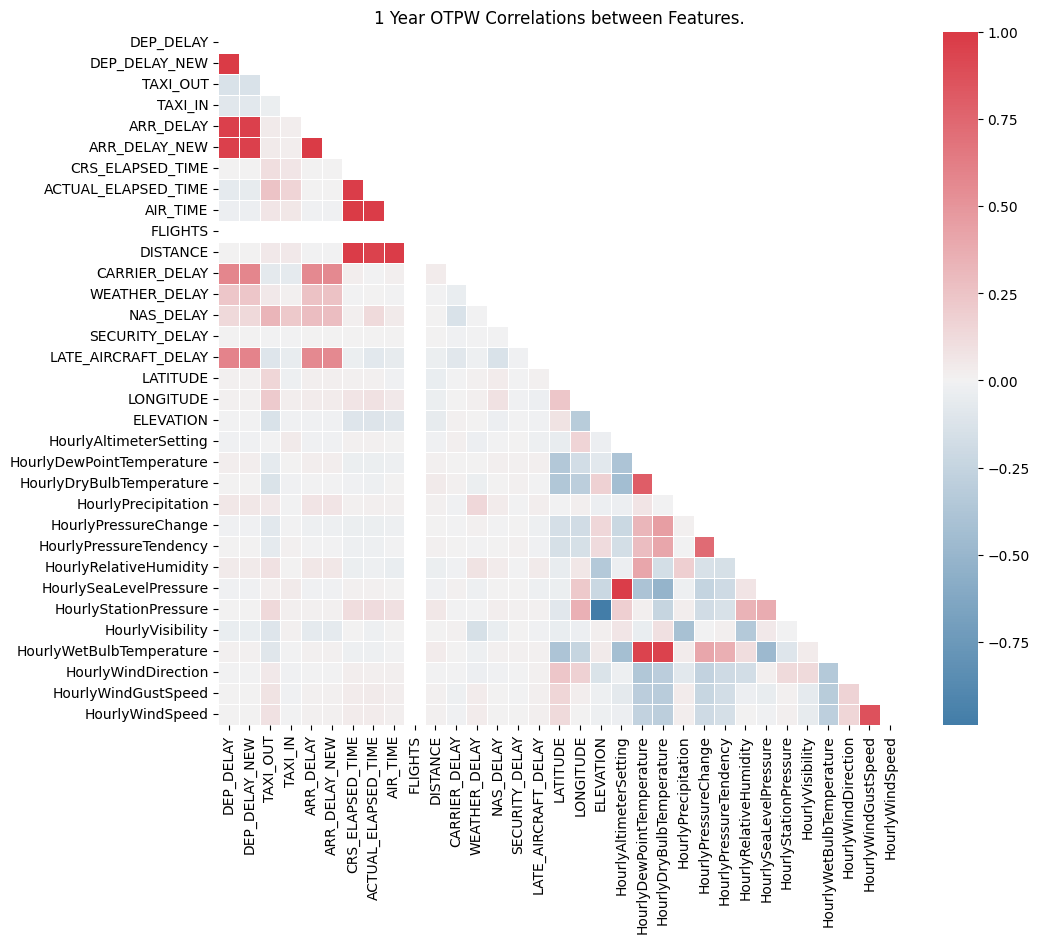

In [0]:
otpw_numeric_cols = ['DEP_DELAY', 'DEP_DELAY_NEW', 'TAXI_OUT', 'TAXI_IN', 'ARR_DELAY', 'ARR_DELAY_NEW', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'DIV_AIRPORT_LANDINGS', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'HourlyAltimeterSetting', 'HourlyDewPointTemperature', 'HourlyDryBulbTemperature', 'HourlyPrecipitation', 'HourlyPressureChange', 'HourlyPressureTendency', 'HourlyRelativeHumidity', 'HourlySeaLevelPressure', 'HourlyStationPressure', 'HourlyVisibility', 'HourlyWetBulbTemperature', 'HourlyWindDirection', 'HourlyWindGustSpeed', 'HourlyWindSpeed']

for col in otpw_numeric_cols:
    if col not in df_otpw_1yr.columns:
        otpw_numeric_cols.remove(col)
df_otpw_quarter_num = df_otpw_1yr.select([c for c in otpw_numeric_cols])
df_otpw_quarter_num = df_otpw_quarter_num.select([F.col(c).cast('double') for c in df_otpw_quarter_num.columns])

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols = df_otpw_quarter_num.columns, outputCol=vector_col, handleInvalid="skip")
df_vector = assembler.transform(df_otpw_quarter_num).select(vector_col)

#get correlation matrix
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0] 
corr_matrix = matrix.toArray().tolist() 
corr_matrix_df = pd.DataFrame(data = corr_matrix, columns = df_otpw_quarter_num.columns, index = df_otpw_quarter_num.columns)

#plot correlation matrix
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr_matrix_df, dtype = bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap = True)
sns.heatmap(corr_matrix_df, mask = mask, cmap = cmap, center = 0, linewidths = 0.5)
plt.title("1 Year OTPW Correlations between Features.")
plt.show()

####Drop Columns with Null Percentage >= 90%

In [0]:
drop_df = otpw_null_count_pandas[otpw_null_count_pandas['Percentages'] >= 90]
df_otpw_quarter = df_otpw_quarter.drop(*drop_df['Column Name'].tolist())

drop_list = [i for i in df_otpw_quarter.columns if 'Backup' in i]
drop_list.append('WindEquipmentChangeDate')
drop_list.append('_row_desc')
df_otpw_quarter = df_otpw_quarter.drop(*drop_list)

drop_df_1yr = otpw_null_count_pandas_1yr[otpw_null_count_pandas_1yr['Percentages'] >= 90]
df_otpw_1yr = df_otpw_1yr.drop(*drop_df_1yr['Column Name'].tolist())

drop_list_1yr = [i for i in df_otpw_1yr.columns if 'Backup' in i]
drop_list_1yr.append('WindEquipmentChangeDate')
drop_list_1yr.append('_row_desc')
df_otpw_1yr= df_otpw_1yr.drop(*drop_list)

print("3 Months Data")
display(df_otpw_quarter.limit(10).toPandas())
print("1 Year Data")
display(df_otpw_1yr.limit(10).toPandas())

3 Months Data


QUARTER DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM OP_CARRIER_FL_NUM ORIGIN_AIRPORT_ID ORIGIN_AIRPORT_SEQ_ID ORIGIN_CITY_MARKET_ID ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR ORIGIN_STATE_FIPS ORIGIN_STATE_NM ORIGIN_WAC DEST_AIRPORT_ID DEST_AIRPORT_SEQ_ID DEST_CITY_MARKET_ID DEST DEST_CITY_NAME DEST_STATE_ABR DEST_STATE_FIPS DEST_STATE_NM DEST_WAC CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK TAXI_OUT WHEELS_OFF WHEELS_ON TAXI_IN CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED DIVERTED CRS_ELAPSED_TIME ACTUAL_ELAPSED_TIME AIR_TIME FLIGHTS DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY YEAR MONTH origin_airport_name origin_station_name origin_station_id origin_iata_code origin_icao origin_type origin_region origin_station_lat origin_station_lon origin_airport_lat origin_airport_lon origin_station_dis dest_airport_name dest_station_name dest_station_id dest_iata_code dest_icao dest_type dest_region dest_station_lat dest_station_lon dest_airport_lat dest_airport_lon dest_station_dis sched_depart_date_time sched_depart_date_time_UTC four_hours_prior_depart_UTC two_hours_prior_depart_UTC STATION DATE LATITUDE LONGITUDE ELEVATION NAME REPORT_TYPE SOURCE HourlyAltimeterSetting HourlyDewPointTemperature HourlyDryBulbTemperature HourlyPrecipitation HourlyPresentWeatherType HourlyPressureChange HourlyPressureTendency HourlyRelativeHumidity HourlySkyConditions HourlySeaLevelPressure HourlyStationPressure HourlyVisibility HourlyWetBulbTemperature HourlyWindDirection HourlyWindGustSpeed HourlyWindSpeed REM 1 21 6 2015-02-21 WN 19393 WN N259WN 3158 14679 1467903 33570 SAN San Diego, CA CA 6 California 91 14057 1405702 34057 PDX Portland, OR OR 41 Oregon 92 1110 1143 33.0 33.0 1.0 2 1100-1159 11.0 1154 1414 3.0 1350 1417 27.0 27.0 1.0 1 1300-1359 0.0 0.0 160.0 154.0 140.0 1.0 933.0 4 26.0 0.0 0.0 0.0 1.0 2015 2 San Diego International Airport SAN DIEGO INTERNATIONAL AIRPO 72290023188 SAN KSAN large_airport US-CA 32.7 -117.2 32.7 -117.2 0.0 Portland International Airport PORTLAND INTERNATIONAL AIRPOR 72698024229 PDX KPDX large_airport US-OR 45.6 -122.6 45.6 -122.6 0.0 2015-02-21T11:10:00 2015-02-21T19:10:00 2015-02-21T15:10:00 2015-02-21T17:10:00 72290023188 2015-02-21T15:51:00 32.7336 -117.1831 4.6 SAN DIEGO INTERNATIONAL AIRPORT, CA US FM-15 7 29.92 48 64 0.00 null +0.01 5 56 SCT:04 30 BKN:07 200 29.92 29.89 10.00 55 230 null 9 MET12302/21/15 15:51:02 METAR KSAN 212351Z 23008KT 10SM SCT030 BKN200 18/09 A2992 RMK AO2 SLP131 T01780089 10183 20167 55005 (CR) 1 28 6 2015-02-28 WN 19393 WN N777QC 3171 10821 1082103 30852 BWI Baltimore, MD MD 24 Maryland 35 14027 1402702 34027 PBI West Palm Beach/Palm Beach, FL FL 12 Florida 33 1220 1218 -2.0 0.0 0.0 -1 1200-1259 6.0 1224 1505 6.0 1450 1511 21.0 21.0 1.0 1 1400-1459 0.0 0.0 150.0 173.0 161.0 1.0 883.0 4 0.0 0.0 21.0 0.0 0.0 2015 2 Baltimore/Washington International Thurgood Marshall Airport BALTIMORE-WASHINGTON INTL AIR 72406093721 BWI KBWI large_airport US-MD 39.2 -76.7 39.2 -76.7 0.0 Palm Beach International Airport PALM BEACH INTERNATIONAL AIRP 72203012844 PBI KPBI large_airport US-FL 26.7 -80.1 26.7 -80.1 0.0 2015-02-28T12:20:00 2015-02-28T17:20:00 2015-02-28T13:20:00 2015-02-28T15:20:00 72406093721 2015-02-28T13:54:00 39.1733 -76.684 47.5 BALTIMORE WASHINGTON INTERNATIONAL AIRPORT, MD US FM-15 7 30.77 -2 28 0.00 null null null 27 FEW:02 190 BKN:07 250 30.78 30.60 10.00 21 000 null 0 MET10802/28/15 13:54:02 METAR KBWI 281854Z 00000KT 10SM FEW190 BKN250 M02/M19 A3077 RMK AO2 SLP422 T10221189 (MJF) 1 7 6 2015-02-07 WN 19393 WN N764SW 3198 15304 1530402 33195 TPA Tampa, FL FL 12 Florida 33 10599 1059904 30599 BHM Birmingham, AL AL 1 Alabama 51 1415 1410 -5.0 0.0 0.0 -1 1400-1459 11.0 1421 1428 4.0 1440 1432 -8.0 0.0 0.0 -1 1400-1459 0.0 0.0 85.0 82.0 67.0 1.0 459.0 2 null null null null null 2015 2 Tampa Internation

1 Year Data


QUARTER DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM OP_CARRIER_FL_NUM ORIGIN_AIRPORT_ID ORIGIN_AIRPORT_SEQ_ID ORIGIN_CITY_MARKET_ID ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR ORIGIN_STATE_FIPS ORIGIN_STATE_NM ORIGIN_WAC DEST_AIRPORT_ID DEST_AIRPORT_SEQ_ID DEST_CITY_MARKET_ID DEST DEST_CITY_NAME DEST_STATE_ABR DEST_STATE_FIPS DEST_STATE_NM DEST_WAC CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK TAXI_OUT WHEELS_OFF WHEELS_ON TAXI_IN CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED DIVERTED CRS_ELAPSED_TIME ACTUAL_ELAPSED_TIME AIR_TIME FLIGHTS DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY YEAR MONTH origin_airport_name origin_station_name origin_station_id origin_iata_code origin_icao origin_type origin_region origin_station_lat origin_station_lon origin_airport_lat origin_airport_lon origin_station_dis dest_airport_name dest_station_name dest_station_id dest_iata_code dest_icao dest_type dest_region dest_station_lat dest_station_lon dest_airport_lat dest_airport_lon dest_station_dis sched_depart_date_time sched_depart_date_time_UTC four_hours_prior_depart_UTC two_hours_prior_depart_UTC STATION DATE LATITUDE LONGITUDE ELEVATION NAME REPORT_TYPE SOURCE HourlyAltimeterSetting HourlyDewPointTemperature HourlyDryBulbTemperature HourlyPrecipitation HourlyPresentWeatherType HourlyPressureChange HourlyPressureTendency HourlyRelativeHumidity HourlySkyConditions HourlySeaLevelPressure HourlyStationPressure HourlyVisibility HourlyWetBulbTemperature HourlyWindDirection HourlyWindGustSpeed HourlyWindSpeed REM 1 25 3 2015-03-25 AA 19805 AA N793AA 1 12478 1247802 31703 JFK New York, NY NY 36 New York 22 12892 1289203 32575 LAX Los Angeles, CA CA 6 California 91 900 851 -9.0 0.0 0.0 -1 0900-0959 22.0 913 1202 19.0 1241 1221 -20.0 0.0 0.0 -2 1200-1259 0.0 0.0 401.0 390.0 349.0 1.0 2475.0 10 null null null null null 2015 3 John F Kennedy International Airport JOHN F KENNEDY INTERNATIONAL 74486094789 JFK KJFK large_airport US-NY 40.6 -73.8 40.6 -73.8 0.0 Los Angeles International Airport LOS ANGELES INTERNATIONAL AIR 72295023174 LAX KLAX large_airport US-CA 33.9 -118.4 33.9 -118.4 0.0 2015-03-25T09:00:00 2015-03-25T13:00:00 2015-03-25T09:00:00 2015-03-25T11:00:00 74486094789 2015-03-25T09:51:00 40.63915 -73.76401 3.4 JFK INTERNATIONAL AIRPORT, NY US FM-15 7 30.43 16 44 0.00 null -0.01 1 32 BKN:07 250 30.43 30.40 10.00 34 200 null 7 MET10503/25/15 09:51:02 METAR KJFK 251451Z 20006KT 10SM BKN250 07/M09 A3043 RMK AO2 SLP304 T00671089 51003 (BH) 1 10 2 2015-02-10 AA 19805 AA N798AA 2 12892 1289203 32575 LAX Los Angeles, CA CA 6 California 91 12478 1247802 31703 JFK New York, NY NY 36 New York 22 900 900 0.0 0.0 0.0 0 0900-0959 13.0 913 1644 11.0 1729 1655 -34.0 0.0 0.0 -2 1700-1759 0.0 0.0 329.0 295.0 271.0 1.0 2475.0 10 null null null null null 2015 2 Los Angeles International Airport LOS ANGELES INTERNATIONAL AIR 72295023174 LAX KLAX large_airport US-CA 33.9 -118.4 33.9 -118.4 0.0 John F Kennedy International Airport JOHN F KENNEDY INTERNATIONAL 74486094789 JFK KJFK large_airport US-NY 40.6 -73.8 40.6 -73.8 0.0 2015-02-10T09:00:00 2015-02-10T17:00:00 2015-02-10T13:00:00 2015-02-10T15:00:00 72295023174 2015-02-10T13:53:00 33.938 -118.3888 29.6 LOS ANGELES INTERNATIONAL AIRPORT, CA US FM-15 7 29.92 51 67 0.00 null null null 57 FEW:02 100 29.92 29.57 10.00 58 280 null 13 MET10102/10/15 13:53:02 METAR KLAX 102153Z 28011KT 10SM FEW100 19/11 A2992 RMK AO2 SLP132 T01940106 $ (DMQ) 3 3 5 2015-07-03 AA 19805 AA N794AA 4 12892 1289203 32575 LAX Los Angeles, CA CA 6 California 91 12478 1247802 31703 JFK New York, NY NY 36 New York 22 1215 1209 -6.0 0.0 0.0 -1 1200-1259 12.0 1221 2016 6.0 2059 2022 -37.0 0.0 0.0 -2 2000-2059 0.0 0.0 344.0 313.0 295.0 1.0 2475.0 10 null null null null null 2015 7 Los Angeles International Airport LOS ANGELES INTERNATIONAL AIR 72295023174 LAX KLAX lar

### Visualizations

In [0]:
#1 year sampling at 0.01 - 1 percent
df_otpw_1yr_sample = df_otpw_1yr.sample(0.01, 0).toPandas()

zcale_cols = ["CRS_ELAPSED_TIME", "DISTANCE", "ELEVATION", "HourlyAltimeterSetting","HourlyDewPointTemperature", "HourlyDryBulbTemperature","HourlyPrecipitation", "HourlyPressureChange", "HourlyRelativeHumidity", "HourlySeaLevelPressure", "HourlyStationPressure", "HourlyVisibility", "HourlyWetBulbTemperature", "HourlyWindSpeed", "DEP_DEL15"]

df = df_otpw_1yr_sample[df_otpw_1yr_sample.columns.intersection(zcale_cols)]

for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')


/root/.ipykernel/1282/command-2769031167785475-3413019930:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Numeric Feature Exploratory Data Analysis 
`Goal`: Identify meaningful differences between delayed and not delayed flights within weather numeric feature distributions\
`Approach`: Sample 1% of data within 1 year OTPW dataset. Determine frequency of various unique numeric features, we analyze the following:

|             ||
|------------------------------| ------------------------------|
| CRS_ELAPSED_TIME             |HourlyPressureChange        |
| DISTANCE                    | HourlyRelativeHumidity      |
| ELEVATION                   | HourlyRelativeHumidity      |
| HourlyAltimeterSetting      | HourlySeaLevelPressure      |
| HourlyDewPointTemperature   | HourlyStationPressure       |
| HourlyDryBulbTemperature    | HourlyStationPressure       |
| HourlyPrecipitation         | HourlyVisibility            |
| HourlyPressureChange        | HourlyWetBulbTemperature    |
| HourlyRelativeHumidity      | HourlyWindSpeed             |

`Observations:`
Subtle difference in distributions, difficult to tell if they will contribute largely to our classification. `HourlyStationPressure` seems to have a shifted right distribution. We will have to run some form of regularization to confidently assess the contributions these features are offering.


In [0]:
def create_histogram(dataframe, group_by_column):
    temp = dataframe.groupby([group_by_column, 'DEP_DEL15']).count().reset_index().iloc[:, :3]
    temp = temp.rename(columns={temp.columns[-1]: 'Count'})
    temp['DEP_DEL15'] = temp['DEP_DEL15'].astype('category')

    fig = px.histogram(temp, x=group_by_column, y='Count', color='DEP_DEL15', marginal="box", barmode = 'overlay' ,  histnorm='percent',
                        labels={'DEP_DEL15': 'Delayed'})
    fig.update_traces(marker_line_width=1, marker_line_color="white")
    fig.update_layout(height=400, title = f'<b>{group_by_column}</b> Feature: No Delay/Delay', title_x = 0.5)
    
    
    fig.show()

# Example usage

numeric_cols = ["CRS_ELAPSED_TIME", "DISTANCE", "ELEVATION", "HourlyAltimeterSetting","HourlyDewPointTemperature", "HourlyDryBulbTemperature","HourlyPrecipitation", "HourlyPressureChange", "HourlyRelativeHumidity", "HourlySeaLevelPressure", "HourlyStationPressure", "HourlyVisibility", "HourlyWetBulbTemperature", "HourlyWindSpeed"]

for col in numeric_cols:
    create_histogram(df,col)


#### Categorical Feature Analysis

`Goal:`Analyze different categorical features and see their contribution toward delayed flights\
`Approach:` First we analyze the overall flight counts for the 5 busiest stations in 2005, which are the following: 

- Hartsfield-Jackson Atlanta International Airport (ATL)
- Chicago O'Hare International Airport (ORD)
- Dallas Fort Worth International Airport (DFW)
- Los Angeles International Airport (LAX)
- Denver International Airport (DEN)

`Observations`: 
1) Periodic `M` Shaped patterns in 7 day intervals illustrate weekly airport traffic. Monday and Fridays contitute the weekly highs in airport traffic. `DAY_OF_WEEK` is a categorical variable we can one hot encode within our model
2) By clicking on the legend and selecting a specific airport trace, we can observe month-wise trends, indicating that seasonality affects the the number of flights that are entering or leaving a specific airport. We shall one hot encode the `MONTH` feature within our dataset

In [0]:
top5_stations = ['ATL','ORD','DFW','LAX','DEN']


colors = ['tomato','dodgerblue','darkseagreen','mediumslateblue','grey']

import plotly.graph_objects as go
def transform_df(df):
    df['counts'] = 1
    df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
    return df.set_index('FL_DATE').resample('D').agg({'counts':'sum'})

pop_stations = []  
for i, station in enumerate(top5_stations):
    temp = transform_df(df_otpw_1yr.where(df_otpw_1yr['ORIGIN'] == station).select("FL_DATE").toPandas())
    pop_stations.append(
        go.Scatter(
            x=temp.index,
            y=temp['counts'],
            name=station,
            marker=dict(color=colors[i % len(colors)])))

fig = go.Figure()  
for trace in pop_stations:
    fig.add_trace(trace)

fig.update_layout(
    title='Flight Counts by Date - OTPW Training Set',
    xaxis_title='Date',
    yaxis_title='Flight Count',
    legend_title='Airport',
    title_x = 0.5,
    width = 1100, 
    height = 600,
)
    

In [0]:
top5_stations = ['ATL','ORD','DFW','LAX','DEN']


def transform_df(df):
    df['DEP_DEL15'] = pd.to_numeric(df['DEP_DEL15'], errors='coerce')
    df['DEP_DEL15'] = df['DEP_DEL15'].fillna(0)
    df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
    df = df.set_index('FL_DATE')
    
    return df.resample('D').agg({'DEP_DEL15': 'sum'}).rename(columns={'DEP_DEL15': 'delays'})

pop_stations = []


for i, station in enumerate(top5_stations):
    temp_df = df_otpw_1yr.select("FL_DATE", "DEP_DEL15").where(df_otpw_1yr['ORIGIN'] == station).toPandas()
    temp = transform_df(temp_df)
    
    scatter = go.Scatter(
        x=temp.index,
        y=temp['delays'],
        name=station,
        marker=dict(color=colors[i % len(colors)])
    )
    pop_stations.append(scatter)

fig = go.Figure()    
fig = go.Figure(data=pop_stations)
fig.update_layout(title='Daily Flight Delays by Station',
                  xaxis_title='Date',
                  yaxis_title='Number of Delays over 15 Minutes',
                  legend_title='Airport',
                  title_x = 0.5,
                  width = 1200,
                  height = 600)


###Parsing and Cleaning Values

#####FL_DATE, sched_depart_date_time, sched_depart_date_time_UTC, four_hours_prior_depart_UTC, two_hours_prior_depart_UTC, DATE: parset to timestamp object

In [0]:
df_otpw_quarter = df_otpw_quarter.withColumn("FL_DATE", F.to_timestamp(df_otpw_quarter.FL_DATE))
df_otpw_quarter = df_otpw_quarter.withColumn("sched_depart_date_time", F.to_timestamp(df_otpw_quarter.sched_depart_date_time))
df_otpw_quarter = df_otpw_quarter.withColumn("sched_depart_date_time_UTC", F.to_timestamp(df_otpw_quarter.sched_depart_date_time_UTC))
df_otpw_quarter = df_otpw_quarter.withColumn("four_hours_prior_depart_UTC", F.to_timestamp(df_otpw_quarter.four_hours_prior_depart_UTC))
df_otpw_quarter = df_otpw_quarter.withColumn("two_hours_prior_depart_UTC", F.to_timestamp(df_otpw_quarter.two_hours_prior_depart_UTC))
df_otpw_quarter = df_otpw_quarter.withColumn("DATE", F.to_timestamp(df_otpw_quarter.DATE))

df_otpw_1yr = df_otpw_1yr.withColumn("FL_DATE", F.to_timestamp(df_otpw_1yr.FL_DATE))
df_otpw_1yr = df_otpw_1yr.withColumn("sched_depart_date_time", F.to_timestamp(df_otpw_1yr.sched_depart_date_time))
df_otpw_1yr = df_otpw_1yr.withColumn("sched_depart_date_time_UTC", F.to_timestamp(df_otpw_1yr.sched_depart_date_time_UTC))
df_otpw_1yr = df_otpw_1yr.withColumn("four_hours_prior_depart_UTC", F.to_timestamp(df_otpw_1yr.four_hours_prior_depart_UTC))
df_otpw_1yr = df_otpw_1yr.withColumn("two_hours_prior_depart_UTC", F.to_timestamp(df_otpw_1yr.two_hours_prior_depart_UTC))
df_otpw_1yr = df_otpw_1yr.withColumn("DATE", F.to_timestamp(df_otpw_1yr.DATE))


#####HourlySkyConditions: parse to a list strings corresponding to sky conditions (null value as an empty list).

Encodings for Different `Sky Conditions`


| Code | Description       | Notes                                |
|------|-------------------|--------------------------------------|
| 00   | None              | SKC or CLR                           |
| 01   | One okta          | 1/10 or less but not zero            |
| 02   | Two oktas         | 2/10 - 3/10, or FEW                  |
| 03   | Three oktas       | 4/10                                 |
| 04   | Four oktas        | 5/10, or SCT                         |
| 05   | Five oktas        | 6/10                                 |
| 06   | Six oktas         | 7/10 - 8/10                          |
| 07   | Seven oktas       | 9/10 or more but not 10/10, or BKN   |
| 08   | Eight oktas       | 10/10, or OVC                        |
| 09   | Sky obscured      | Cloud amount cannot be estimated     |
| 10   | Partial Obscuration|                                      |
| 11   | Thin Scattered    |                                      |
| 12   | Scattered         |                                      |
| 13   | Dark Scattered    |                                      |
| 14   | Thin Broken       |                                      |
| 15   | Broken            |                                      |
| 16   | Dark Broken       |                                      |
| 17   | Thin Overcast     |                                      |
| 18   | Overcast          |                                      |
| 19   | Dark overcast     |                                      |
| 99   | Missing           |                                      |

#####Okta Explanation
In meteorology, an okta is a unit of measurement used to describe the amount of cloud cover at any given location such as a weather station. Sky conditions are estimated in terms of how many eighths of the sky are covered in cloud, ranging from 0 oktas (completely clear sky) through to 8 oktas (completely overcast).

In [0]:
from pyspark.sql.functions import col
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
import re


# Helper function to parse the hourlyskyconditions
def parse_hourlyskyconditions(s):
    # First, check if the string contains the pattern (letters followed by a colon and numbers)
    if re.search(r'\b[A-Z]+:\d+', str(s)):
        # If the pattern is found, extract numbers that are preceded by letters and a colon
        return re.findall(r'\b[A-Z]+:(\d+)', str(s))
    else:
        # If the pattern is not found, the string might be a standalone number
        # Extract the standalone number
        standalone_number = re.findall(r'\b\d+\b', str(s))
        return standalone_number if standalone_number else []

parse_hourlyskyconditions_udf = udf(parse_hourlyskyconditions, ArrayType(StringType()))

df_otpw_quarter = df_otpw_quarter.withColumn("HourlySkyConditions_Parsed", parse_hourlyskyconditions_udf(df_otpw_quarter.HourlySkyConditions))

df_otpw_1yr = df_otpw_1yr.withColumn("HourlySkyConditions_Parsed", parse_hourlyskyconditions_udf(df_otpw_1yr.HourlySkyConditions))

print("3 Months Data")
display(df_otpw_quarter.select(['HourlySkyConditions', 'HourlySkyConditions_Parsed']).limit(10).toPandas())
print("1 Year Data")
display(df_otpw_1yr.select(['HourlySkyConditions', 'HourlySkyConditions_Parsed']).limit(10).toPandas())


3 Months Data


HourlySkyConditions HourlySkyConditions_Parsed FEW:02 80 FEW:02 250 List(02, 02) OVC:08 2 List(08) VV:09 18 List(09) CLR:00 List(00) BKN:07 1 OVC:08 240 List(07, 08) BKN:07 180 List(07) BKN:07 4 BKN:07 11 OVC:08 30 List(07, 07, 08) FEW:02 12 List(02) SCT:04 250 List(04) FEW:02 5 BKN:07 30 OVC:08 90 List(02, 07, 08)

1 Year Data


HourlySkyConditions HourlySkyConditions_Parsed BKN:07 250 List(07) FEW:02 100 List(02) BKN:07 10 BKN:07 22 BKN:07 200 List(07, 07, 07) OVC:08 38 List(08) SCT:04 45 SCT:04 60 List(04, 04) FEW:02 45 FEW:02 250 List(02, 02) FEW:02 70 FEW:02 120 BKN:07 250 List(02, 02, 07) FEW:02 150 OVC:08 190 List(02, 08) BKN:07 48 OVC:08 70 List(07, 08) BKN:07 18 OVC:08 26 List(07, 08)

#####HourlyPresentWeatherType: parse to a list of strings corresponding to weather type (null value as an empty list).

Encodings for different `weather types`

| Code | Description                                                 | 
|------|-------------------------------------------------------------|
| FG   | Fog, ice fog or freezing fog (may include heavy fog)        |
| FG+  | Heavy fog or heavy freezing fog (not always distinguished from fog) |
| TS   | Thunder                                                     |
| PL   | Ice pellets, sleet, snow pellets or small hail              |
| GR   | Hail (may include small hail)                               |
| GL   | Glaze or rime                                               |
| DU   | Dust, volcanic ash, blowing dust, blowing sand or blowing obstruction |
| HZ   | Smoke or haze                                               |
| BLSN | Blowing or drifting snow                                    |
| FC   | Tornado, water spout or funnel cloud                        |
| WIND | High or damaging winds                                      |
| BLPY | Blowing spray                                               |
| BR   | Mist                                                        |
| DZ   | Drizzle                                                     |
| FZDZ | Freezing drizzle                                            |
| RA   | Rain                                                        |
| FZRA | Freezing rain                                               |
| SN   | Snow, snow pellets, snow grains or ice crystals             |
| UP   | Unknown precipitation                                       |
| MIFG | Ground fog                                                  |
| FZFG | Ice fog or freezing fog                                     |


In [0]:
def parse_hourlyPresentWeatherType(s):
    # This pattern matches sequences of letters that may be followed by a colon and numbers
    pattern = re.compile(r'(?:[+-])?([A-Z]+)')
    if s is None:
        return []
    # Find all matches in the string, and filter out empty strings if any
    return [match for match in pattern.findall(str(s)) if match]

parse_hourlyPresentWeatherType_udf = udf(parse_hourlyPresentWeatherType, ArrayType(StringType()))

df_otpw_quarter = df_otpw_quarter.withColumn("HourlyPresentWeatherType_Parsed", parse_hourlyPresentWeatherType_udf(df_otpw_quarter.HourlyPresentWeatherType))
df_otpw_1yr = df_otpw_1yr.withColumn("HourlyPresentWeatherType_Parsed", parse_hourlyPresentWeatherType_udf(df_otpw_1yr.HourlyPresentWeatherType))

print("3 Months Data")
display(df_otpw_quarter.select(["HourlyPresentWeatherType", "HourlyPresentWeatherType_Parsed"]).toPandas())
print("1 Year Data")
display(df_otpw_1yr.select(["HourlyPresentWeatherType", "HourlyPresentWeatherType_Parsed"]).toPandas())

3 Months Data


HourlyPresentWeatherType HourlyPresentWeatherType_Parsed null List() BR:1 s BC:3 FG:2 s |s FG s | List(BR, BC, FG, FG) -SN:03 BR:1 |SN | List(SN, BR, SN) null List() FG:2 |FG | List(FG, FG) null List() BR:1 || List(BR) null List() null List() -RA:02 |RA | List(RA, RA) null List() null List() null List() null List() null List() null List() null List() -RA:02 BR:1 |RA | List(RA, BR, RA) null List() null List() null List() null List() null List() null List() null List() null List() null List() -FZ:8 DZ:01 |FZDZ | List(FZ, DZ, FZDZ) null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() -RA:02 |RA | List(RA, RA) null List() null List() null List() null List() null List() null List() null List() null List() HZ:7 |FU |HZ List(HZ, FU, HZ) null List() null List() HZ:7 |FU |HZ List(HZ, FU, HZ) null List() BR:1 || List(BR) null List() null List() -FZ:8 RA:02 BR:1 |FZRA | List(FZ, RA, BR, FZRA) -SN:03 BR:1 |SN | List(SN, BR, SN) null List() null List() null List() null List() null List() null List() -SN:03 |SN | List(SN, SN) null List() null List() null List() -SN:03 |SN | List(SN, SN) null List() null List() null List() null List() null List() -SN:03 BL:5 SN:03 |SN | List(SN, BL, SN, SN) null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() -SN:03 |SN | List(SN, SN) null List() null List() |SN | List(SN) null List() -SN:03 BR:1 |SN | List(SN, BR, SN) null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() -RA:02 |RA | List(RA, RA) null List() null List() null List() null List() null List() RA:02 BR:1 |RA | List(RA, BR, RA) null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() -SN:03 |SN | List(SN, SN) null List() null List() null List() null List() null List() null List() null List() null List() null List() -DZ:01 BR:1 |DZ | List(DZ, BR, DZ) null List() null List() -SN:03 |SN | List(SN, SN) null List() -SN:03 BR:1 |SN | List(SN, BR, SN) null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() -SN:03 BR:1 |SN | List(SN, BR, SN) null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() HZ:7 |FU |HZ List(HZ, FU, HZ) null List() null List() BC:3 FG:2 BR:1 |FG | List(BC, FG, BR, FG) FG:2 |FG | List(FG, FG) null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() -RA:02 |RA | List(RA, RA) null List() -SN:03 |SN | List(SN, SN) null List() null List() null List() null List() null List() null List() null List() -RA:02 BR:1 |RA | List(RA, BR, RA) null List() -RA:02 BR:1 |RA | List(RA, BR, RA) null List() HZ:7 |FU |HZ List(HZ, FU, HZ) HZ:7 |FU |HZ List(HZ, FU, HZ) null List() null List() null List() -SN:03 BL:5 SN:03 |SN | List(SN, BL, SN, SN) null List() -SN:03 BR:1 |SN | List(SN, BR, SN) null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List()

1 Year Data


HourlyPresentWeatherType HourlyPresentWeatherType_Parsed null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() |RA | List(RA) null List() null List() null List() HZ:7 |FU |HZ List(HZ, FU, HZ) null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() HZ:7 |FU |HZ List(HZ, FU, HZ) null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() -RA:02 BR:1 |RA | List(RA, BR, RA) null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() -SN:03 BR:1 |s SN s | List(SN, BR, SN) -RA:02 BR:1 |RA | List(RA, BR, RA) null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() -SN:03 |SN | List(SN, SN) null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() -RA:02 |RA | List(RA, RA) null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() -SN:03 BR:1 |SN | List(SN, BR, SN) null List() null List() null List() -RA:02 BR:1 |RA | List(RA, BR, RA) ||RA List(RA) -RA:02 BR:1 |RA | List(RA, BR, RA) null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() FG:2 |FG | List(FG, FG) null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() |RA | List(RA) null List() null List() null List() -RA:02 |RA | List(RA, RA) null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() -SN:03 |SN | List(SN, SN) null List() null List() null List() null List() null List() null List() null List() null List() -RA:02 |RA | List(RA, RA) null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() null List() nul

#####HourlyPressureTendency: parse to string with value between 0 and 8 (null value as null):

Encodings for different `pressure tendencies`

| Code | Description                                                                                             | 
|------|---------------------------------------------------------------------------------------------------------|
| 0    | Increasing, then decreasing; atmospheric pressure the same or higher than 3 hours ago                   |
| 1    | Increasing then steady; or increasing, then increasing more slowly; atmospheric pressure now higher than 3 hours ago |
| 2    | Increasing (steadily or unsteadily); atmospheric pressure now higher than 3 hours ago                   |
| 3    | Decreasing or steady, then increasing; or increasing, then increasing more rapidly; atmospheric pressure now higher than 3 hours ago |
| 4    | Steady; atmospheric pressure the same as 3 hours ago                                                    |
| 5    | Decreasing, then increasing; atmospheric pressure the same or lower than 3 hours ago                    |
| 6    | Decreasing, then steady; or decreasing, then decreasing more slowly; atmospheric pressure now lower than 3 hours ago |
| 7    | Decreasing (steadily or unsteadily); atmospheric pressure now lower than 3 hours ago                   |
| 8    | Steady or increasing, then decreasing; or decreasing, then decreasing more rapidly; atmospheric pressure now lower than 3 hours ago |


In [0]:
def parse_PressureTendency(value):
    if value is None or value == "":
        return None
    # Remove any non-numeric characters except the decimal point
    numeric_value = ''.join(char for char in str(value) if char.isdigit() or char == '.' or char == '-')
    if numeric_value == '9':
        return None
    return numeric_value

parse_PressureTendency_udf = udf(parse_PressureTendency, StringType())

df_otpw_quarter = df_otpw_quarter.withColumn("HourlyPressureTendency", parse_PressureTendency_udf(df_otpw_quarter.HourlyPressureTendency))
df_otpw_1yr = df_otpw_1yr.withColumn("HourlyPressureTendency", parse_PressureTendency_udf(df_otpw_1yr.HourlyPressureTendency))

#####HourlyWindDirection: parse to string with value between 000 to 360 or 'VRB', which means variable wind direction (null values as null)

In [0]:
def parse_doubleToString(value):
    if value is None or value == "":
        return NotImplementedError
    if str(value) == "VRB":
        return "VRB"
    # Remove any non-numeric characters except the decimal point
    numeric_value = ''.join(char for char in str(value) if char.isdigit() or char == '.' or char == '-')
    return numeric_value

parse_doubleToString_udf = udf(parse_doubleToString, StringType())

df_otpw_quarter = df_otpw_quarter.withColumn("HourlyWindDirection", parse_doubleToString_udf(df_otpw_quarter.HourlyWindDirection))
df_otpw_1yr = df_otpw_1yr.withColumn("HourlyWindDirection", parse_doubleToString_udf(df_otpw_1yr.HourlyWindDirection))

#####LATITUDE, LONGITUDE, ELEVATION, HourlyAltimeterSetting, HourlyDewPointTemperature, HourlyDryBUlbTemperature, HourlyPrecipitation, HourlyPressureChange, HourlyRelativeHumidity, HourlySeaLevelPressure, HourlyStationPressure, HourlyStationPressure, HourlyVisibility, HourlyWetBulbTemperature, HourlyWindGustSpeed, HourlyWindSpeed: parse to double (null value as null)

In [0]:
from pyspark.sql.types import DoubleType

def parse_doubleToDouble(value):
    if value is None or value == "":
        return None
    # Remove any non-numeric characters except the decimal point
    numeric_value = ''.join(char for char in str(value) if char.isdigit() or char == '.' or char == '-')
    if len(numeric_value) == 0:
        return None
    # Convert the cleaned string to a float
    try:
        float(numeric_value)
        return float(numeric_value)
    except ValueError:
        return None

parse_doubleToDouble_udf = udf(parse_doubleToDouble, DoubleType())

df_otpw_quarter = df_otpw_quarter.withColumn("LATITUDE", parse_doubleToDouble_udf(df_otpw_quarter.LATITUDE))
df_otpw_quarter = df_otpw_quarter.withColumn("LONGITUDE", parse_doubleToDouble_udf(df_otpw_quarter.LONGITUDE))
df_otpw_quarter = df_otpw_quarter.withColumn("ELEVATION", parse_doubleToDouble_udf(df_otpw_quarter.ELEVATION))
df_otpw_quarter = df_otpw_quarter.withColumn("HourlyAltimeterSetting", parse_doubleToDouble_udf(df_otpw_quarter.HourlyAltimeterSetting))
df_otpw_quarter = df_otpw_quarter.withColumn("HourlyDewPointTemperature", parse_doubleToDouble_udf(df_otpw_quarter.HourlyDewPointTemperature))
df_otpw_quarter = df_otpw_quarter.withColumn("HourlyDryBulbTemperature", parse_doubleToDouble_udf(df_otpw_quarter.HourlyDryBulbTemperature))
df_otpw_quarter = df_otpw_quarter.withColumn("HourlyPrecipitation", parse_doubleToDouble_udf(df_otpw_quarter.HourlyPrecipitation))
df_otpw_quarter = df_otpw_quarter.withColumn("HourlyPressureChange", parse_doubleToDouble_udf(df_otpw_quarter.HourlyPressureChange))
df_otpw_quarter = df_otpw_quarter.withColumn("HourlyRelativeHumidity", parse_doubleToDouble_udf(df_otpw_quarter.HourlyRelativeHumidity))
df_otpw_quarter = df_otpw_quarter.withColumn("HourlySeaLevelPressure", parse_doubleToDouble_udf(df_otpw_quarter.HourlySeaLevelPressure))
df_otpw_quarter = df_otpw_quarter.withColumn("HourlyStationPressure", parse_doubleToDouble_udf(df_otpw_quarter.HourlyStationPressure))
df_otpw_quarter = df_otpw_quarter.withColumn("HourlyVisibility", parse_doubleToDouble_udf(df_otpw_quarter.HourlyVisibility))
df_otpw_quarter = df_otpw_quarter.withColumn("HourlyWetBulbTemperature", parse_doubleToDouble_udf(df_otpw_quarter.HourlyWetBulbTemperature))
df_otpw_quarter = df_otpw_quarter.withColumn("HourlyWindGustSpeed", parse_doubleToDouble_udf(df_otpw_quarter.HourlyWindGustSpeed))
df_otpw_quarter = df_otpw_quarter.withColumn("HourlyWindSpeed", parse_doubleToDouble_udf(df_otpw_quarter.HourlyWindSpeed))

df_otpw_1yr = df_otpw_1yr.withColumn("LATITUDE", parse_doubleToDouble_udf(df_otpw_1yr.LATITUDE))
df_otpw_1yr = df_otpw_1yr.withColumn("LONGITUDE", parse_doubleToDouble_udf(df_otpw_1yr.LONGITUDE))
df_otpw_1yr = df_otpw_1yr.withColumn("ELEVATION", parse_doubleToDouble_udf(df_otpw_1yr.ELEVATION))
df_otpw_1yr = df_otpw_1yr.withColumn("HourlyAltimeterSetting", parse_doubleToDouble_udf(df_otpw_1yr.HourlyAltimeterSetting))
df_otpw_1yr = df_otpw_1yr.withColumn("HourlyDewPointTemperature", parse_doubleToDouble_udf(df_otpw_1yr.HourlyDewPointTemperature))
df_otpw_1yr = df_otpw_1yr.withColumn("HourlyDryBulbTemperature", parse_doubleToDouble_udf(df_otpw_1yr.HourlyDryBulbTemperature))
df_otpw_1yr = df_otpw_1yr.withColumn("HourlyPrecipitation", parse_doubleToDouble_udf(df_otpw_1yr.HourlyPrecipitation))
df_otpw_1yr = df_otpw_1yr.withColumn("HourlyPressureChange", parse_doubleToDouble_udf(df_otpw_1yr.HourlyPressureChange))
df_otpw_1yr = df_otpw_1yr.withColumn("HourlyRelativeHumidity", parse_doubleToDouble_udf(df_otpw_1yr.HourlyRelativeHumidity))
df_otpw_1yr = df_otpw_1yr.withColumn("HourlySeaLevelPressure", parse_doubleToDouble_udf(df_otpw_1yr.HourlySeaLevelPressure))
df_otpw_1yr = df_otpw_1yr.withColumn("HourlyStationPressure", parse_doubleToDouble_udf(df_otpw_1yr.HourlyStationPressure))
df_otpw_1yr = df_otpw_1yr.withColumn("HourlyVisibility", parse_doubleToDouble_udf(df_otpw_1yr.HourlyVisibility))
df_otpw_1yr = df_otpw_1yr.withColumn("HourlyWetBulbTemperature", parse_doubleToDouble_udf(df_otpw_1yr.HourlyWetBulbTemperature))
df_otpw_1yr = df_otpw_1yr.withColumn("HourlyWindGustSpeed", parse_doubleToDouble_udf(df_otpw_1yr.HourlyWindGustSpeed))
df_otpw_1yr = df_otpw_1yr.withColumn("HourlyWindSpeed", parse_doubleToDouble_udf(df_otpw_1yr.HourlyWindSpeed))

print("3 Months Data")
display(df_otpw_quarter.limit(10).toPandas())
print("1 Year Data")
display(df_otpw_1yr.limit(10).toPandas())

3 Months Data


QUARTER DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM OP_CARRIER_FL_NUM ORIGIN_AIRPORT_ID ORIGIN_AIRPORT_SEQ_ID ORIGIN_CITY_MARKET_ID ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR ORIGIN_STATE_FIPS ORIGIN_STATE_NM ORIGIN_WAC DEST_AIRPORT_ID DEST_AIRPORT_SEQ_ID DEST_CITY_MARKET_ID DEST DEST_CITY_NAME DEST_STATE_ABR DEST_STATE_FIPS DEST_STATE_NM DEST_WAC CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK TAXI_OUT WHEELS_OFF WHEELS_ON TAXI_IN CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED DIVERTED CRS_ELAPSED_TIME ACTUAL_ELAPSED_TIME AIR_TIME FLIGHTS DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY YEAR MONTH origin_airport_name origin_station_name origin_station_id origin_iata_code origin_icao origin_type origin_region origin_station_lat origin_station_lon origin_airport_lat origin_airport_lon origin_station_dis dest_airport_name dest_station_name dest_station_id dest_iata_code dest_icao dest_type dest_region dest_station_lat dest_station_lon dest_airport_lat dest_airport_lon dest_station_dis sched_depart_date_time sched_depart_date_time_UTC four_hours_prior_depart_UTC two_hours_prior_depart_UTC STATION DATE LATITUDE LONGITUDE ELEVATION NAME REPORT_TYPE SOURCE HourlyAltimeterSetting HourlyDewPointTemperature HourlyDryBulbTemperature HourlyPrecipitation HourlyPresentWeatherType HourlyPressureChange HourlyPressureTendency HourlyRelativeHumidity HourlySkyConditions HourlySeaLevelPressure HourlyStationPressure HourlyVisibility HourlyWetBulbTemperature HourlyWindDirection HourlyWindGustSpeed HourlyWindSpeed REM HourlySkyConditions_Parsed HourlyPresentWeatherType_Parsed 1 21 6 2015-02-21T00:00:00Z WN 19393 WN N259WN 3158 14679 1467903 33570 SAN San Diego, CA CA 6 California 91 14057 1405702 34057 PDX Portland, OR OR 41 Oregon 92 1110 1143 33.0 33.0 1.0 2 1100-1159 11.0 1154 1414 3.0 1350 1417 27.0 27.0 1.0 1 1300-1359 0.0 0.0 160.0 154.0 140.0 1.0 933.0 4 26.0 0.0 0.0 0.0 1.0 2015 2 San Diego International Airport SAN DIEGO INTERNATIONAL AIRPO 72290023188 SAN KSAN large_airport US-CA 32.7 -117.2 32.7 -117.2 0.0 Portland International Airport PORTLAND INTERNATIONAL AIRPOR 72698024229 PDX KPDX large_airport US-OR 45.6 -122.6 45.6 -122.6 0.0 2015-02-21T11:10:00Z 2015-02-21T19:10:00Z 2015-02-21T15:10:00Z 2015-02-21T17:10:00Z 72290023188 2015-02-21T15:51:00Z 32.7336 -117.1831 4.6 SAN DIEGO INTERNATIONAL AIRPORT, CA US FM-15 7 29.92 48.0 64.0 0.0 null 0.01 5 56.0 SCT:04 30 BKN:07 200 29.92 29.89 10.0 55.0 230 null 9.0 MET12302/21/15 15:51:02 METAR KSAN 212351Z 23008KT 10SM SCT030 BKN200 18/09 A2992 RMK AO2 SLP131 T01780089 10183 20167 55005 (CR) List(04, 07) List() 1 28 6 2015-02-28T00:00:00Z WN 19393 WN N777QC 3171 10821 1082103 30852 BWI Baltimore, MD MD 24 Maryland 35 14027 1402702 34027 PBI West Palm Beach/Palm Beach, FL FL 12 Florida 33 1220 1218 -2.0 0.0 0.0 -1 1200-1259 6.0 1224 1505 6.0 1450 1511 21.0 21.0 1.0 1 1400-1459 0.0 0.0 150.0 173.0 161.0 1.0 883.0 4 0.0 0.0 21.0 0.0 0.0 2015 2 Baltimore/Washington International Thurgood Marshall Airport BALTIMORE-WASHINGTON INTL AIR 72406093721 BWI KBWI large_airport US-MD 39.2 -76.7 39.2 -76.7 0.0 Palm Beach International Airport PALM BEACH INTERNATIONAL AIRP 72203012844 PBI KPBI large_airport US-FL 26.7 -80.1 26.7 -80.1 0.0 2015-02-28T12:20:00Z 2015-02-28T17:20:00Z 2015-02-28T13:20:00Z 2015-02-28T15:20:00Z 72406093721 2015-02-28T13:54:00Z 39.1733 -76.684 47.5 BALTIMORE WASHINGTON INTERNATIONAL AIRPORT, MD US FM-15 7 30.77 -2.0 28.0 0.0 null null null 27.0 FEW:02 190 BKN:07 250 30.78 30.6 10.0 21.0 000 null 0.0 MET10802/28/15 13:54:02 METAR KBWI 281854Z 00000KT 10SM FEW190 BKN250 M02/M19 A3077 RMK AO2 SLP422 T10221189 (MJF) List(02, 07) List() 1 7 6 2015-02-07T00:00:00Z WN 19393 WN N764SW 3198 15304 1530402 33195 TPA Tampa, FL FL 12 Florida 33 10599 1059904 30599 BHM Birmingham, AL AL 1 Alabama 51 1415 1410 -5.0 0.0 0.0

1 Year Data


QUARTER DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM OP_CARRIER_FL_NUM ORIGIN_AIRPORT_ID ORIGIN_AIRPORT_SEQ_ID ORIGIN_CITY_MARKET_ID ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR ORIGIN_STATE_FIPS ORIGIN_STATE_NM ORIGIN_WAC DEST_AIRPORT_ID DEST_AIRPORT_SEQ_ID DEST_CITY_MARKET_ID DEST DEST_CITY_NAME DEST_STATE_ABR DEST_STATE_FIPS DEST_STATE_NM DEST_WAC CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK TAXI_OUT WHEELS_OFF WHEELS_ON TAXI_IN CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED DIVERTED CRS_ELAPSED_TIME ACTUAL_ELAPSED_TIME AIR_TIME FLIGHTS DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY YEAR MONTH origin_airport_name origin_station_name origin_station_id origin_iata_code origin_icao origin_type origin_region origin_station_lat origin_station_lon origin_airport_lat origin_airport_lon origin_station_dis dest_airport_name dest_station_name dest_station_id dest_iata_code dest_icao dest_type dest_region dest_station_lat dest_station_lon dest_airport_lat dest_airport_lon dest_station_dis sched_depart_date_time sched_depart_date_time_UTC four_hours_prior_depart_UTC two_hours_prior_depart_UTC STATION DATE LATITUDE LONGITUDE ELEVATION NAME REPORT_TYPE SOURCE HourlyAltimeterSetting HourlyDewPointTemperature HourlyDryBulbTemperature HourlyPrecipitation HourlyPresentWeatherType HourlyPressureChange HourlyPressureTendency HourlyRelativeHumidity HourlySkyConditions HourlySeaLevelPressure HourlyStationPressure HourlyVisibility HourlyWetBulbTemperature HourlyWindDirection HourlyWindGustSpeed HourlyWindSpeed REM HourlySkyConditions_Parsed HourlyPresentWeatherType_Parsed 2 30 2 2015-06-30T00:00:00Z DL 19790 DL N958DL 1133 10397 1039705 30397 ATL Atlanta, GA GA 13 Georgia 34 11193 1119302 33105 CVG Cincinnati, OH KY 21 Kentucky 52 1209 1207 -2.0 0.0 0.0 -1 1200-1259 48.0 1255 1356 72.0 1333 1508 95.0 95.0 1.0 6 1300-1359 0.0 0.0 84.0 181.0 61.0 1.0 373.0 2 0.0 0.0 95.0 0.0 0.0 2015 6 Hartsfield Jackson Atlanta International Airport HARTSFIELD-JACKSON ATLANTA IN 72219013874 ATL KATL large_airport US-GA 33.6 -84.4 33.6 -84.4 0.0 Cincinnati Northern Kentucky International Airport CINCINNATI/NORTHERN KENTUCKY 72421093814 CVG KCVG large_airport US-KY 39.0 -84.7 39.0 -84.7 0.0 2015-06-30T12:09:00Z 2015-06-30T16:09:00Z 2015-06-30T12:09:00Z 2015-06-30T14:09:00Z 72219013874 2015-06-30T12:52:00Z 33.6301 -84.4418 307.8 ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPORT, GA US FM-15 7 30.0 68.0 82.0 0.0 null 0.03 8 63.0 FEW:02 30 SCT:04 100 BKN:07 250 29.97 28.9 10.0 73.0 270 null 13.0 MET17506/30/15 12:52:02 METAR KATL 301752Z 27011KT 10SM FEW030 SCT100 BKN250 28/20 A3000 RMK AO2 RAE1655 SLP148 CB DSNT NE-E TCU DSNT S P0000 60007 T02780200 10283 20222 58011 (CJL) List(02, 04, 07) List() 2 31 7 2015-05-31T00:00:00Z DL 19790 DL N900PC 1134 10397 1039705 30397 ATL Atlanta, GA GA 13 Georgia 34 14027 1402702 34027 PBI West Palm Beach/Palm Beach, FL FL 12 Florida 33 835 834 -1.0 0.0 0.0 -1 0800-0859 18.0 852 1010 4.0 1020 1014 -6.0 0.0 0.0 -1 1000-1059 0.0 0.0 105.0 100.0 78.0 1.0 545.0 3 null null null null null 2015 5 Hartsfield Jackson Atlanta International Airport HARTSFIELD-JACKSON ATLANTA IN 72219013874 ATL KATL large_airport US-GA 33.6 -84.4 33.6 -84.4 0.0 Palm Beach International Airport PALM BEACH INTERNATIONAL AIRP 72203012844 PBI KPBI large_airport US-FL 26.7 -80.1 26.7 -80.1 0.0 2015-05-31T08:35:00Z 2015-05-31T12:35:00Z 2015-05-31T08:35:00Z 2015-05-31T10:35:00Z 72219013874 2015-05-31T08:52:00Z 33.6301 -84.4418 307.8 ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPORT, GA US FM-15 7 30.1 69.0 77.0 0.0 null null null 77.0 FEW:02 12 SCT:04 60 BKN:07 250 30.07 29.0 10.0 72.0 160 null 6.0 MET11205/31/15 08:52:02 METAR KATL 311352Z 16005KT 10SM FEW012 SCT060 BKN250 25/21 A3010 RMK AO2 SLP184 T02500206 (SW) List(02, 04, 07) List() 3 10 5 2015-07-10T00:00:00Z DL 19790 DL N908DA 1134 14

#####Parse DEP_DEL15

In [0]:
# Helper function to parse binary columns
def parse_binary_double(value):
    if value is None:
        return float(1)
    else:
        return float(value)

parse_binary_double_udf = udf(parse_binary_double, DoubleType())

df_otpw_quarter = df_otpw_quarter.withColumn("DEP_DEL15", parse_binary_double_udf(df_otpw_quarter.DEP_DEL15))
df_otpw_1yr = df_otpw_1yr.withColumn("DEP_DEL15", parse_binary_double_udf(df_otpw_1yr.DEP_DEL15))

#####Parse Flight Data Numeric Features

In [0]:

df_otpw_quarter = df_otpw_quarter.withColumn("DEP_DELAY", parse_doubleToDouble_udf(df_otpw_quarter.DEP_DELAY))
df_otpw_quarter = df_otpw_quarter.withColumn("DEP_DELAY_NEW", parse_doubleToDouble_udf(df_otpw_quarter.DEP_DELAY_NEW))
df_otpw_quarter = df_otpw_quarter.withColumn("TAXI_OUT", parse_doubleToDouble_udf(df_otpw_quarter.TAXI_OUT))
df_otpw_quarter = df_otpw_quarter.withColumn("TAXI_IN", parse_doubleToDouble_udf(df_otpw_quarter.TAXI_IN))
df_otpw_quarter = df_otpw_quarter.withColumn("ARR_DELAY", parse_doubleToDouble_udf(df_otpw_quarter.ARR_DELAY))
df_otpw_quarter = df_otpw_quarter.withColumn("ARR_DELAY_NEW", parse_doubleToDouble_udf(df_otpw_quarter.ARR_DELAY_NEW))
df_otpw_quarter = df_otpw_quarter.withColumn("CRS_ELAPSED_TIME", parse_doubleToDouble_udf(df_otpw_quarter.CRS_ELAPSED_TIME))
df_otpw_quarter = df_otpw_quarter.withColumn("ACTUAL_ELAPSED_TIME", parse_doubleToDouble_udf(df_otpw_quarter.ACTUAL_ELAPSED_TIME))
df_otpw_quarter = df_otpw_quarter.withColumn("AIR_TIME", parse_doubleToDouble_udf(df_otpw_quarter.AIR_TIME))
df_otpw_quarter = df_otpw_quarter.withColumn("FLIGHTS", parse_doubleToDouble_udf(df_otpw_quarter.FLIGHTS))
df_otpw_quarter = df_otpw_quarter.withColumn("DISTANCE", parse_doubleToDouble_udf(df_otpw_quarter.DISTANCE))
df_otpw_quarter = df_otpw_quarter.withColumn("CARRIER_DELAY", parse_doubleToDouble_udf(df_otpw_quarter.CARRIER_DELAY))
df_otpw_quarter = df_otpw_quarter.withColumn("WEATHER_DELAY", parse_doubleToDouble_udf(df_otpw_quarter.WEATHER_DELAY))
df_otpw_quarter = df_otpw_quarter.withColumn("NAS_DELAY", parse_doubleToDouble_udf(df_otpw_quarter.NAS_DELAY))
df_otpw_quarter = df_otpw_quarter.withColumn("SECURITY_DELAY", parse_doubleToDouble_udf(df_otpw_quarter.SECURITY_DELAY))
df_otpw_quarter = df_otpw_quarter.withColumn("LATE_AIRCRAFT_DELAY", parse_doubleToDouble_udf(df_otpw_quarter.LATE_AIRCRAFT_DELAY))

df_otpw_1yr = df_otpw_1yr.withColumn("DEP_DELAY", parse_doubleToDouble_udf(df_otpw_1yr.DEP_DELAY))
df_otpw_1yr = df_otpw_1yr.withColumn("DEP_DELAY_NEW", parse_doubleToDouble_udf(df_otpw_1yr.DEP_DELAY_NEW))
df_otpw_1yr = df_otpw_1yr.withColumn("TAXI_OUT", parse_doubleToDouble_udf(df_otpw_1yr.TAXI_OUT))
df_otpw_1yr = df_otpw_1yr.withColumn("TAXI_IN", parse_doubleToDouble_udf(df_otpw_1yr.TAXI_IN))
df_otpw_1yr = df_otpw_1yr.withColumn("ARR_DELAY", parse_doubleToDouble_udf(df_otpw_1yr.ARR_DELAY))
df_otpw_1yr = df_otpw_1yr.withColumn("ARR_DELAY_NEW", parse_doubleToDouble_udf(df_otpw_1yr.ARR_DELAY_NEW))
df_otpw_1yr = df_otpw_1yr.withColumn("CRS_ELAPSED_TIME", parse_doubleToDouble_udf(df_otpw_1yr.CRS_ELAPSED_TIME))
df_otpw_1yr = df_otpw_1yr.withColumn("ACTUAL_ELAPSED_TIME", parse_doubleToDouble_udf(df_otpw_1yr.ACTUAL_ELAPSED_TIME))
df_otpw_1yr = df_otpw_1yr.withColumn("AIR_TIME", parse_doubleToDouble_udf(df_otpw_1yr.AIR_TIME))
df_otpw_1yr = df_otpw_1yr.withColumn("FLIGHTS", parse_doubleToDouble_udf(df_otpw_1yr.FLIGHTS))
df_otpw_1yr = df_otpw_1yr.withColumn("DISTANCE", parse_doubleToDouble_udf(df_otpw_1yr.DISTANCE))
df_otpw_1yr = df_otpw_1yr.withColumn("CARRIER_DELAY", parse_doubleToDouble_udf(df_otpw_1yr.CARRIER_DELAY))
df_otpw_1yr = df_otpw_1yr.withColumn("WEATHER_DELAY", parse_doubleToDouble_udf(df_otpw_1yr.WEATHER_DELAY))
df_otpw_1yr = df_otpw_1yr.withColumn("NAS_DELAY", parse_doubleToDouble_udf(df_otpw_1yr.NAS_DELAY))
df_otpw_1yr = df_otpw_1yr.withColumn("SECURITY_DELAY", parse_doubleToDouble_udf(df_otpw_1yr.SECURITY_DELAY))
df_otpw_1yr = df_otpw_1yr.withColumn("LATE_AIRCRAFT_DELAY", parse_doubleToDouble_udf(df_otpw_1yr.LATE_AIRCRAFT_DELAY))

print("3 Months Data")
display(df_otpw_quarter.limit(10).toPandas())
print("1 Year Data")
display(df_otpw_1yr.limit(10).toPandas())

3 Months Data


QUARTER DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM OP_CARRIER_FL_NUM ORIGIN_AIRPORT_ID ORIGIN_AIRPORT_SEQ_ID ORIGIN_CITY_MARKET_ID ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR ORIGIN_STATE_FIPS ORIGIN_STATE_NM ORIGIN_WAC DEST_AIRPORT_ID DEST_AIRPORT_SEQ_ID DEST_CITY_MARKET_ID DEST DEST_CITY_NAME DEST_STATE_ABR DEST_STATE_FIPS DEST_STATE_NM DEST_WAC CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK TAXI_OUT WHEELS_OFF WHEELS_ON TAXI_IN CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED DIVERTED CRS_ELAPSED_TIME ACTUAL_ELAPSED_TIME AIR_TIME FLIGHTS DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY YEAR MONTH origin_airport_name origin_station_name origin_station_id origin_iata_code origin_icao origin_type origin_region origin_station_lat origin_station_lon origin_airport_lat origin_airport_lon origin_station_dis dest_airport_name dest_station_name dest_station_id dest_iata_code dest_icao dest_type dest_region dest_station_lat dest_station_lon dest_airport_lat dest_airport_lon dest_station_dis sched_depart_date_time sched_depart_date_time_UTC four_hours_prior_depart_UTC two_hours_prior_depart_UTC STATION DATE LATITUDE LONGITUDE ELEVATION NAME REPORT_TYPE SOURCE HourlyAltimeterSetting HourlyDewPointTemperature HourlyDryBulbTemperature HourlyPrecipitation HourlyPresentWeatherType HourlyPressureChange HourlyPressureTendency HourlyRelativeHumidity HourlySkyConditions HourlySeaLevelPressure HourlyStationPressure HourlyVisibility HourlyWetBulbTemperature HourlyWindDirection HourlyWindGustSpeed HourlyWindSpeed REM HourlySkyConditions_Parsed HourlyPresentWeatherType_Parsed 1 21 6 2015-02-21T00:00:00Z WN 19393 WN N259WN 3158 14679 1467903 33570 SAN San Diego, CA CA 6 California 91 14057 1405702 34057 PDX Portland, OR OR 41 Oregon 92 1110 1143 33.0 33.0 1.0 2 1100-1159 11.0 1154 1414 3.0 1350 1417 27.0 27.0 1.0 1 1300-1359 0.0 0.0 160.0 154.0 140.0 1.0 933.0 4 26.0 0.0 0.0 0.0 1.0 2015 2 San Diego International Airport SAN DIEGO INTERNATIONAL AIRPO 72290023188 SAN KSAN large_airport US-CA 32.7 -117.2 32.7 -117.2 0.0 Portland International Airport PORTLAND INTERNATIONAL AIRPOR 72698024229 PDX KPDX large_airport US-OR 45.6 -122.6 45.6 -122.6 0.0 2015-02-21T11:10:00Z 2015-02-21T19:10:00Z 2015-02-21T15:10:00Z 2015-02-21T17:10:00Z 72290023188 2015-02-21T15:51:00Z 32.7336 -117.1831 4.6 SAN DIEGO INTERNATIONAL AIRPORT, CA US FM-15 7 29.92 48.0 64.0 0.0 null 0.01 5 56.0 SCT:04 30 BKN:07 200 29.92 29.89 10.0 55.0 230 null 9.0 MET12302/21/15 15:51:02 METAR KSAN 212351Z 23008KT 10SM SCT030 BKN200 18/09 A2992 RMK AO2 SLP131 T01780089 10183 20167 55005 (CR) List(04, 07) List() 1 28 6 2015-02-28T00:00:00Z WN 19393 WN N777QC 3171 10821 1082103 30852 BWI Baltimore, MD MD 24 Maryland 35 14027 1402702 34027 PBI West Palm Beach/Palm Beach, FL FL 12 Florida 33 1220 1218 -2.0 0.0 0.0 -1 1200-1259 6.0 1224 1505 6.0 1450 1511 21.0 21.0 1.0 1 1400-1459 0.0 0.0 150.0 173.0 161.0 1.0 883.0 4 0.0 0.0 21.0 0.0 0.0 2015 2 Baltimore/Washington International Thurgood Marshall Airport BALTIMORE-WASHINGTON INTL AIR 72406093721 BWI KBWI large_airport US-MD 39.2 -76.7 39.2 -76.7 0.0 Palm Beach International Airport PALM BEACH INTERNATIONAL AIRP 72203012844 PBI KPBI large_airport US-FL 26.7 -80.1 26.7 -80.1 0.0 2015-02-28T12:20:00Z 2015-02-28T17:20:00Z 2015-02-28T13:20:00Z 2015-02-28T15:20:00Z 72406093721 2015-02-28T13:54:00Z 39.1733 -76.684 47.5 BALTIMORE WASHINGTON INTERNATIONAL AIRPORT, MD US FM-15 7 30.77 -2.0 28.0 0.0 null null null 27.0 FEW:02 190 BKN:07 250 30.78 30.6 10.0 21.0 000 null 0.0 MET10802/28/15 13:54:02 METAR KBWI 281854Z 00000KT 10SM FEW190 BKN250 M02/M19 A3077 RMK AO2 SLP422 T10221189 (MJF) List(02, 07) List() 1 7 6 2015-02-07T00:00:00Z WN 19393 WN N764SW 3198 15304 1530402 33195 TPA Tampa, FL FL 12 Florida 33 10599 1059904 30599 BHM Birmingham, AL AL 1 Alabama 51 1415 1410 -5.0 0.0 0.0

1 Year Data


QUARTER DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM OP_CARRIER_FL_NUM ORIGIN_AIRPORT_ID ORIGIN_AIRPORT_SEQ_ID ORIGIN_CITY_MARKET_ID ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR ORIGIN_STATE_FIPS ORIGIN_STATE_NM ORIGIN_WAC DEST_AIRPORT_ID DEST_AIRPORT_SEQ_ID DEST_CITY_MARKET_ID DEST DEST_CITY_NAME DEST_STATE_ABR DEST_STATE_FIPS DEST_STATE_NM DEST_WAC CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK TAXI_OUT WHEELS_OFF WHEELS_ON TAXI_IN CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED DIVERTED CRS_ELAPSED_TIME ACTUAL_ELAPSED_TIME AIR_TIME FLIGHTS DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY YEAR MONTH origin_airport_name origin_station_name origin_station_id origin_iata_code origin_icao origin_type origin_region origin_station_lat origin_station_lon origin_airport_lat origin_airport_lon origin_station_dis dest_airport_name dest_station_name dest_station_id dest_iata_code dest_icao dest_type dest_region dest_station_lat dest_station_lon dest_airport_lat dest_airport_lon dest_station_dis sched_depart_date_time sched_depart_date_time_UTC four_hours_prior_depart_UTC two_hours_prior_depart_UTC STATION DATE LATITUDE LONGITUDE ELEVATION NAME REPORT_TYPE SOURCE HourlyAltimeterSetting HourlyDewPointTemperature HourlyDryBulbTemperature HourlyPrecipitation HourlyPresentWeatherType HourlyPressureChange HourlyPressureTendency HourlyRelativeHumidity HourlySkyConditions HourlySeaLevelPressure HourlyStationPressure HourlyVisibility HourlyWetBulbTemperature HourlyWindDirection HourlyWindGustSpeed HourlyWindSpeed REM HourlySkyConditions_Parsed HourlyPresentWeatherType_Parsed 2 30 2 2015-06-30T00:00:00Z DL 19790 DL N958DL 1133 10397 1039705 30397 ATL Atlanta, GA GA 13 Georgia 34 11193 1119302 33105 CVG Cincinnati, OH KY 21 Kentucky 52 1209 1207 -2.0 0.0 0.0 -1 1200-1259 48.0 1255 1356 72.0 1333 1508 95.0 95.0 1.0 6 1300-1359 0.0 0.0 84.0 181.0 61.0 1.0 373.0 2 0.0 0.0 95.0 0.0 0.0 2015 6 Hartsfield Jackson Atlanta International Airport HARTSFIELD-JACKSON ATLANTA IN 72219013874 ATL KATL large_airport US-GA 33.6 -84.4 33.6 -84.4 0.0 Cincinnati Northern Kentucky International Airport CINCINNATI/NORTHERN KENTUCKY 72421093814 CVG KCVG large_airport US-KY 39.0 -84.7 39.0 -84.7 0.0 2015-06-30T12:09:00Z 2015-06-30T16:09:00Z 2015-06-30T12:09:00Z 2015-06-30T14:09:00Z 72219013874 2015-06-30T12:52:00Z 33.6301 -84.4418 307.8 ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPORT, GA US FM-15 7 30.0 68.0 82.0 0.0 null 0.03 8 63.0 FEW:02 30 SCT:04 100 BKN:07 250 29.97 28.9 10.0 73.0 270 null 13.0 MET17506/30/15 12:52:02 METAR KATL 301752Z 27011KT 10SM FEW030 SCT100 BKN250 28/20 A3000 RMK AO2 RAE1655 SLP148 CB DSNT NE-E TCU DSNT S P0000 60007 T02780200 10283 20222 58011 (CJL) List(02, 04, 07) List() 2 31 7 2015-05-31T00:00:00Z DL 19790 DL N900PC 1134 10397 1039705 30397 ATL Atlanta, GA GA 13 Georgia 34 14027 1402702 34027 PBI West Palm Beach/Palm Beach, FL FL 12 Florida 33 835 834 -1.0 0.0 0.0 -1 0800-0859 18.0 852 1010 4.0 1020 1014 -6.0 0.0 0.0 -1 1000-1059 0.0 0.0 105.0 100.0 78.0 1.0 545.0 3 null null null null null 2015 5 Hartsfield Jackson Atlanta International Airport HARTSFIELD-JACKSON ATLANTA IN 72219013874 ATL KATL large_airport US-GA 33.6 -84.4 33.6 -84.4 0.0 Palm Beach International Airport PALM BEACH INTERNATIONAL AIRP 72203012844 PBI KPBI large_airport US-FL 26.7 -80.1 26.7 -80.1 0.0 2015-05-31T08:35:00Z 2015-05-31T12:35:00Z 2015-05-31T08:35:00Z 2015-05-31T10:35:00Z 72219013874 2015-05-31T08:52:00Z 33.6301 -84.4418 307.8 ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPORT, GA US FM-15 7 30.1 69.0 77.0 0.0 null null null 77.0 FEW:02 12 SCT:04 60 BKN:07 250 30.07 29.0 10.0 72.0 160 null 6.0 MET11205/31/15 08:52:02 METAR KATL 311352Z 16005KT 10SM FEW012 SCT060 BKN250 25/21 A3010 RMK AO2 SLP184 T02500206 (SW) List(02, 04, 07) List() 3 10 5 2015-07-10T00:00:00Z DL 19790 DL N908DA 1134 14

##Feature Engineering

###Holiday flag

In [0]:
#adding is holiday column - only good for 2015
federal_holidays = [
'2015-07-04', '2015-12-25', '2015-12-24', '2015-10-12', '2015-04-12',
'2015-06-19', '2015-09-07', '2015-09-05', '2015-09-06', '2015-01-19',
'2015-05-25', '2015-01-01', '2015-12-31', '2015-11-26', '2015-11-25',
'2015-02-14', '2015-11-11', '2015-02-16', '2015-04-05'
]

def is_holiday(date):
    return 1 if date in federal_holidays else 0

is_holiday_udf = udf(is_holiday, IntegerType())

df_otpw_quarter = df_otpw_quarter.withColumn('is_holiday', is_holiday_udf(df_otpw_quarter.FL_DATE))
df_otpw_1yr = df_otpw_1yr.withColumn('is_holiday', is_holiday_udf(df_otpw_1yr.FL_DATE))

In [0]:
print("3 Months Data")
df_otpw_quarter.printSchema()
print("1 Year Data")
df_otpw_1yr.printSchema()

3 Months Data
root
 |-- QUARTER: string (nullable = true)
 |-- DAY_OF_MONTH: string (nullable = true)
 |-- DAY_OF_WEEK: string (nullable = true)
 |-- FL_DATE: timestamp (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- OP_CARRIER_AIRLINE_ID: string (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- TAIL_NUM: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: string (nullable = true)
 |-- ORIGIN_AIRPORT_ID: string (nullable = true)
 |-- ORIGIN_AIRPORT_SEQ_ID: string (nullable = true)
 |-- ORIGIN_CITY_MARKET_ID: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY_NAME: string (nullable = true)
 |-- ORIGIN_STATE_ABR: string (nullable = true)
 |-- ORIGIN_STATE_FIPS: string (nullable = true)
 |-- ORIGIN_STATE_NM: string (nullable = true)
 |-- ORIGIN_WAC: string (nullable = true)
 |-- DEST_AIRPORT_ID: string (nullable = true)
 |-- DEST_AIRPORT_SEQ_ID: string (nullable = true)
 |-- DEST_CITY_MARKET_ID: string (nullable = true)
 |--

##Feature Selection

#####Drop Records with Null Values in: 'HourlyAltimeterSetting', 'HourlyDewPointTemperature', 'HourlyDryBulbTemperature', 'HourlyPrecipitation', 'HourlyPressureChange', 'HourlyRelativeHumidity', 'HourlySeaLevelPressure', 'HourlyStationPressure', 'HourlyVisibility', 'HourlyWetBulbTemperature', 'HourlyWindSpeed'

In [0]:
columns_to_zscale = ["CRS_ELAPSED_TIME", "DISTANCE", "ELEVATION", "HourlyAltimeterSetting","HourlyDewPointTemperature", "HourlyDryBulbTemperature","HourlyPrecipitation", "HourlyPressureChange", "HourlyRelativeHumidity", "HourlySeaLevelPressure", "HourlyStationPressure", "HourlyVisibility", "HourlyWetBulbTemperature", "HourlyWindSpeed"]


df_feature_select = df_otpw_quarter.dropna(subset = columns_to_zscale)
df_feature_select_1yr = df_otpw_1yr.dropna(subset = columns_to_zscale)

print('3 Month Data')
print(df_feature_select.count())
print('1 Year Data')
print(df_feature_select_1yr.count())

3 Month Data
243657
1 Year Data
1273852


####Address Numeric Features - Standard Scaler

In [0]:
assembler = VectorAssembler(inputCols = columns_to_zscale, outputCol = "features_to_zscale", handleInvalid = "keep")
df_feature_select = assembler.transform(df_feature_select)
scaler = StandardScaler(withMean = True, inputCol = 'features_to_zscale', outputCol = "scaled_numeric_features")
df_feature_select = scaler.fit(df_feature_select).transform(df_feature_select)

assembler_1yr = VectorAssembler(inputCols = columns_to_zscale, outputCol = "features_to_zscale", handleInvalid = "keep")
df_feature_select_1yr = assembler_1yr.transform(df_feature_select_1yr)
scaler_1yr = StandardScaler(withMean = True, inputCol = 'features_to_zscale', outputCol = "scaled_numeric_features")
df_feature_select_1yr = scaler_1yr.fit(df_feature_select_1yr).transform(df_feature_select_1yr)

####Address Categorical Features - One hot Encoding

######HourlySkyConditions and HourlyPresentWeatherType

In [0]:
hourlySkyConditions_list = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']
hourlyWeatherType_list = ['FG', 'TS', 'PL', 'GR', 'GL', 'DU', 'HZ', 'BLSN', 'FC', 'WIND', 'BLPY', 'BR', 'DZ', 'FZDZ', 'RA', 'FZRA', 'SN', 'UP', "MIFG", 'FZFG']

for category in hourlySkyConditions_list:
    df_feature_select = df_feature_select.withColumn(f"skyConditions_{category}", array_contains(F.col("HourlySkyConditions_Parsed"), category).cast("int"))
    df_feature_select_1yr = df_feature_select_1yr.withColumn(f"skyConditions_{category}", array_contains(F.col("HourlySkyConditions_Parsed"), category).cast("int"))

for category in hourlyWeatherType_list:
    df_feature_select = df_feature_select.withColumn(f"weatherType_{category}", array_contains(F.col("HourlyPresentWeatherType_Parsed"), category).cast("int"))
    df_feature_select_1yr = df_feature_select_1yr.withColumn(f"weatherType_{category}", array_contains(F.col("HourlyPresentWeatherType_Parsed"), category).cast("int"))

df_feature_select = df_feature_select.drop(*['HourlySkyConditions_Parsed', 'HourlyPresentWeatherType_Parsed'])
df_feature_select_1yr = df_feature_select_1yr.drop(*['HourlySkyConditions_Parsed', 'HourlyPresentWeatherType_Parsed'])

In [0]:
hourlySkyCols = []
for i in hourlySkyConditions_list:
    hourlySkyCols.append(f"skyConditions_{i}")

hourlyWeatherCols = []
for i in hourlyWeatherType_list:
    hourlyWeatherCols.append(f"weatherType_{i}")

assembler = VectorAssembler(inputCols = hourlySkyCols, outputCol = "hourly_sky_conditions", handleInvalid = "keep")
df_feature_select = assembler.transform(df_feature_select)
assembler = VectorAssembler(inputCols = hourlyWeatherCols, outputCol = "hourly_weather_type", handleInvalid = "keep")
df_feature_select = assembler.transform(df_feature_select)

assembler_1yr = VectorAssembler(inputCols = hourlySkyCols, outputCol = "hourly_sky_conditions", handleInvalid = "keep")
df_feature_select_1yr = assembler_1yr.transform(df_feature_select_1yr)
assembler_1yr = VectorAssembler(inputCols = hourlyWeatherCols, outputCol = "hourly_weather_type", handleInvalid = "keep")
df_feature_select_1yr = assembler_1yr.transform(df_feature_select_1yr)

df_feature_select = df_feature_select.drop(*hourlySkyCols)
df_feature_select = df_feature_select.drop(*hourlyWeatherCols)

df_feature_select_1yr = df_feature_select_1yr.drop(*hourlySkyCols)
df_feature_select_1yr = df_feature_select_1yr.drop(*hourlyWeatherCols)

In [0]:
categorical_features_names = ['HourlyPressureTendency', 'HourlyWindDirection', 'DAY_OF_WEEK','MONTH', 'origin_icao','ORIGIN_STATE_ABR','dest_icao','DEST_STATE_ABR']

In [0]:
indexers = [StringIndexer(inputCol = column, outputCol = f"{column}_Index", handleInvalid = 'keep') for column in categorical_features_names]
encoders = [OneHotEncoder(inputCol = indexer.getOutputCol(), outputCol = f"{column}_Vec") for indexer, column in zip(indexers,categorical_features_names)]

stages = indexers + encoders

pipeline = Pipeline(stages = stages)
# Fit the pipeline to the data and transform it
df_feature_select = pipeline.fit(df_feature_select).transform(df_feature_select)

indexers_1yr = [StringIndexer(inputCol = column, outputCol = f"{column}_Index", handleInvalid = 'keep') for column in categorical_features_names]
encoders_1yr = [OneHotEncoder(inputCol = indexer.getOutputCol(), outputCol = f"{column}_Vec") for indexer, column in zip(indexers_1yr,categorical_features_names)]

stages_1yr = indexers_1yr + encoders_1yr

pipeline_1yr = Pipeline(stages = stages_1yr)
# Fit the pipeline to the data and transform it
df_feature_select_1yr = pipeline_1yr.fit(df_feature_select_1yr).transform(df_feature_select_1yr)


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

###Lasso and Ridge Regression on 3 Month Data Numeric Features

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

final_features_list = ["scaled_numeric_features"]

assembler = VectorAssembler(inputCols = final_features_list, outputCol = 'features')
df_assembled = assembler.transform(df_feature_select)

#Select feature and outcome variables
df_final = df_assembled.select('features', 'DEP_DEL15')

#Initialize the Ridge regression model
ridge = LinearRegression(featuresCol = 'features', labelCol = 'DEP_DEL15', maxIter = 50, elasticNetParam = 0, regParam = 0.1)
#Initialize the Lasso regression model
lasso = LinearRegression(featuresCol = 'features', labelCol = 'DEP_DEL15', maxIter = 50, elasticNetParam = 1, regParam = 0.1)

# Fit model
ridge_model = ridge.fit(df_final)
lasso_model = lasso.fit(df_final)

RidgeSummary = ridge_model.summary
LassoSummary = lasso_model.summary

['features', 'DEP_DEL15']


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

#####Ridge Regression Results

In [0]:
coefficients = ridge_model.coefficients.toArray()
features = pd.DataFrame(list(zip(columns_to_zscale, coefficients)), columns = ['Feature', 'Coefficient'])
features.sort_values(by = ['Coefficient'], key = abs, ascending = False, inplace = True)
display(features)

print("\t Intercept: " + str(round(ridge_model.intercept, 4)))
print("\t MSE: %f" % RidgeSummary.rootMeanSquaredError**2)
print("\t r2: %f" % RidgeSummary.r2)

Feature Coefficient HourlyRelativeHumidity 0.021246158757455145 HourlyDryBulbTemperature -0.019552915544600497 HourlyWetBulbTemperature -0.01622058972576432 HourlyWindSpeed 0.01492768070238822 HourlyVisibility -0.00958125187362691 HourlyPrecipitation 0.009176333637787405 HourlyDewPointTemperature -0.008611585696449231 HourlyPressureChange -0.006868958710921405 HourlyAltimeterSetting -0.006778578677616899 DISTANCE 0.005755560593420003 CRS_ELAPSED_TIME -0.001680278325427769 HourlySeaLevelPressure -0.0012290151608794083 HourlyStationPressure 0.001062787480712631 ELEVATION -2.5802113556829215E-4

	 Intercept: 0.2244
	 MSE: 0.170136
	 r2: 0.022308


####Lasso Regression Results

In [0]:
coefficients = lasso_model.coefficients.toArray()
features = pd.DataFrame(list(zip(columns_to_zscale, coefficients)), columns = ['Feature', 'Coefficient'])
features.sort_values(by = ['Coefficient'], key = abs, ascending = False, inplace = True)
display(features)

print("\t Intercept: " + str(round(lasso_model.intercept, 4)))
print("\t MSE: %f" % LassoSummary.rootMeanSquaredError**2)
print("\t r2: %f" % LassoSummary.r2)

Feature Coefficient CRS_ELAPSED_TIME 0.0 DISTANCE 0.0 ELEVATION 0.0 HourlyAltimeterSetting 0.0 HourlyDewPointTemperature 0.0 HourlyDryBulbTemperature 0.0 HourlyPrecipitation 0.0 HourlyPressureChange 0.0 HourlyRelativeHumidity 0.0 HourlySeaLevelPressure 0.0 HourlyStationPressure 0.0 HourlyVisibility 0.0 HourlyWetBulbTemperature 0.0 HourlyWindSpeed 0.0

	 Intercept: 0.2244
	 MSE: 0.174018
	 r2: -0.000000


###Lasso and Ridge Regression on 1 Year Data Numeric Features

In [0]:
assembler_1yr = VectorAssembler(inputCols = final_features_list, outputCol = 'vec_features')
df_final_1yr = assembler_1yr.transform(df_feature_select_1yr)

#Initialize the Ridge regression model
ridge = LinearRegression(featuresCol = 'vec_features', labelCol = 'DEP_DEL15', maxIter = 50, elasticNetParam = 0, regParam = 0.1)
#Initialize the Lasso regression model
lasso = LinearRegression(featuresCol = 'vec_features', labelCol = 'DEP_DEL15', maxIter = 50, elasticNetParam = 1, regParam = 0.1)

# Fit model
ridge_model = ridge.fit(df_final_1yr)
lasso_model = lasso.fit(df_final_1yr)

RidgeSummary = ridge_model.summary
LassoSummary = lasso_model.summary

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

#####Ridge Regression Results

In [0]:
coefficients = ridge_model.coefficients.toArray()
ridge_features_1yr = pd.DataFrame(list(zip(columns_to_zscale, coefficients)), columns = ['Feature', 'Coefficient'])
ridge_features_1yr.sort_values(by = ['Coefficient'], key = abs, ascending = False, inplace = True)
display(ridge_features_1yr)

print("\t Intercept: " + str(round(ridge_model.intercept, 4)))
print("\t MSE: %f" % RidgeSummary.rootMeanSquaredError**2)
print("\t r2: %f" % RidgeSummary.r2)

Feature Coefficient HourlyRelativeHumidity 0.02091773467110551 HourlyDryBulbTemperature -0.009429602432252576 HourlyWindSpeed 0.007572319531730652 HourlyWetBulbTemperature -0.007184532297345583 HourlyAltimeterSetting -0.006925241869153694 HourlyPrecipitation 0.006886885830883343 HourlySeaLevelPressure -0.006362063372414333 CRS_ELAPSED_TIME 0.004490022466388927 HourlyVisibility -0.004106351312939944 HourlyDewPointTemperature -0.003048951416656572 HourlyPressureChange -0.0019836326088684027 DISTANCE 0.0014240752921937762 ELEVATION -5.022966177712168E-4 HourlyStationPressure -2.827389575481252E-4

	 Intercept: 0.1937
	 MSE: 0.154758
	 r2: 0.009273


#####Lasso Regression Results

In [0]:
coefficients = lasso_model.coefficients.toArray()
lasso_features_1yr = pd.DataFrame(list(zip(columns_to_zscale, coefficients)), columns = ['Feature', 'Coefficient'])
lasso_features_1yr.sort_values(by = ['Coefficient'], key = abs, ascending = False, inplace = True)
display(lasso_features_1yr)

print("\t Intercept: " + str(round(lasso_model.intercept, 4)))
print("\t MSE: %f" % LassoSummary.rootMeanSquaredError**2)
print("\t r2: %f" % LassoSummary.r2)

Feature Coefficient CRS_ELAPSED_TIME 0.0 DISTANCE 0.0 ELEVATION 0.0 HourlyAltimeterSetting 0.0 HourlyDewPointTemperature 0.0 HourlyDryBulbTemperature 0.0 HourlyPrecipitation 0.0 HourlyPressureChange 0.0 HourlyRelativeHumidity 0.0 HourlySeaLevelPressure 0.0 HourlyStationPressure 0.0 HourlyVisibility 0.0 HourlyWetBulbTemperature 0.0 HourlyWindSpeed 0.0

	 Intercept: 0.1937
	 MSE: 0.156206
	 r2: -0.000000


#Pipeline

To ensure the best possible iteration during model creation, the ATP and GSOD datasets were joined into one (the OTPW set) and then split into subsets spanning three months, one year, three years, and five years. The training and testing datasets were split at the beginning of the pipeline to prevent data leakage, and training sets always occurred before test sets in the split without time overlap. For example, the 1-year dataset contains the first three quarters of 2015 as training data and the last quarter of the year serves as test data. The data split was followed by an exploratory data analysis (EDA) and cleaning stage, which ensured any missing or duplicate values were dropped and that text columns were parsed into categorical features. Any new features were also created during this phase.

The next step, feature selection, was performed iteratively on the train and test data, and various possible features were kept or dropped based on the EDA, Lasso, and Ridge Regression results. With both datasets consisting of relevant features, we then balanced via naive undersampling, and z-scaled the training data (as Logistic Regression assumes linear data). Z-scaling was also performed on the numeric test data, though applied so that the scaling parameters were derived from the training data. All categorical variables for all datasets were then one-hot encoded, vectorized, and saved for later use.

Finally, a five-fold cross-validation grid search was used during the hyperparameter tuning phase to find and optimize the best model. The grid itself used Spark's Binary Classification Evaluator to assess model efficacy based on the model's ROC curves. The model with the best hyperparameter values was then selected and used to evaluate the withheld and cleaned test data. Final results were reported using two metrics: ROC curves and F-beta scores. The thresholding of the ROC curves provided a more holistic view of a model's performance than most other metrics, which made it optimal for assessing model performance, and the F-beta score weighted precision more highly than recall, thus enabling finer control of false-positives. This particular implementation was chosen because a false-positive in detecting a flight delay could cause passengers to miss their flight altogether, and would likely result in more customer dissatisfaction than a regular delay would have normally caused.

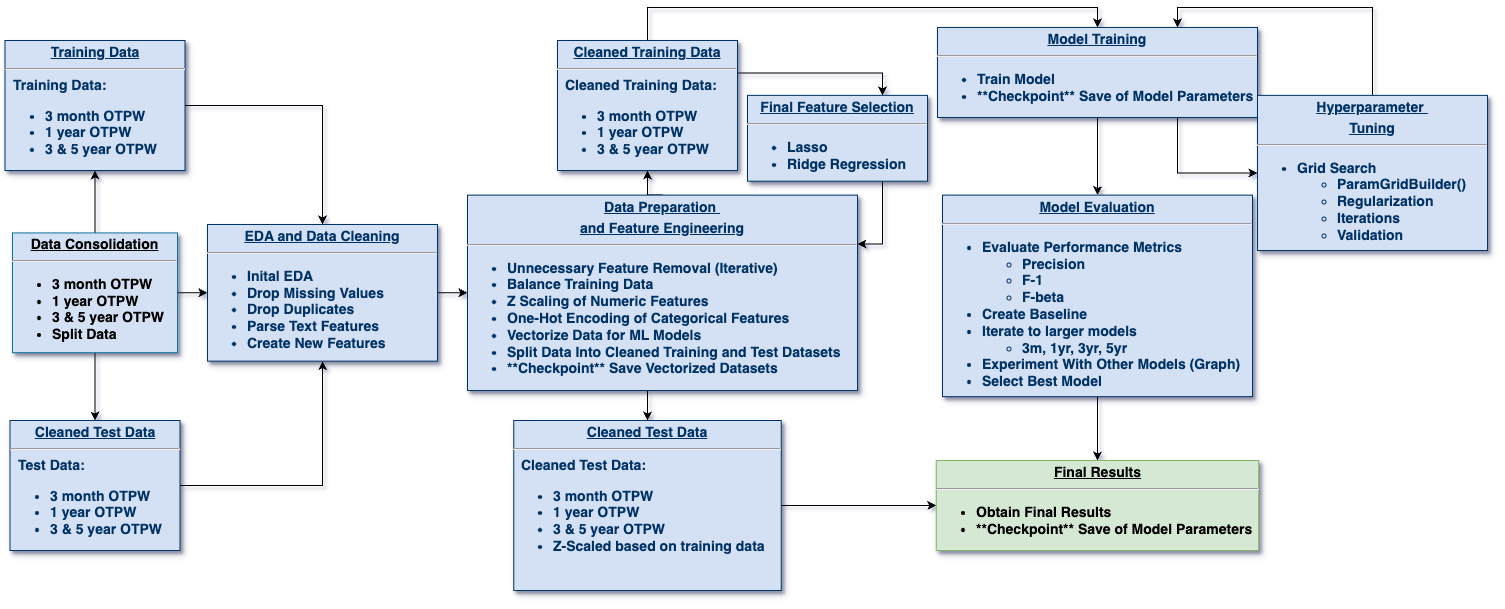

In [0]:
# from IPython.display import display, Image

# image_path = ''
# display(Image(filename=image_path))

###Load Data for Pipeline

####3 Month Data

In [0]:
df_otpw_quarter = spark.read.parquet(f"{team_blob_url}/2015_3m_train")
df_otpw_quarter_test = spark.read.parquet(f"{team_blob_url}/2015_3m_test")

####1 Year Data

In [0]:
df_otpw_1yr = spark.read.parquet(f"{team_blob_url}/2015_1yr_train")
df_otpw_1yr_test = spark.read.parquet(f"{team_blob_url}/2015_1yr_test")

#### Data Handling Summary Visualization

In [0]:
import plotly.express as px
import pandas as pd

stages = ['Total', 'Train Test Split', 'Null Records Dropped', 'Duplicates Dropped', 'Balanced Data']

df_t = pd.DataFrame(dict(number=[5811854, 0, 0, 0, 0], stage=stages))

df_t['Dataset'] = 'Original'

df_mtl = pd.DataFrame(dict(number=[0, 4380612, 1273852, 1273852, 492710], stage=stages))

df_mtl['Dataset'] = 'Train'

df_toronto = pd.DataFrame(dict(number=[0, 1431242, 398545, 398545, 398545], stage=stages))

df_toronto['Dataset'] = 'Test'

df_d = pd.DataFrame(dict(number=[0, 0, 4139457, 4139457, 4920599], stage=stages))

df_d['Dataset'] = 'Dropped Records'

df = pd.concat([df_t, df_mtl, df_toronto, df_d], axis=0)


fig = px.funnel(df, y='number', x='stage', color='Dataset', color_discrete_map = {'Original': 'darkseagreen', 
                                                                                  'Train': 'dodgerblue', 
                                                                                  'Test':'tomato', 
                                                                                  'Dropped Records':'grey'},
               orientation = 'v')

fig.update_layout(
    autosize=False,
    width=1200,
    height=500,
    title = '')



fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=0.7,
    title = ''
))

fig.update_yaxes(title = '')
fig.update_xaxes(title = '')

fig

###Pre-process Data

In [0]:
def Pre_Process_DF(df, balance_flag):    
    # Create clean pipeline
    print('initial size: ' + str(df.count()))

    # Quantify missing Values
    otpw_null_dataframe =  df.select([F.count(F.when(F.col(c).isNull(),c)).alias(c) for c in df.columns])
    row_count_otpw = df.count()
    otpw_null_count_pandas = otpw_null_dataframe.toPandas().transpose().reset_index().rename(columns = {0:'nullCount'})
    otpw_null_count_pandas['percentNull'] = np.round(otpw_null_count_pandas['nullCount'] * 100 / row_count_otpw , 2)
    nonnull_cols_otpw = otpw_null_count_pandas[otpw_null_count_pandas['percentNull'] < 4]['index'].to_list()

    otpw_null_count_pandas.rename(columns={'index': 'Column Name', 'nullCount': 'Number of Null Values', 'percentNull': 'Percentages'}, inplace=True)

    # Drop Columns with Null Percentage >=90%
    drop_df = otpw_null_count_pandas[otpw_null_count_pandas['Percentages'] >= 90]
    df = df.drop(*drop_df['Column Name'].tolist())

    drop_list = [i for i in df.columns if 'Backup' in i]
    drop_list.append('WindEquipmentChangeDate')
    drop_list.append('_row_desc')
    df = df.drop(*drop_list)

    # Parse and clean values
    df = df.withColumn("FL_DATE", F.to_timestamp(df.FL_DATE))
    df = df.withColumn("sched_depart_date_time", F.to_timestamp(df.sched_depart_date_time))
    df = df.withColumn("sched_depart_date_time_UTC", F.to_timestamp(df.sched_depart_date_time_UTC))
    df = df.withColumn("four_hours_prior_depart_UTC", F.to_timestamp(df.four_hours_prior_depart_UTC))
    df = df.withColumn("two_hours_prior_depart_UTC", F.to_timestamp(df.two_hours_prior_depart_UTC))
    df = df.withColumn("DATE", F.to_timestamp(df.DATE))

    # Parsing Steps

    # Hourly Sky Conditions Parsing
    # Helper function to parse the hourlyskyconditions
    def parse_hourlyskyconditions(s):
        # First, check if the string contains the pattern (letters followed by a colon and numbers)
        if re.search(r'\b[A-Z]+:\d+', str(s)):
            # If the pattern is found, extract numbers that are preceded by letters and a colon
            return re.findall(r'\b[A-Z]+:(\d+)', str(s))
        else:
            # If the pattern is not found, the string might be a standalone number
            # Extract the standalone number
            standalone_number = re.findall(r'\b\d+\b', str(s))
            return standalone_number if standalone_number else []

    parse_hourlyskyconditions_udf = udf(parse_hourlyskyconditions, ArrayType(StringType()))

    df = df.withColumn("HourlySkyConditions_Parsed", parse_hourlyskyconditions_udf(df.HourlySkyConditions))

    # Hourly Present Weater Type Parsing
    def parse_hourlyPresentWeatherType(s):
        # This pattern matches sequences of letters that may be followed by a colon and numbers
        pattern = re.compile(r'(?:[+-])?([A-Z]+)')
        if s is None:
            return []
        # Find all matches in the string, and filter out empty strings if any
        return [match for match in pattern.findall(str(s)) if match]

    parse_hourlyPresentWeatherType_udf = udf(parse_hourlyPresentWeatherType, ArrayType(StringType()))

    df = df.withColumn("HourlyPresentWeatherType_Parsed", parse_hourlyPresentWeatherType_udf(df.HourlyPresentWeatherType))

    # Hourly Pressure Tendency Parsing
    def parse_PressureTendency(value):
        if value is None or value == "":
            return None
        # Remove any non-numeric characters except the decimal point
        numeric_value = ''.join(char for char in str(value) if char.isdigit() or char == '.' or char == '-')
        if numeric_value == '9':
            return None
        return numeric_value

    parse_PressureTendency_udf = udf(parse_PressureTendency, StringType())

    df = df.withColumn("HourlyPressureTendency", parse_PressureTendency_udf(df.HourlyPressureTendency))

    # Hourly Wind Direction Parsing
    def parse_doubleToString(value):
        if value is None or value == "":
            return NotImplementedError
        if str(value) == "VRB":
            return "VRB"
        # Remove any non-numeric characters except the decimal point
        numeric_value = ''.join(char for char in str(value) if char.isdigit() or char == '.' or char == '-')
        return numeric_value

    parse_doubleToString_udf = udf(parse_doubleToString, StringType())

    df = df.withColumn("HourlyWindDirection", parse_doubleToString_udf(df.HourlyWindDirection))

    # Parse all other numeric weather columns to double
    def parse_doubleToDouble(value):
        if value is None or value == "":
            return None
        # Remove any non-numeric characters except the decimal point
        numeric_value = ''.join(char for char in str(value) if char.isdigit() or char == '.' or char == '-')
        if len(numeric_value) == 0:
            return None
        # Convert the cleaned string to a float
        try:
            float(numeric_value)
            return float(numeric_value)
        except ValueError:
            return None
            

    parse_doubleToDouble_udf = udf(parse_doubleToDouble, DoubleType())

    #adding is holiday column - only good for 2015
    federal_holidays = [
    '2015-07-04', '2015-12-25', '2015-12-24', '2015-10-12', '2015-04-12',
    '2015-06-19', '2015-09-07', '2015-09-05', '2015-09-06', '2015-01-19',
    '2015-05-25', '2015-01-01', '2015-12-31', '2015-11-26', '2015-11-25',
    '2015-02-14', '2015-11-11', '2015-02-16', '2015-04-05'
]

    def is_holiday(date):
        return 1 if date in federal_holidays else 0
    
    is_holiday_udf = udf(is_holiday, IntegerType())
    df = df.withColumn('is_holiday', is_holiday_udf(df.FL_DATE))

    df = df.withColumn("LATITUDE", parse_doubleToDouble_udf(df.LATITUDE))
    df = df.withColumn("LONGITUDE", parse_doubleToDouble_udf(df.LONGITUDE))
    df = df.withColumn("ELEVATION", parse_doubleToDouble_udf(df.ELEVATION))
    df = df.withColumn("HourlyAltimeterSetting", parse_doubleToDouble_udf(df.HourlyAltimeterSetting))
    df = df.withColumn("HourlyDewPointTemperature", parse_doubleToDouble_udf(df.HourlyDewPointTemperature))
    df = df.withColumn("HourlyDryBulbTemperature", parse_doubleToDouble_udf(df.HourlyDryBulbTemperature))
    df = df.withColumn("HourlyPrecipitation", parse_doubleToDouble_udf(df.HourlyPrecipitation))
    df = df.withColumn("HourlyPressureChange", parse_doubleToDouble_udf(df.HourlyPressureChange))
    df = df.withColumn("HourlyRelativeHumidity", parse_doubleToDouble_udf(df.HourlyRelativeHumidity))
    df = df.withColumn("HourlySeaLevelPressure", parse_doubleToDouble_udf(df.HourlySeaLevelPressure))
    df = df.withColumn("HourlyStationPressure", parse_doubleToDouble_udf(df.HourlyStationPressure))
    df = df.withColumn("HourlyVisibility", parse_doubleToDouble_udf(df.HourlyVisibility))
    df = df.withColumn("HourlyWetBulbTemperature", parse_doubleToDouble_udf(df.HourlyWetBulbTemperature))
    df = df.withColumn("HourlyWindGustSpeed", parse_doubleToDouble_udf(df.HourlyWindGustSpeed))
    df = df.withColumn("HourlyWindSpeed", parse_doubleToDouble_udf(df.HourlyWindSpeed))

    # DEP_DEL15 Parsing
    # Helper function to parse binary columns
    def parse_binary_double(value):
        if value is None:
            return float(1)
        else:
            return float(value)

    parse_binary_double_udf = udf(parse_binary_double, DoubleType())

    df = df.withColumn("DEP_DEL15", parse_binary_double_udf(df.DEP_DEL15))

    # Flight Data Numeric feature Parsing
    df = df.withColumn("DEP_DELAY", parse_doubleToDouble_udf(df.DEP_DELAY))
    df = df.withColumn("DEP_DELAY_NEW", parse_doubleToDouble_udf(df.DEP_DELAY_NEW))
    df = df.withColumn("TAXI_OUT", parse_doubleToDouble_udf(df.TAXI_OUT))
    df = df.withColumn("TAXI_IN", parse_doubleToDouble_udf(df.TAXI_IN))
    df = df.withColumn("ARR_DELAY", parse_doubleToDouble_udf(df.ARR_DELAY))
    df = df.withColumn("ARR_DELAY_NEW", parse_doubleToDouble_udf(df.ARR_DELAY_NEW))
    df = df.withColumn("CRS_ELAPSED_TIME", parse_doubleToDouble_udf(df.CRS_ELAPSED_TIME))
    df = df.withColumn("ACTUAL_ELAPSED_TIME", parse_doubleToDouble_udf(df.ACTUAL_ELAPSED_TIME))
    df = df.withColumn("AIR_TIME", parse_doubleToDouble_udf(df.AIR_TIME))
    df = df.withColumn("FLIGHTS", parse_doubleToDouble_udf(df.FLIGHTS))
    df = df.withColumn("DISTANCE", parse_doubleToDouble_udf(df.DISTANCE))
    df = df.withColumn("CARRIER_DELAY", parse_doubleToDouble_udf(df.CARRIER_DELAY))
    df = df.withColumn("WEATHER_DELAY", parse_doubleToDouble_udf(df.WEATHER_DELAY))
    df = df.withColumn("NAS_DELAY", parse_doubleToDouble_udf(df.NAS_DELAY))
    df = df.withColumn("SECURITY_DELAY", parse_doubleToDouble_udf(df.SECURITY_DELAY))
    df = df.withColumn("LATE_AIRCRAFT_DELAY", parse_doubleToDouble_udf(df.LATE_AIRCRAFT_DELAY))

    ## Feature Selection

    # Weather Feature Selection
    columns_to_zscale = ["CRS_ELAPSED_TIME", "DISTANCE", "ELEVATION", "HourlyAltimeterSetting","HourlyDewPointTemperature", "HourlyDryBulbTemperature","HourlyPrecipitation", "HourlyPressureChange", "HourlyRelativeHumidity", "HourlySeaLevelPressure", "HourlyStationPressure", "HourlyVisibility", "HourlyWetBulbTemperature", "HourlyWindSpeed"]

    df_feature_select = df.dropna(subset = columns_to_zscale)
    print("size after dropping null records: " + str(df_feature_select.count()))

    # Check for duplicates
    dupes_dropped = df_feature_select.dropDuplicates()

    if (df_feature_select.count(), len(df_feature_select.columns)) == (dupes_dropped.count(), len(dupes_dropped.columns)):
        print('No Duplicates found')
    else:
        print(f'{df_feature_select.count() - dupes_dropped.count()} duplicates dropped')
        df_feature_select = dupes_dropped

    print("size after dropping duplicates: " + str(df_feature_select.count()))

    if balance_flag == 1:
        # Balance the data
        major_df = df_feature_select.filter(F.col('DEP_DEL15') == 0)
        minor_df = df_feature_select.filter(F.col('DEP_DEL15') == 1)
        ratio = float(major_df.count() / minor_df.count())
        #print("Unbalanced ratio of No Delays to Delays: {}".format(ratio))
        

        sampled_majority_df = major_df.sample(False, 1/ratio)
        df_feature_select = sampled_majority_df.unionAll(minor_df)
        print("size after balancing: " + str(df_feature_select.count()))


    hourlySkyConditions_list = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']
    hourlyWeatherType_list = ['FG', 'TS', 'PL', 'GR', 'GL', 'DU', 'HZ', 'BLSN', 'FC', 'WIND', 'BLPY', 'BR', 'DZ', 'FZDZ', 'RA', 'FZRA', 'SN', 'UP', "MIFG", 'FZFG']

    for category in hourlySkyConditions_list:
        df_feature_select = df_feature_select.withColumn(f"skyConditions_{category}", array_contains(F.col("HourlySkyConditions_Parsed"), category).cast("int"))

    for category in hourlyWeatherType_list:
        df_feature_select = df_feature_select.withColumn(f"weatherType_{category}", array_contains(F.col("HourlyPresentWeatherType_Parsed"), category).cast("int"))

    df_feature_select = df_feature_select.drop(*['HourlySkyConditions_Parsed', 'HourlyPresentWeatherType_Parsed'])

    return df_feature_select

####3 Month Data

In [0]:
print("3 Months Train Data:")
train_quarter = Pre_Process_DF(df_otpw_quarter, 1)
print("----------------------------------")
print("3 Months Test Data:")
test_quarter = Pre_Process_DF(df_otpw_quarter_test, 0)

3 Months Train Data:
initial size: 897997
size after dropping null records: 243657
No Duplicates found
size after dropping duplicates: 243657
size after balancing: 109358
----------------------------------
3 Months Test Data:
initial size: 503366
size after dropping null records: 144051
No Duplicates found
size after dropping duplicates: 144051


####1 Year Data

In [0]:
print("1 Year Train Data:")
train_1yr = Pre_Process_DF(df_otpw_1yr, 1)
print("----------------------------------")
print("1 Year Test Data:")
test_1yr = Pre_Process_DF(df_otpw_1yr_test, 0)  

1 Year Train Data:
initial size: 4380612
size after dropping null records: 1273852
No Duplicates found
size after dropping duplicates: 1273852
size after balancing: 493371
----------------------------------
1 Year Test Data:
initial size: 1431242
size after dropping null records: 398545
No Duplicates found
size after dropping duplicates: 398545


####Unbalanced 1 Year Data

In [0]:
print("Unbalanced 1 Year Train Data:")
train_1yr_unbalanced = Pre_Process_DF(df_otpw_1yr, 0)

Unbalanced 1 Year Train Data:
initial size: 4380612
size after dropping null records: 1273852
No Duplicates found
size after dropping duplicates: 1273852


###Create Pipeline

In [0]:
def create_pipeline(train_df):
    categorical_features_names = ['STATION', 'HourlyPressureTendency', 'HourlyWindDirection', 'DAY_OF_WEEK','MONTH', 'origin_icao','ORIGIN_STATE_ABR','dest_icao','DEST_STATE_ABR']

    string_indexers = [StringIndexer(inputCol = column, outputCol = f"{column}_Index", handleInvalid = 'keep') for column in categorical_features_names]
    one_hot_encoders = [OneHotEncoder(inputCol = indexer.getOutputCol(), outputCol = f"{column}_Vec") for indexer, column in zip(string_indexers,categorical_features_names)]

    columns_to_zscale = ["CRS_ELAPSED_TIME", "DISTANCE", "ELEVATION", "HourlyAltimeterSetting","HourlyDewPointTemperature", "HourlyDryBulbTemperature","HourlyPrecipitation", "HourlyPressureChange", "HourlyRelativeHumidity", "HourlySeaLevelPressure", "HourlyStationPressure", "HourlyVisibility", "HourlyWetBulbTemperature", "HourlyWindSpeed"]

    scaler_assembler = VectorAssembler(inputCols = columns_to_zscale, outputCol = "features_to_zscale", handleInvalid = "keep")
    scaler = StandardScaler(withMean=True, inputCol = scaler_assembler.getOutputCol(), outputCol = "scaled_numeric_features")

    hourlySkyConditions_list = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']
    hourlyWeatherType_list = ['FG', 'TS', 'PL', 'GR', 'GL', 'DU', 'HZ', 'BLSN', 'FC', 'WIND', 'BLPY', 'BR', 'DZ', 'FZDZ', 'RA', 'FZRA', 'SN', 'UP', "MIFG", 'FZFG']

    final_features_list = [f"{name}_Vec" for name in categorical_features_names]
    final_features_list.append("scaled_numeric_features")
    final_features_list.append('is_holiday')

    for i in hourlySkyConditions_list:
        final_features_list.append(f"skyConditions_{i}")
    for i in hourlyWeatherType_list:
        final_features_list.append(f"weatherType_{i}")

    final_assembler = VectorAssembler(inputCols = final_features_list, outputCol="final_features")

    stages = string_indexers + one_hot_encoders
    stages.append(scaler_assembler)
    stages.append(scaler)
    stages.append(final_assembler)

    regression_pipeline = Pipeline(stages = stages)

    pipeline_model = regression_pipeline.fit(train_df)
    # transform the data
    transformed_train= pipeline_model.transform(train_df)
    
    return transformed_train, pipeline_model

In [0]:
def create_pipeline_w_feature_select(train_df):
    
    columns_to_zscale = ["CRS_ELAPSED_TIME", "DISTANCE", "ELEVATION", "HourlyAltimeterSetting","HourlyDewPointTemperature", "HourlyDryBulbTemperature","HourlyPrecipitation", "HourlyPressureChange", "HourlyRelativeHumidity", "HourlySeaLevelPressure", "HourlyStationPressure", "HourlyVisibility", "HourlyWetBulbTemperature", "HourlyWindSpeed"]

    scaler_assembler = VectorAssembler(inputCols = columns_to_zscale, outputCol = "features_to_zscale", handleInvalid = "keep")
    scaler = StandardScaler(withMean=True, inputCol = scaler_assembler.getOutputCol(), outputCol = "scaled_numeric_features")

    ridge = LinearRegression(featuresCol = 'scaled_numeric_features', labelCol = 'DEP_DEL15', maxIter = 50, elasticNetParam = 0, regParam = 0.1)

    ridge_stages = [scaler_assembler]
    ridge_stages.append(scaler)
    ridge_stages.append(ridge)

    ridge_pipeline = Pipeline(stages = ridge_stages)

    ridge_model = ridge_pipeline.fit(train_df)

    coefficients = ridge_model.stages[-1].coefficients.toArray()
    coef_df = pd.DataFrame(list(zip(columns_to_zscale, coefficients)), columns = ['Feature', 'Coefficient'])
    coef_df.sort_values(by = ['Coefficient'], key = abs, ascending = False, inplace = True)
    feature_list = coef_df.Feature.tolist()
    selected_features = feature_list[:5]

    print('selected numeric features:')
    print(selected_features)

    scaler_assembler = VectorAssembler(inputCols = selected_features, outputCol = "features_to_zscale", handleInvalid = "keep")
    scaler = StandardScaler(withMean=True, inputCol = scaler_assembler.getOutputCol(), outputCol = "scaled_numeric_features")

    categorical_features_names = ['HourlyPressureTendency', 'HourlyWindDirection', 'DAY_OF_WEEK','MONTH', 'origin_icao','ORIGIN_STATE_ABR','dest_icao','DEST_STATE_ABR']

    string_indexers = [StringIndexer(inputCol = column, outputCol = f"{column}_Index", handleInvalid = 'keep') for column in categorical_features_names]
    one_hot_encoders = [OneHotEncoder(inputCol = indexer.getOutputCol(), outputCol = f"{column}_Vec") for indexer, column in zip(string_indexers,categorical_features_names)]

    hourlySkyConditions_list = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']
    hourlyWeatherType_list = ['FG', 'TS', 'PL', 'GR', 'GL', 'DU', 'HZ', 'BLSN', 'FC', 'WIND', 'BLPY', 'BR', 'DZ', 'FZDZ', 'RA', 'FZRA', 'SN', 'UP', "MIFG", 'FZFG']

    hourlySkyCols = []
    for i in hourlySkyConditions_list:
        hourlySkyCols.append(f"skyConditions_{i}")

    hourlyWeatherCols = []
    for i in hourlyWeatherType_list:
        hourlyWeatherCols.append(f"weatherType_{i}")

    sky_condition_assembler = VectorAssembler(inputCols = hourlySkyCols, outputCol = "hourly_sky_conditions", handleInvalid = "keep")
    weather_type_assembler = VectorAssembler(inputCols = hourlyWeatherCols, outputCol = "hourly_weather_type", handleInvalid = "keep")

    final_features_list = [f"{name}_Vec" for name in categorical_features_names]
    final_features_list.append('scaled_numeric_features')
    final_features_list.append('is_holiday')
    final_features_list.append('hourly_sky_conditions')
    final_features_list.append('hourly_weather_type')

    final_assembler = VectorAssembler(inputCols = final_features_list, outputCol = "final_features")

    stages = string_indexers + one_hot_encoders
    stages.append(scaler_assembler)
    stages.append(scaler)
    stages.append(sky_condition_assembler)
    stages.append(weather_type_assembler)
    stages.append(final_assembler)

    regression_pipeline = Pipeline(stages = stages)
    
    pipeline_model = regression_pipeline.fit(train_df)
    # transform the data
    transformed_train = pipeline_model.transform(train_df)
    
    return transformed_train, pipeline_model

####3 Month Data

In [0]:
print("3 Month Data")
transformed_train_quarter, transformed_pipeline = create_pipeline(train_quarter)
transformed_test_quarter = transformed_pipeline.transform(test_quarter)

3 Month Data


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

####3 Month Data with Feature Selection

In [0]:
print("3 Month Data with Feature Selection")
transformed_train_quarter_selected, transformed_pipeline_selected = create_pipeline_w_feature_select(train_quarter)
transformed_test_quarter_selected = transformed_pipeline_selected.transform(test_quarter)

3 Month Data with Feature Selection


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

selected numeric features:
['HourlyRelativeHumidity', 'HourlyDryBulbTemperature', 'HourlyWetBulbTemperature', 'HourlyWindSpeed', 'HourlyDewPointTemperature']


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

####1 Year Data

In [0]:
print("1 Year Data")
transformed_train_1yr, transformed_pipeline_1yr = create_pipeline(train_1yr)
transformed_test_1yr = transformed_pipeline_1yr.transform(test_1yr)

1 Year Data


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

####1 Year Data with Feature Selection

In [0]:
print("1 Year Data with Feature Selection")
transformed_train_1yr_selected, transformed_pipeline_1yr_selected = create_pipeline_w_feature_select(train_1yr)
transformed_test_1yr_selected = transformed_pipeline_1yr_selected.transform(test_1yr)

1 Year Data with Feature Selection


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

selected numeric features:
['HourlyRelativeHumidity', 'HourlyDryBulbTemperature', 'HourlyWindSpeed', 'HourlyWetBulbTemperature', 'HourlyAltimeterSetting']


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

####Unbalanced 1 Year Data

In [0]:
print("Unbalanced 1 Year Data")
transformed_train_1yr_unbalanced, transformed_pipeline_1yr_unbalanced = create_pipeline(train_1yr_unbalanced)
transformed_test_1yr_unbalanced = transformed_pipeline_1yr_unbalanced.transform(test_1yr)

Unbalanced 1 Year Data


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

####Unbalanced 1 Year Data with Feature Selection

In [0]:
print("Unbalanced 1 Year Data with Feature Selection")
transformed_train_1yr_unbalanced_selected, transformed_pipeline_1yr_unbalanced_selected = create_pipeline_w_feature_select(train_1yr_unbalanced)
transformed_test_1yr_unbalanced_selected = transformed_pipeline_1yr_unbalanced_selected.transform(test_1yr)

Unbalanced 1 Year Data with Feature Selection


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

selected numeric features:
['HourlyRelativeHumidity', 'HourlyDryBulbTemperature', 'HourlyWindSpeed', 'HourlyWetBulbTemperature', 'HourlyAltimeterSetting']


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

#Modeling And Results

###Create Logistic Regression Model

In [0]:
def createLRModel(df, iterations= 10):
    '''
    takes the traindf and produces a logistic regression model
    '''
    lr = LogisticRegression(featuresCol = 'final_features' , labelCol = 'DEP_DEL15', maxIter=iterations)
    lrModel = lr.fit(df)

    # Print the coefficients and intercept for logistic regression
    print("Coefficients: " + str(lrModel.coefficients))
    print("Intercept: " + str(lrModel.intercept))

    return lrModel

####3 Month Data

In [0]:
print("3 Month Data")
train_quarter_balance_lrmodel = createLRModel(transformed_train_quarter)
trainingSummary_balance = train_quarter_balance_lrmodel.summary

3 Month Data


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Coefficients: [-0.0616311798265122,-0.10308837851659149,0.10335708937646568,0.05559858905430236,0.11677824495581114,0.23267083300127359,0.10216267181401632,0.2962959288848246,0.18084839513397172,0.10971408456903554,0.041769512037168735,-0.09286616994108299,-0.0622856545544734,-0.026870713262601237,-0.14591718830585534,-0.06148044093945529,-0.3095254206050996,0.29130576314962153,-0.16322985813987217,-0.18146268205800145,0.08385506120498218,-0.05636205341352939,0.264381998209632,-0.4082785156445402,0.060745805317556446,0.4972062343163322,-0.0763328261188359,-0.130311511657655,0.15545489079322172,-0.10901393578231709,-0.13456366710250203,-0.101993605086944,0.16159989475467657,0.007839267189934704,0.09259343489004662,0.0023958959955063053,-0.2604559778068632,0.5132618563974654,-0.09710998915660915,0.021935171531669427,0.2114303049524007,-0.06363656248417045,-0.24948577447525963,0.2782123598946224,-0.15654525194777752,-0.3897628743071228,0.04459759130303905,-0.16690447774082678,-0.142243112

####3 Month Data with Feature Selection

In [0]:
print("3 Month Data with Feature Selection")
train_quarter_selected_lrmodel = createLRModel(transformed_train_quarter_selected)
trainingSummary_selected = train_quarter_selected_lrmodel.summary

3 Month Data with Feature Selection


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Coefficients: [-0.11288649738518008,0.04677432865071366,-0.052883295601613325,0.11010968391500896,0.18294170118855316,-0.10871306374270233,0.002236376073739537,0.03738768274517956,-0.04655141281035854,0.04428133455836615,0.16984050088453617,0.11691375162321568,0.007952419670665319,0.17591360308395276,0.11832025965675876,0.09451044505930165,0.014975781151300167,-0.04241043598051555,0.179140381349855,-0.16201677502506368,0.11284529429937591,0.03805010145390786,-0.08405671262465639,-0.03748958615253454,-0.0177517544042697,0.05947442676924928,-0.18326514132479965,-0.13541558841518805,-0.11168412595872097,0.04575875005308182,-0.03443674490076374,-0.11311399542848946,-0.10819322709292488,-0.06844027641859758,0.0036664457653203812,-0.03341924844412984,-0.13019540621035305,0.008390977946548696,-0.19330325185182923,-0.0773427326425514,-0.0830661475497612,-0.08461559322209788,-0.11267188171048266,-0.11600524603621158,0.06717969087124073,-0.04984491437059559,-0.15795883063706778,-0.10429088283778

####1 Year Data

In [0]:
print("1 Year Train Data:")
train_1yr_balance_lrmodel = createLRModel(transformed_train_1yr)
trainingSummary_balance_1yr = train_1yr_balance_lrmodel.summary

1 Year Train Data:


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Coefficients: [0.08112045408238566,-0.012378994962686454,0.10143004800583325,0.04884878571921341,0.031176999204851806,0.13954928561248034,0.06903486877563075,0.17924515190997528,-0.06513195136240127,0.09065306590137122,-0.13661274127457051,0.12710533960809126,0.053772762970268624,-0.12163655328489877,-0.1258910388114349,-0.0668036279173549,-0.03004797978006758,0.12835951330101672,-0.1007570093472916,0.19680608679074665,0.12263218347459179,0.048227488767562415,-0.0003445904846827541,-0.02725834411995259,-0.06192670265396767,0.033709107903202966,0.05473212705198742,0.10139145991910363,0.14340910953175712,-0.04555958075199271,0.06676871763873031,0.019437330754210003,-0.17213022526508714,-0.09511426660223739,-0.016894585248780278,-0.11188455234561254,-0.04358061728337111,-0.01000328963644488,-0.1631092030241081,-0.021780734434187068,-0.1291784567079837,-0.13196144369973353,-0.12270223035519594,-0.10684681659136704,0.08041358513992262,-0.03270619000081778,-0.15892230792893838,-0.04259613705

####1 Year Data with Feature Selection

In [0]:
print("1 Year Train Data with Feature Selection:")
train_1yr_balance_lrmodel_selected = createLRModel(transformed_train_1yr_selected)
trainingSummary_balance_1yr_selected = train_1yr_balance_lrmodel_selected.summary

1 Year Train Data with Feature Selection:


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Coefficients: [-0.09547436956702478,0.04161210445792995,0.13724284573070186,-0.08744484487089968,-0.16686129723211254,0.22696896851897233,0.07750969669255676,-0.04469707228368055,-0.2276304258001339,0.0013710672707686771,-0.1571709611169765,-0.007557397973044782,0.008544983599987777,0.08732625714951785,0.022594132918465536,-0.013965604440410891,0.041914208060685895,-0.011100638504418626,0.01717649945452458,0.02845516541582278,-0.0012650675460592314,-0.0009841021993641402,0.08016980479115812,0.04150190649459141,-0.00810617033174147,0.0677160006948205,-0.02952231818536852,0.07588016285668638,-0.006943946109003097,0.02675469355483719,0.07243447626623221,-0.0132811661039176,0.009094042913069662,0.005117996188829623,0.049636267409645,-0.07125491675074233,-0.006660958268537029,0.05736046894781893,-0.02691604426275279,0.011567244593212232,-0.047115040421595325,-0.1042918272721031,-0.041658029539918526,-0.08411877014327135,0.01723971464271435,-0.043418621297789624,-0.06717727004716381,0.0,0.0,

####Unbalanced 1 Year Data

In [0]:
print("Unbalanced 1 Year Train Data:")
train_1yr_unbalanced_lrmodel = createLRModel(transformed_train_1yr_unbalanced)
trainingSummary_unbalanced_1yr = train_1yr_unbalanced_lrmodel.summary

Unbalanced 1 Year Train Data:


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Coefficients: [0.0018826521454798632,0.08858004054272897,0.10699011183842219,0.06340489341551692,0.021797382232437473,0.15071843424731973,0.08805288332156372,-0.06423380553569734,0.1847487928359475,-0.13162427609585653,-0.12009047511246326,0.09719897505780475,0.051618344887850366,-0.11617896672793032,-0.0668376421126926,0.14957822697333814,-0.10373502355006942,-0.028333584007500214,0.12942312884424356,0.2090393328774138,0.016116070889727975,0.12636715974240215,-0.02731117750440672,0.07713488552976504,-0.04517656781224025,0.03399270169730178,0.06080949314705495,0.12037106198180837,-0.17684350792869452,-0.0255590437849294,0.1591532235523658,-0.09020094643287556,0.030429623256518403,0.0774525980254316,-0.011091446593400809,-0.1702311716251637,-0.10023884378610451,-0.017110683191055527,-0.01253703892466182,-0.12070943986204333,-0.12987347852849343,-0.01866627680085465,-0.11202757714262429,-0.09969493752474733,-0.15521120340412037,-0.020783522384906612,-0.11249757791718021,-0.04530192697399

####Unbalanced 1 Year Data with Feature Selection

In [0]:
print("Unbalanced 1 Year Train Data with Feature Selection:")
train_1yr_unbalanced_lrmodel_selected = createLRModel(transformed_train_1yr_unbalanced_selected)
trainingSummary_unbalanced_1yr_selected = train_1yr_unbalanced_lrmodel_selected.summary

Unbalanced 1 Year Train Data with Feature Selection:


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Coefficients: [-0.08506513891661714,0.037159051992289756,0.13986712722849193,-0.08647180394026834,-0.16365341898220204,0.23005022412209838,0.0984037809177131,-0.06132593293321411,-0.11445669457741615,0.005675717885651082,-0.14509762695543416,-0.010187156749921624,0.005186700974066498,0.058086805784715416,-0.022278408879807608,0.02416777039412063,0.03781297815795091,-0.040351869537328555,0.037564695148543215,0.03129761963671797,0.012133470975294035,0.01476194287717579,0.014053097808820726,0.06811278313839246,-0.029293595424948582,0.056127605281959904,0.0037402044367451353,0.08059997429793912,-0.007302557156340294,0.02304749837179331,0.06656934312460953,-0.018684064176921433,0.021680459876871033,0.037365128082716324,-0.04776296514050499,0.05849065987331736,0.04273292756189491,0.008709262725209511,-0.02797255358718,-0.0071993186556503115,-0.09787024074525233,-0.00418774872855849,-0.04469624010181528,-0.07610998421551272,-0.07129103185811564,-0.04322984667296917,0.027108020501907235,0.0,0.

###Logistic Regression Train Results

In [0]:
def evaluate_model(model_prediction, beta=1.0):
    # Convert DataFrame to RDD
    prediction_and_label = model_prediction.select(["prediction", "DEP_DEL15"]).withColumn('DEP_DEL15', col('DEP_DEL15').cast(FloatType())).orderBy('DEP_DEL15')

    # Create MulticlassMetrics object
    metrics = MulticlassMetrics(prediction_and_label.rdd.map(tuple))

    return metrics.accuracy, metrics.precision(1.0), metrics.recall(1.0), metrics.fMeasure(1.0), metrics.fMeasure(1.0, beta=beta)

####3 Month Data

In [0]:
lr_train_predictions_balance = train_quarter_balance_lrmodel.transform(transformed_train_quarter)

balance_acc, balance_pre, balance_recall, balance_f1, balance_f1_b = evaluate_model(lr_train_predictions_balance, 1.0)

print("3 Month Data Train Results")
#print(f"Accuracy: {balance_acc:.4f}")
print(f"Precision: {balance_pre:.4f}")
print(f"Recall: {balance_recall:.4f}")
print(f"F-1: {balance_f1:.4f}")
print(f"F-1 Beta: {balance_f1_b:.4f}")

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


3 Month Data Train Results
Precision: 0.6277
Recall: 0.6159
F-1: 0.6218
F-1 Beta: 0.6218


####3 Month Data with Feature Selection

In [0]:
lr_train_predictions_selected = train_quarter_selected_lrmodel.transform(transformed_train_quarter_selected)

balance_acc, balance_pre, balance_recall, balance_f1, balance_f1_b = evaluate_model(lr_train_predictions_selected, 1.0)

print("3 Month Data with Feature Selection Train Results")
#print(f"Accuracy: {balance_acc:.4f}")
print(f"Precision: {balance_pre:.4f}")
print(f"Recall: {balance_recall:.4f}")
print(f"F-1: {balance_f1:.4f}")
print(f"F-1 Beta: {balance_f1_b:.4f}")

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



3 Month Data with Feature Selection Train Results
Precision: 0.6271
Recall: 0.6083
F-1: 0.6176
F-1 Beta: 0.6176


####1 Year Data

In [0]:
lr_train_predictions_balance_1yr = train_1yr_balance_lrmodel.transform(transformed_train_1yr)

balance_acc, balance_pre, balance_recall, balance_f1, balance_f1_b = evaluate_model(lr_train_predictions_balance_1yr, 1.0)

print("1 Year Data Train Results")
#print(f"Accuracy: {balance_acc:.4f}")
print(f"Precision: {balance_pre:.4f}")
print(f"Recall: {balance_recall:.4f}")
print(f"F-1: {balance_f1:.4f}")
print(f"F-1 Beta: {balance_f1_b:.4f}")

1 Year Data Train Results
Precision: 0.5972
Recall: 0.6059
F-1: 0.6015
F-1 Beta: 0.6015


####1 Year Data with Feature Selection

In [0]:
lr_train_predictions_balance_1yr_selected = train_1yr_balance_lrmodel_selected.transform(transformed_train_1yr_selected)

balance_acc, balance_pre, balance_recall, balance_f1, balance_f1_b = evaluate_model(lr_train_predictions_balance_1yr_selected, 1.0)

print("1 Year Data with Feature Selection Train Results")
#print(f"Accuracy: {balance_acc:.4f}")
print(f"Precision: {balance_pre:.4f}")
print(f"Recall: {balance_recall:.4f}")
print(f"F-1: {balance_f1:.4f}")
print(f"F-1 Beta: {balance_f1_b:.4f}")


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



1 Year Data with Feature Selection Train Results
Precision: 0.5961
Recall: 0.6085
F-1: 0.6022
F-1 Beta: 0.6022


####Unbalanced 1 Year Data

In [0]:
lr_train_predictions_unbalanced_1yr = train_1yr_unbalanced_lrmodel.transform(transformed_train_1yr_unbalanced)

balance_acc, balance_pre, balance_recall, balance_f1, balance_f1_b = evaluate_model(lr_train_predictions_unbalanced_1yr, 1.0)

print("Unbalanced 1 Year Data Train Results")
#print(f"Accuracy: {balance_acc:.4f}")
print(f"Precision: {balance_pre:.4f}")
print(f"Recall: {balance_recall:.4f}")
print(f"F-1: {balance_f1:.4f}")
print(f"F-1 Beta: {balance_f1_b:.4f}")

Unbalanced 1 Year Data Train Results
Precision: 0.6049
Recall: 0.0099
F-1: 0.0194
F-1 Beta: 0.0194


####Unbalanced 1 Year Data with Feature Selection

In [0]:
lr_train_predictions_unbalanced_1yr_selected = train_1yr_unbalanced_lrmodel_selected.transform(transformed_train_1yr_unbalanced_selected)

balance_acc, balance_pre, balance_recall, balance_f1, balance_f1_b = evaluate_model(lr_train_predictions_unbalanced_1yr_selected, 1.0)

print("Unbalanced 1 Year Data with Feature Selection Train Results")
#print(f"Accuracy: {balance_acc:.4f}")
print(f"Precision: {balance_pre:.4f}")
print(f"Recall: {balance_recall:.4f}")
print(f"F-1: {balance_f1:.4f}")
print(f"F-1 Beta: {balance_f1_b:.4f}")

Unbalanced 1 Year Data with Feature Selection Train Results
Precision: 0.6078
Recall: 0.0099
F-1: 0.0194
F-1 Beta: 0.0194


###Logistic Regression Test Results

####3 Month Data

In [0]:
lr_predictions_balance = train_quarter_balance_lrmodel.transform(transformed_test_quarter)

balance_acc, balance_pre, balance_recall, balance_f1, balance_f1_b = evaluate_model(lr_predictions_balance, 1.0)

print("3 Month Data Test Results")
#print(f"Accuracy: {balance_acc:.4f}")
print(f"Precision: {balance_pre:.4f}")
print(f"Recall: {balance_recall:.4f}")
print(f"F-1: {balance_f1:.4f}")
print(f"F-1 Beta: {balance_f1_b:.4f}")

3 Month Data Test Results
Precision: 0.2966
Recall: 0.3603
F-1: 0.3253
F-1 Beta: 0.3253


####3 Month Data with Feature Selection

In [0]:
lr_test_predictions_selected = train_quarter_selected_lrmodel.transform(transformed_test_quarter_selected)

balance_acc, balance_pre, balance_recall, balance_f1, balance_f1_b = evaluate_model(lr_test_predictions_selected, 1.0)

print("3 Month Data with Feature Selection Test Results")
#print(f"Accuracy: {balance_acc:.4f}")
print(f"Precision: {balance_pre:.4f}")
print(f"Recall: {balance_recall:.4f}")
print(f"F-1: {balance_f1:.4f}")
print(f"F-1 Beta: {balance_f1_b:.4f}")

3 Month Data with Feature Selection Test Results
Precision: 0.2957
Recall: 0.3602
F-1: 0.3248
F-1 Beta: 0.3248


####1 Year Data

In [0]:
lr_predictions_balance_1yr = train_1yr_balance_lrmodel.transform(transformed_test_1yr)

balance_acc, balance_pre, balance_recall, balance_f1, balance_f1_b = evaluate_model(lr_predictions_balance_1yr, 1.0)

print("1 Year Data Test Results")
#print(f"Accuracy: {balance_acc:.4f}")
print(f"Precision: {balance_pre:.4f}")
print(f"Recall: {balance_recall:.4f}")
print(f"F-1: {balance_f1:.4f}")
print(f"F-1 Beta: {balance_f1_b:.4f}")

1 Year Data Test Results
Precision: 0.1938
Recall: 0.6878
F-1: 0.3024
F-1 Beta: 0.3024


####1 Year Data with Feature Selection

In [0]:
lr_predictions_balance_1yr_selected = train_1yr_balance_lrmodel_selected.transform(transformed_test_1yr_selected)

balance_acc, balance_pre, balance_recall, balance_f1, balance_f1_b = evaluate_model(lr_predictions_balance_1yr_selected, 1.0)

print("1 Year Data with Feature Selection Test Results")
#print(f"Accuracy: {balance_acc:.4f}")
print(f"Precision: {balance_pre:.4f}")
print(f"Recall: {balance_recall:.4f}")
print(f"F-1: {balance_f1:.4f}")
print(f"F-1 Beta: {balance_f1_b:.4f}")

1 Year Data with Feature Selection Test Results
Precision: 0.1931
Recall: 0.6896
F-1: 0.3017
F-1 Beta: 0.3017


####Unbalanced 1 Year Data

In [0]:
lr_predictions_unbalanced_1yr = train_1yr_unbalanced_lrmodel.transform(transformed_test_1yr_unbalanced)

balance_acc, balance_pre, balance_recall, balance_f1, balance_f1_b = evaluate_model(lr_predictions_unbalanced_1yr, 1.0)

print("Unbalanced 1 Year Data Test Results")
#print(f"Accuracy: {balance_acc:.4f}")
print(f"Precision: {balance_pre:.4f}")
print(f"Recall: {balance_recall:.4f}")
print(f"F-1: {balance_f1:.4f}")
print(f"F-1 Beta: {balance_f1_b:.4f}")

Unbalanced 1 Year Data Test Results
Precision: 0.5645
Recall: 0.0104
F-1: 0.0204
F-1 Beta: 0.0204


####Unbalanced 1 Year Data with Feature Selection

In [0]:
lr_predictions_unbalanced_1yr_selected = train_1yr_unbalanced_lrmodel_selected.transform(transformed_test_1yr_unbalanced_selected)

balance_acc, balance_pre, balance_recall, balance_f1, balance_f1_b = evaluate_model(lr_predictions_unbalanced_1yr_selected, 1.0)

print("Unbalanced 1 Year Data with Feature Selection Test Results")
#print(f"Accuracy: {balance_acc:.4f}")
print(f"Precision: {balance_pre:.4f}")
print(f"Recall: {balance_recall:.4f}")
print(f"F-1: {balance_f1:.4f}")
print(f"F-1 Beta: {balance_f1_b:.4f}")

Unbalanced 1 Year Data with Feature Selection Test Results
Precision: 0.5803
Recall: 0.0105
F-1: 0.0207
F-1 Beta: 0.0207


###Cross-Validation

####Fit Cross Validation Models

In [0]:
lr = LogisticRegression(featuresCol = 'final_features' , labelCol = 'DEP_DEL15', maxIter=10)

paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.1, 0.5, 1.0, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0])
             .addGrid(lr.maxIter, [5, 10, 20, 50])
             .build())

crossval = CrossValidator(estimator = lr,
                          estimatorParamMaps = paramGrid,
                          evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="DEP_DEL15"),
                          numFolds = 5)

# Run cross-validation, and choose the best set of parameters.
cv_balanced = crossval.fit(transformed_train_1yr)

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

In [0]:
lr = LogisticRegression(featuresCol = 'final_features' , labelCol = 'DEP_DEL15', maxIter=10)

paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.1, 0.5, 1.0, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0])
             .addGrid(lr.maxIter, [5, 10, 20, 50])
             .build())

crossval = CrossValidator(estimator = lr,
                          estimatorParamMaps = paramGrid,
                          evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="DEP_DEL15"),
                          numFolds = 5)

# Run cross-validation, and choose the best set of parameters.
cv_balanced_selected = crossval.fit(transformed_train_1yr_selected)

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

In [0]:
lr = LogisticRegression(featuresCol = 'final_features' , labelCol = 'DEP_DEL15', maxIter=10)

paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.1, 0.5, 1.0, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0])
             .addGrid(lr.maxIter, [5, 10, 20, 50])
             .build())

crossval = CrossValidator(estimator = lr,
                          estimatorParamMaps = paramGrid,
                          evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="DEP_DEL15"),
                          numFolds = 5)

# Run cross-validation, and choose the best set of parameters.
cv_unbalanced = crossval.fit(transformed_train_1yr_unbalanced)

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

In [0]:
lr = LogisticRegression(featuresCol = 'final_features' , labelCol = 'DEP_DEL15', maxIter=10)

paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.1, 0.5, 1.0, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0])
             .addGrid(lr.maxIter, [5, 10, 20, 50])
             .build())

crossval = CrossValidator(estimator = lr,
                          estimatorParamMaps = paramGrid,
                          evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="DEP_DEL15"),
                          numFolds = 5)

# Run cross-validation, and choose the best set of parameters.
cv_unbalanced_selected = crossval.fit(transformed_train_1yr_unbalanced_selected)

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

####Cross-Validation Train Results

In [0]:
cross_valid_train_prediction = cv_balanced.transform(transformed_train_1yr)

cross_acc, cross_pre, cross_recall, cross_f1, cross_f1_b = evaluate_model(cross_valid_train_prediction, 1.0)

print("1 Year Data Cross Validation Train Results")
#print(f"Accuracy: {cross_acc:.4f}")
print(f"Precision: {cross_pre:.4f}")
print(f"Recall: {cross_recall:.4f}")
print(f"F-1: {cross_f1:.4f}")
print(f"F-1 Beta: {cross_f1_b:.4f}")

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



1 Year Data Cross Validation Train Results
Precision: 0.5969
Recall: 0.6070
F-1: 0.6019
F-1 Beta: 0.6019


In [0]:
cross_valid_train_prediction_selected = cv_balanced_selected.transform(transformed_train_1yr_selected)

cross_acc, cross_pre, cross_recall, cross_f1, cross_f1_b = evaluate_model(cross_valid_train_prediction_selected, 1.0)

print("1 Year Data with Feature Selection Cross Validation Train Results")
#print(f"Accuracy: {cross_acc:.4f}")
print(f"Precision: {cross_pre:.4f}")
print(f"Recall: {cross_recall:.4f}")
print(f"F-1: {cross_f1:.4f}")
print(f"F-1 Beta: {cross_f1_b:.4f}")

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



1 Year Data with Feature Selection Cross Validation Train Results
Precision: 0.5512
Recall: 0.4665
F-1: 0.5053
F-1 Beta: 0.5053


In [0]:
cross_valid_train_prediction_unbalanced = cv_unbalanced.transform(transformed_train_1yr_unbalanced)

cross_acc, cross_pre, cross_recall, cross_f1, cross_f1_b = evaluate_model(cross_valid_train_prediction_unbalanced, 1.0)

print("Unbalanced 1 Year Data Cross Validation Train Results")
#print(f"Accuracy: {cross_acc:.4f}")
print(f"Precision: {cross_pre:.4f}")
print(f"Recall: {cross_recall:.4f}")
print(f"F-1: {cross_f1:.4f}")
print(f"F-1 Beta: {cross_f1_b:.4f}")

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



Unbalanced 1 Year Data Cross Validation Train Results
Precision: 0.6150
Recall: 0.0088
F-1: 0.0174
F-1 Beta: 0.0174


In [0]:
cross_valid_train_prediction_unbalanced_selected = cv_unbalanced_selected.transform(transformed_train_1yr_unbalanced_selected)

cross_acc, cross_pre, cross_recall, cross_f1, cross_f1_b = evaluate_model(cross_valid_train_prediction_unbalanced_selected, 1.0)

print("Unbalanced 1 Year Data with Feature Selection Cross Validation Train Results")
#print(f"Accuracy: {cross_acc:.4f}")
print(f"Precision: {cross_pre:.4f}")
print(f"Recall: {cross_recall:.4f}")
print(f"F-1: {cross_f1:.4f}")
print(f"F-1 Beta: {cross_f1_b:.4f}")

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



Unbalanced 1 Year Data with Feature Selection Cross Validation Train Results
Precision: 0.5630
Recall: 0.0066
F-1: 0.0130
F-1 Beta: 0.0130


####Cross-Validation Test Results

In [0]:
cross_valid_test_prediction = cv_balanced.transform(transformed_test_1yr)

cross_acc, cross_pre, cross_recall, cross_f1, cross_f1_b = evaluate_model(cross_valid_test_prediction, 1.0)

print("1 Year Data Cross Validation Test Results")
#print(f"Accuracy: {cross_acc:.4f}")
print(f"Precision: {cross_pre:.4f}")
print(f"Recall: {cross_recall:.4f}")
print(f"F-1: {cross_f1:.4f}")
print(f"F-1 Beta: {cross_f1_b:.4f}")

1 Year Data Cross Validation Test Results
Precision: 0.1944
Recall: 0.6806
F-1: 0.3024
F-1 Beta: 0.3024


In [0]:
cross_valid_test_prediction_selected = cv_balanced_selected.transform(transformed_test_1yr_selected)

cross_acc, cross_pre, cross_recall, cross_f1, cross_f1_b = evaluate_model(cross_valid_test_prediction_selected, 1.0)

print("1 Year Data with Feature Selection Cross Validation Test Results")
#print(f"Accuracy: {cross_acc:.4f}")
print(f"Precision: {cross_pre:.4f}")
print(f"Recall: {cross_recall:.4f}")
print(f"F-1: {cross_f1:.4f}")
print(f"F-1 Beta: {cross_f1_b:.4f}")

1 Year Data with Feature Selection Cross Validation Test Results
Precision: 0.1862
Recall: 0.5706
F-1: 0.2808
F-1 Beta: 0.2808


In [0]:
cross_valid_test_prediction_unbalanced = cv_unbalanced.transform(transformed_test_1yr_unbalanced)

cross_acc, cross_pre, cross_recall, cross_f1, cross_f1_b = evaluate_model(cross_valid_test_prediction_unbalanced, 1.0)

print("Unbalanced 1 Year Data Cross Validation Test Results")
#print(f"Accuracy: {cross_acc:.4f}")
print(f"Precision: {cross_pre:.4f}")
print(f"Recall: {cross_recall:.4f}")
print(f"F-1: {cross_f1:.4f}")
print(f"F-1 Beta: {cross_f1_b:.4f}")

Unbalanced 1 Year Data Cross Validation Test Results
Precision: 0.5991
Recall: 0.0083
F-1: 0.0164
F-1 Beta: 0.0164


In [0]:
cross_valid_test_prediction_unbalanced_selected = cv_unbalanced_selected.transform(transformed_test_1yr_unbalanced_selected)

cross_acc, cross_pre, cross_recall, cross_f1, cross_f1_b = evaluate_model(cross_valid_test_prediction_unbalanced_selected, 1.0)

print("Unbalanced 1 Year Data with Feature Selection Cross Validation Test Results")
#print(f"Accuracy: {cross_acc:.4f}")
print(f"Precision: {cross_pre:.4f}")
print(f"Recall: {cross_recall:.4f}")
print(f"F-1: {cross_f1:.4f}")
print(f"F-1 Beta: {cross_f1_b:.4f}")

Unbalanced 1 Year Data with Feature Selection Cross Validation Test Results
Precision: 0.4836
Recall: 0.0044
F-1: 0.0088
F-1 Beta: 0.0088


##Baseline Model Summary Table

### Training Set Results 

<table>
<tr><th>Unbalanced Dataset </th><th>Balanced Dataset</th></tr>
<tr><td>
    
    
|Without Feature Selection| Result|
|--|--|
|Precision| 0.6049|
|Recall| 0.0099|
|F-1| 0.0194|
|F-Beta| 0.0194|
    

|With Feature Selection| Result|
|--|--|
|Precision| 0.6078|
|Recall| 0.0099|
|F-1| 0.0194|
|F-Beta| 0.0194|

</td><td>


|Without Feature Selection| Result|
|--|--|
|Precision| 0.5972|
|Recall| 0.6059|
|F-1| 0.6015|
|F-Beta| 0.6015|
    

|With Feature Selection| Result|
|--|--|
|Precision| 0.5961|
|Recall| 0.6085|
|F-1| 0.6022|
|F-Beta| 0.6022|

</td></tr> </table>


### Test Set Results 

<table>
<tr><th>Unbalanced Dataset </th><th>Balanced Dataset</th></tr>
<tr><td>
    
    
|Without Feature Selection| Result|
|--|--|
|Precision| 0.5645|
|Recall| 0.0104|
|F-1| 0.0204|
|F-Beta| 0.0204|
    

|With Feature Selection| Result|
|--|--|
|Precision| 0.5803|
|Recall| 0.0105|
|F-1| 0.0207|
|F-Beta| 0.0207|

</td><td>


|Without Feature Selection| Result|
|--|--|
|Precision| 0.1938|
|Recall| 0.6878|
|F-1| 0.3024|
|F-Beta| 0.3024|
    

|With Feature Selection| Result|
|--|--|
|Precision| 0.5654|
|Recall| 0.0104|
|F-1| 0.0204|
|F-Beta| 0.0204|

</td></tr> </table>

#Conclusions and Future Directions

Final analysis of the regularized datasets indicated that the Logistic Regression (LR) model worked best with a balanced dataset and with feature selection- the unbalanced dataset's results initially indicated higher precision, but resulted in the model just guessing which samples were delayed or not in line with the 3:1 ratio of undelayed/delayed present in the dataset itself. The LR model with balancing performed well overall, but the model with feature selection performed well enough that our target metric (F-beta, weighted towards precision) scored ~52-56% on average, with the model's ROC curves confirming this finding.   


Future directions for the model development include investigating graph network and support vector machine usage, as it's hypothesized that the data is multidimensional; implementing BlockSplit cross-validation since the initial dataset is composed of timeseries data; and adjusting the F-beta calculations to weight more for precision, since false positives are considered the worst-case scenario for this project's particular implementations.